In [1]:
__imp

Libraries have been loaded


## Load Additional Libraries

In [2]:
basepath = os.path.expanduser('~/Desktop/src/ml/talking_data/')

## Load Data

```
( Preprocessing )

App Events 
==========

- Drop is_installed column.
- Change datatypes of event_id and is_active.

App Labels
==========

- Label id.

Gender Age Train
================

- Age ( change datatype )

Label Categories
================

- Label Id ( change datatype )

Events
======

- Timestamp ( change to timestamp )
- Event Id  ( change datatype )
```

In [3]:
%%time

gender_age_train         = pd.read_feather(os.path.join(basepath, 'data/processed/gender_age_train.feather'))
gender_age_test          = pd.read_feather(os.path.join(basepath, 'data/processed/gender_age_test.feather'))
label_categories         = pd.read_feather(os.path.join(basepath, 'data/processed/label_categories.feather'))
app_labels               = pd.read_feather(os.path.join(basepath, 'data/processed/app_labels.feather'))
phone_brand_device_model = pd.read_feather(os.path.join(basepath, 'data/processed/phone_brand_device_model.feather')) 
app_events               = pd.read_feather(os.path.join(basepath, 'data/processed/app_events.feather'))
events                   = pd.read_feather(os.path.join(basepath, 'data/processed/events.feather'))

CPU times: user 293 ms, sys: 527 ms, total: 820 ms
Wall time: 8.28 s


### Problem Statement

```
Predict the demographics of a user (gender and age) based on their app download and usage behaviors. 
```

### Data Descriptions

- gender_age_train : Training set ( List of device ids with target variable ).
- gender_age_test  : Test set     ( Only list of device ids ).
- app_events       : when a user uses TalkingData SDK, the event gets logged in this data. Each event has an event                      id, location ( lat / long ), and the event corresponds to a list of apps in app_events.
    - timestamp when the user is using an app with TalkingData SDK
 
 
- app_labels                : apps and their labels, the label_id's can be used to join with label_categories.
- label_categories          : apps' labels and their categories in text
- phone_brand_device_model  : device ids, brand, and models

### Visualize problem as a whole

```
Build a model predicting users’ demographic characteristics based on their app usage, geolocation, and mobile device properties.
```

### Isolate principal components

- Brand of the device used by a user.
- Model of the device used by a user.
- Timestamp of event generated by an app from device.
- Location of event generated by an app from a device.
- App Id.
- is_active: whether application is in active state or not when it generated the event or not.
- App category ( industry, p2p, etc. ).

** Target **

- Gender
- Age   
- Group ( M-26 ) Male, 26 years old.

** Condition **

- Given a device id predict user demographics.


In [6]:
print('Number of training examples: {}'.format(gender_age_train.shape[0]))
print('Number of test examples: {}'.format(gender_age_test.shape[0]))

Number of training examples: 74645
Number of test examples: 112071


In [7]:
# data snapshot ( train )
gender_age_train.head()

,device_id,gender,age,group
0,-8076087639492063270,M,35,M32-38
1,-2897161552818060146,M,35,M32-38
2,-8260683887967679142,M,35,M32-38
3,-4938849341048082022,M,30,M29-31
4,245133531816851882,M,30,M29-31


In [8]:
# data snapshot ( test )
gender_age_test.head()

,device_id
0,1002079943728939269
1,-1547860181818787117
2,7374582448058474277
3,-6220210354783429585
4,-5893464122623104785


In [14]:
# number of unique devices in training set and test set
gender_age_train.device_id.nunique() / len(gender_age_train), gender_age_test.device_id.nunique() / len(gender_age_test)

(1.0, 1.0)

In [10]:
# overlap between training and test devices
set(gender_age_train.device_id.unique()) & set(gender_age_test.device_id.unique())

set()

In [11]:
# snapshot of events generated
events.head()

,event_id,device_id,timestamp,longitude,latitude
0,1,29182687948017175,2016-05-01 00:55:25,121.38,31.24
1,2,-6401643145415154744,2016-05-01 00:54:12,103.65,30.97
2,3,-4833982096941402721,2016-05-01 00:08:05,106.60,29.70
3,4,-6815121365017318426,2016-05-01 00:06:40,104.27,23.28
4,5,-5373797595892518570,2016-05-01 00:07:18,115.88,28.66


In [12]:
# snapshot of events related with an app
app_events.head()

,event_id,app_id,is_active
0,2,5927333115845830913,1
1,2,-5720078949152207372,0
2,2,-1633887856876571208,0
3,2,-653184325010919369,1
4,2,8693964245073640147,1


In [15]:
# snapshot of app labels ( information about label of the application id )
app_labels.head()

,app_id,label_id
0,7324884708820027918,251
1,-4494216993218550286,251
2,6058196446775239644,406
3,6058196446775239644,407
4,8694625920731541625,406


** Chinese brand names to English **

In [4]:
# dictionary for brand names
chinese_to_eng_brands = {
'三星'   : 'samsung',
'天语'   : 'Ktouch',
'海信'   : 'hisense',
'联想'   : 'lenovo',
'欧比'   : 'obi',
'爱派尔' : 'ipair',
'努比亚' : 'nubia',
'优米'   : 'youmi',
'朵唯'   : 'dowe',
'黑米'   : 'heymi',
'锤子'   : 'hammer',
'酷比魔方': 'koobee',
'美图'   : 'meitu',
'尼比鲁' : 'nibilu',
'一加'   : 'oneplus',
'优购': 'yougo',
'诺基亚': 'nokia',
'糖葫芦': 'candy',
'中国移动':'ccmc',
'语信': 'yuxin',
'基伍': 'kiwu',
'青橙': 'greeno',
'华硕': 'asus',
'夏新': 'panosonic',
'维图': 'weitu',
'艾优尼': 'aiyouni',
'摩托罗拉': 'moto',
'乡米': 'xiangmi',
'米奇': 'micky',
'大可乐': 'bigcola',
'沃普丰': 'wpf',
'神舟': 'hasse',
'摩乐': 'mole',
'飞秒': 'fs',
'米歌': 'mige',
'富可视': 'fks',
'德赛': 'desci',
'梦米': 'mengmi',
'乐视': 'lshi',
'小杨树':'smallt',
'纽曼': 'newman',
'邦华' : 'banghua',
'E派' : 'epai',
'易派': 'epai',
'普耐尔': 'pner',
'欧新': 'ouxin',
'西米': 'ximi',
'海尔': 'haier',
'波导': 'bodao',
'糯米': 'nuomi',
'唯米': 'weimi',
'酷珀': 'kupo',
'谷歌': 'google',
'昂达': 'ada',
'聆韵': 'lingyun',
'华为': 'Huawei',
'小米': 'millet',
'魅族': 'Meizu',
'金立': 'Gionee'
}

#### Device Brand

- 131 unique brands.
- popular brands in train and test set are pretty similar.

In [8]:
# number of unique brands
print('Number of unique brands: {}'.format(phone_brand_device_model.phone_brand.nunique()))

Number of unique brands: 131


In [18]:
# popular brand names
phone_brand_device_model\
    .phone_brand\
    .map(lambda x: chinese_to_eng_brands[x] if x in chinese_to_eng_brands else x)\
    .value_counts().iloc[:10]

millet     43210
samsung    34286
Huawei     32564
vivo       14395
OPPO       14289
Meizu      11853
酷派          8407
lenovo      6761
Gionee      2768
HTC         2682
Name: phone_brand, dtype: int64

In [21]:
# popular brand names in train
gender_age_train.merge(phone_brand_device_model, on='device_id', how='left')\
                .phone_brand\
                .map(lambda x: chinese_to_eng_brands[x] if x in chinese_to_eng_brands else x)\
                .value_counts().iloc[:10]

millet     17336
samsung    13706
Huawei     13001
OPPO        5802
vivo        5658
Meizu       4710
酷派          3349
lenovo      2695
Gionee      1124
HTC         1015
Name: phone_brand, dtype: int64

In [22]:
# popular brand names in test
gender_age_test.merge(phone_brand_device_model, on='device_id', how='left')\
                .phone_brand\
                .map(lambda x: chinese_to_eng_brands[x] if x in chinese_to_eng_brands else x)\
                .value_counts().iloc[:10]

millet     25874
samsung    20580
Huawei     19563
vivo        8737
OPPO        8487
Meizu       7143
酷派          5058
lenovo      4066
HTC         1667
Gionee      1644
Name: phone_brand, dtype: int64

#### Device Model

In [24]:
# number of device models
print('Number of unique device models: {}'.format(phone_brand_device_model.device_model.nunique()))

Number of unique device models: 1599


In [26]:
# popular device models
phone_brand_device_model.device_model.value_counts().iloc[:10]

红米note           7358
MI 3             5712
MI 2S            5308
Galaxy Note 3    5019
MI 4             4798
Galaxy S4        4059
Galaxy Note 2    3993
荣耀6              3076
荣耀畅玩4X           2754
荣耀3C             2598
Name: device_model, dtype: int64

In [27]:
# popular device models in train
gender_age_train.merge(phone_brand_device_model, on='device_id', how='left')\
                .device_model\
                .value_counts().iloc[:10]

红米note           3016
MI 3             2304
MI 2S            2137
Galaxy Note 3    2070
MI 4             1914
Galaxy Note 2    1611
Galaxy S4        1574
荣耀6              1242
荣耀畅玩4X           1104
荣耀3C             1068
Name: device_model, dtype: int64

In [28]:
# popular brand names in test
gender_age_test.merge(phone_brand_device_model, on='device_id', how='left')\
                .device_model\
                .value_counts().iloc[:10]

红米note           4342
MI 3             3408
MI 2S            3171
Galaxy Note 3    2949
MI 4             2884
Galaxy S4        2485
Galaxy Note 2    2382
荣耀6              1834
荣耀畅玩4X           1650
荣耀3C             1530
Name: device_model, dtype: int64

#### Events

In [219]:
# number of unique events
events.event_id.nunique()

(3252950, 3252950)

#### App Id

In [40]:
print('Number of unique applications ', app_labels.app_id.nunique())

Number of unique applications  113211


In [50]:
# applications with most number of different labels
app_labels.groupby('app_id').size().sort_values(ascending=False).iloc[:10]

app_id
 6792270137491452041    26
-4550209074213737101    23
 7334124244583991496    20
 1321978891423004894    20
 33792862810792679      20
-4577196685860147270    19
-4581899107652088128    19
 2004030030916210247    19
 1001398498434380294    19
 7875772580533910613    18
dtype: int64

#### Timestamp of event generated

In [55]:
# months during which events were generated
events.timestamp.dt.month.value_counts()

5    3251991
4        959
Name: timestamp, dtype: int64

In [57]:
# day of week on which events were generated
events.timestamp.dt.weekday.value_counts().sort_index()

0    451546
1    483293
2    473487
3    478999
4    471730
5    449304
6    444591
Name: timestamp, dtype: int64

In [58]:
# time of the day on which events were generated
events.timestamp.dt.hour.value_counts().sort_index()

0     120512
1      72671
2      53764
3      47048
4      44757
5      66411
6     116370
7     146667
8     157896
9     166061
10    183839
11    167025
12    162745
13    155337
14    151379
15    149912
16    150732
17    153516
18    156209
19    166160
20    178179
21    181175
22    168246
23    136339
Name: timestamp, dtype: int64

In [61]:
# minute at which events were generated
events.timestamp.dt.minute.value_counts().sort_index()

0     68850
1     64107
2     63152
3     64121
4     64695
5     63578
6     61693
7     61277
8     60481
9     59122
10    59407
11    58145
12    58373
13    57390
14    57063
15    56905
16    55907
17    55796
18    55278
19    55075
20    54820
21    54497
22    54502
23    54143
24    53925
25    54395
26    53232
27    52912
28    53178
29    52614
30    53431
31    52400
32    51962
33    51779
34    51431
35    51557
36    51540
37    50636
38    50600
39    50558
40    50976
41    49911
42    50167
43    50204
44    50119
45    50249
46    49262
47    49696
48    49342
49    49416
50    49234
51    49010
52    48819
53    48891
54    48947
55    50063
56    50211
57    50976
58    50872
59    52058
Name: timestamp, dtype: int64

In [63]:
# day of the month on which events were generated
events.timestamp.dt.day.value_counts().sort_index()

1     444589
2     451546
3     483293
4     473487
5     478999
6     471730
7     448345
8          2
30       959
Name: timestamp, dtype: int64

#### Location of event generated

In [66]:
# number of unique (lat, lon) pairs
events.loc[:, ['longitude', 'latitude']].drop_duplicates().shape[0]

67161

In [71]:
events.groupby(['longitude', 'latitude']).size().sort_values(ascending=False).iloc[:10]

longitude  latitude
0.00       0.00        968675
1.00       1.00         76356
104.00     30.00        26669
116.39     39.91        12414
104.51     35.52         5219
111.92     34.74         3745
108.33     22.87         3125
118.85     31.96         3032
120.60     30.59         2850
116.89     35.96         2789
dtype: int64

`(0.00, 0.00)` and `(1.00, 1.00)` are incorrect lat, lon values.

#### is_active

In [74]:
# distribution of is_active
app_events.is_active.value_counts(normalize=True)

0    0.607891
1    0.392109
Name: is_active, dtype: float64

#### App category

In [21]:
# top-10 most frequent app categories
app_labels.merge(label_categories, on='label_id')['category'].value_counts().iloc[:10]

Industry tag             56902
Custom label             53936
Tencent                  49320
game                     48707
Property Industry 2.0    45697
1 free                   19083
Services 1               11840
Property Industry new     9955
Relatives 1               9027
Irritation / Fun 1        8831
Name: category, dtype: int64

#### Device Brand and Model

In [25]:
pd.crosstab(phone_brand_device_model\
            .phone_brand\
            .map(lambda x: chinese_to_eng_brands[x] if x in chinese_to_eng_brands else x),
            phone_brand_device_model.device_model
           )

device_model,1100,1105,1107,2,201,2016版 Galaxy A5,2016版 Galaxy A7,2016版 Galaxy A9,2016版 Galaxy J7,210R,...,魅蓝Note3,魅蓝metal,魔镜 X5,麦芒3,麦芒3S,麦芒4,黄金斗士A8,黄金斗士Note8,黄金斗士S8畅玩版,黄金斗士青春版
phone_brand,,,,,,,,,,,,,,,,,,,,,
E人E本,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Gionee,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
HTC,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Huawei,0,0,0,0,0,0,0,0,0,0,...,0,0,0,209,68,433,0,0,0,0
Ktouch,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
LG,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
LOGO,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Lovme,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
MIL,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [37]:
df = gender_age_train.merge(phone_brand_device_model, on='device_id', how='left')
    
print(df.groupby('phone_brand')['device_model'].nunique().sort_values(ascending=False).iloc[:6])

del df
gc.collect();

phone_brand
联想      173
三星      147
华为      138
酷派      132
中兴       87
vivo     79
Name: device_model, dtype: int64


In [38]:
df = gender_age_test.merge(phone_brand_device_model, on='device_id', how='left')
    
print(df.groupby('phone_brand')['device_model'].nunique().sort_values(ascending=False).iloc[:6])

del df
gc.collect();

phone_brand
联想      184
三星      160
酷派      138
华为      132
中兴       95
vivo     80
Name: device_model, dtype: int64


** A brand can be associated with multiple device models, e.g. Samsung will be associated with multiple models like S2, S4 etc. **

#### Device Brand and Events

In [9]:
%%time

# hour at which most number of events were generated
hour_with_most_events = events.groupby('device_id')\
                              .apply(lambda x: x['timestamp'].dt.hour.value_counts().index.values[0])

CPU times: user 42.8 s, sys: 68.4 ms, total: 42.8 s
Wall time: 42.9 s


In [10]:
%%time

df = gender_age_train.sample(n=1000)
df.loc[:, 'hour_with_most_events'] = df.device_id.map(hour_with_most_events)

CPU times: user 10.4 ms, sys: 30 µs, total: 10.5 ms
Wall time: 9.22 ms


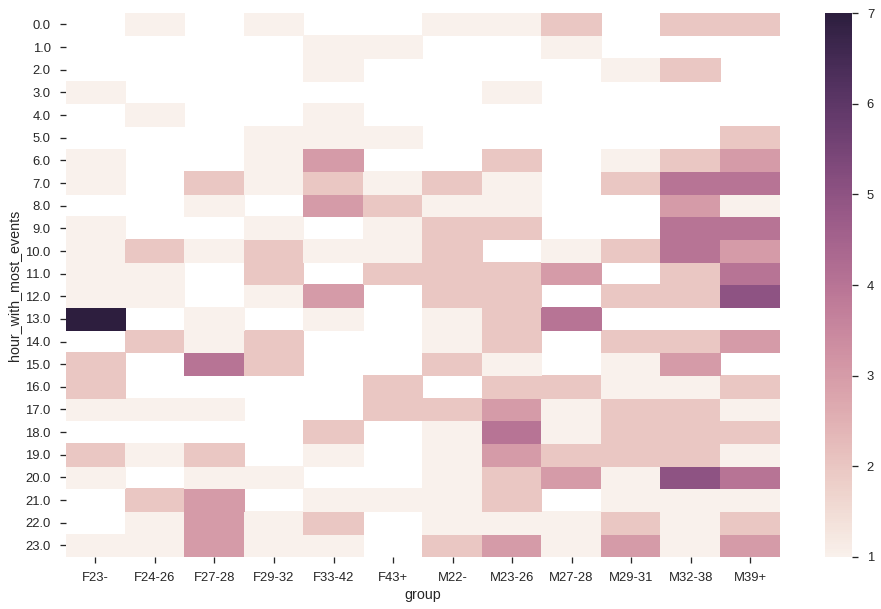

In [15]:
fig, ax = plt.subplots(1, figsize=(16, 10))

sns.heatmap(df.groupby(['hour_with_most_events', 'group']).size().unstack());

In [5]:
%%time

# number of events generated by a device
num_events = events.device_id.value_counts()

df = gender_age_train.sample(n=1000)
df.loc[:, 'num_events'] = df.device_id.map(num_events)

CPU times: user 122 ms, sys: 37.1 ms, total: 159 ms
Wall time: 159 ms


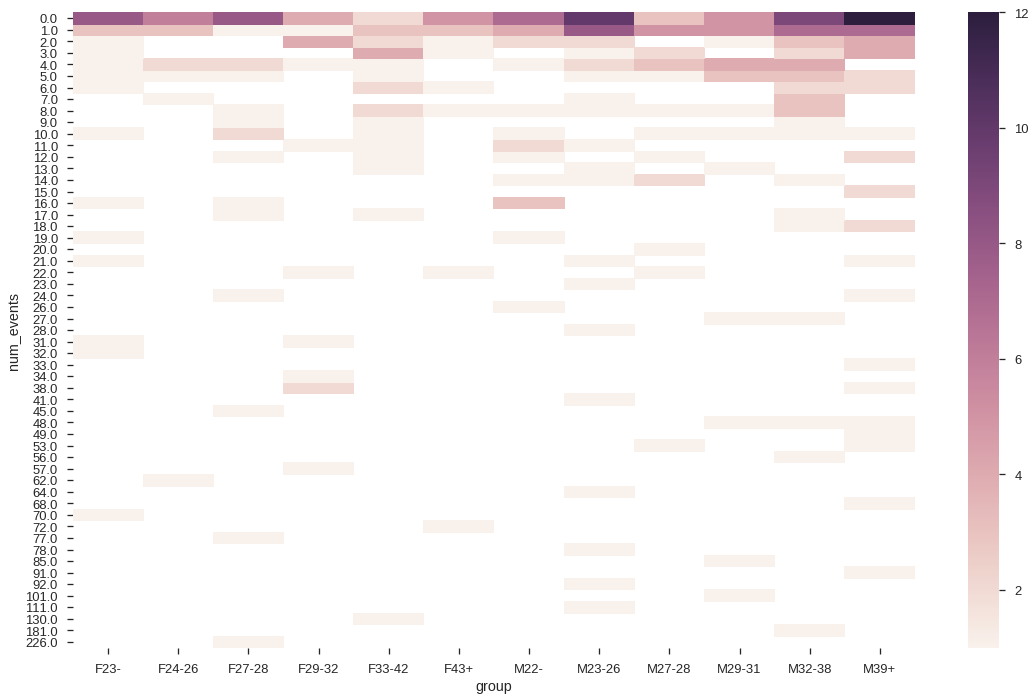

In [14]:
fig, ax = plt.subplots(1, figsize=(16, 10))

sns.heatmap(df.groupby([df.num_events // 5, 'group']).size().unstack())
plt.tight_layout();

** Most of the devices didn't generate any events. **

In [231]:
df.groupby('phone_brand').apply(lambda x: np.sum(pd.notnull(x['event_id'])))

phone_brand
Gionee      109
HTC          43
Huawei     4815
Ktouch       40
LG            1
Lovme         0
Meizu      1032
OPPO       5530
TCL           8
bigcola       0
bodao         0
ccmc         13
dowe          8
greeno        0
hammer       40
hisense       0
ipair         1
koobee        0
lenovo      348
lshi        534
meitu        59
mengmi        1
micky         0
mige          0
millet     2990
moto         39
nokia         0
nubia       133
obi           3
oneplus      25
ouxin         1
samsung    4263
vivo        799
ximi          0
yougo         0
youmi         0
yuxin         0
中兴          251
戴尔            0
百立丰           0
索尼            0
酷比            1
酷派          805
dtype: int64

#### Device Brand and App Id

In [6]:
gender_age_train.sample(n=100).head(5)

,device_id,gender,age,group
38323,8239710598955440465,M,42,M39+
3735,1435517119838754361,M,30,M29-31
64949,298657525600066164,M,36,M32-38
10860,-3606397892081255618,M,27,M27-28
4944,-1661424138789492049,M,24,M23-26


In [7]:
gender_age_train.sample(n=100)\
                .merge(events, on='device_id', how='left')\
                .merge(app_events, on='event_id', how='left')

,device_id,gender,age,group,event_id,timestamp,longitude,latitude,app_id,is_active
0,6954334625229357526,M,25,M23-26,706148,2016-05-06 11:01:02,0.0,0.0,-7.377004e+18,0.0
1,6954334625229357526,M,25,M23-26,706148,2016-05-06 11:01:02,0.0,0.0,4.460015e+18,0.0
2,6954334625229357526,M,25,M23-26,706148,2016-05-06 11:01:02,0.0,0.0,1.001398e+18,1.0
3,6954334625229357526,M,25,M23-26,706148,2016-05-06 11:01:02,0.0,0.0,5.927333e+18,0.0
4,6954334625229357526,M,25,M23-26,706148,2016-05-06 11:01:02,0.0,0.0,-2.705586e+18,1.0
5,6954334625229357526,M,25,M23-26,706148,2016-05-06 11:01:02,0.0,0.0,8.026408e+18,0.0
6,6954334625229357526,M,25,M23-26,706148,2016-05-06 11:01:02,0.0,0.0,-3.955213e+18,1.0
7,6954334625229357526,M,25,M23-26,706148,2016-05-06 11:01:02,0.0,0.0,8.693964e+18,1.0
8,6954334625229357526,M,25,M23-26,706148,2016-05-06 11:01:02,0.0,0.0,-4.475974e+18,1.0
9,6954334625229357526,M,25,M23-26,706148,2016-05-06 11:01:02,0.0,0.0,-5.372083e+18,1.0


In [44]:
# link devices with events
# link events with apps
# only 1000 random devices in training set
df = gender_age_train.sample(n=1000).merge(events, on='device_id', how='left')\
                                    .merge(app_events, on='event_id', how='left')
    
df.head()

,device_id,gender,age,group,event_id,timestamp,longitude,latitude,app_id,is_active
0,-9204974277255292704,M,27,M27-28,NaN,NaT,NaN,NaN,NaN,NaN
1,-441505588648591057,M,21,M22-,557378,2016-05-03 18:12:32,0.0,0.0,1.000519e+18,0.0
2,-441505588648591057,M,21,M22-,557378,2016-05-03 18:12:32,0.0,0.0,5.927333e+18,0.0
3,-441505588648591057,M,21,M22-,557378,2016-05-03 18:12:32,0.0,0.0,-3.377763e+18,1.0
4,-441505588648591057,M,21,M22-,557378,2016-05-03 18:12:32,0.0,0.0,-6.590030e+18,0.0


In [60]:
df.groupby('device_id').apply(lambda x: x.loc[x.app_id.notnull(), 'app_id'].nunique()).value_counts().iloc[:10]

0     684
28     13
27     10
37      9
36      9
22      9
21      9
19      9
20      8
23      8
dtype: int64

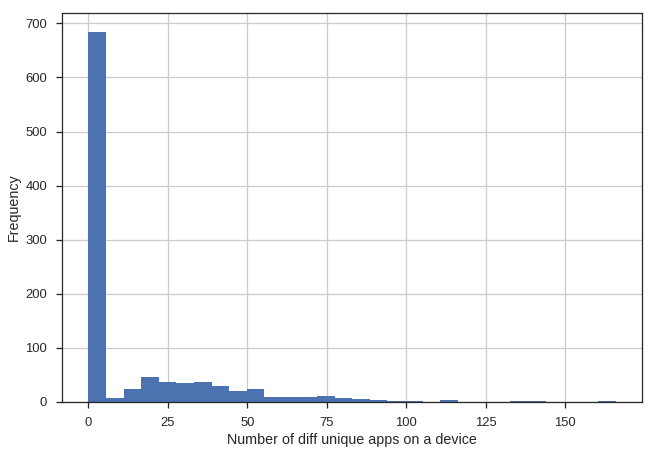

In [57]:
df.groupby('device_id').apply(lambda x: x.loc[x.app_id.notnull(), 'app_id'].nunique()).hist(bins=30)
plt.xlabel('Number of diff unique apps on a device')
plt.ylabel('Frequency');

** This says that most of the devices don't have any applications installed. **

In [63]:
%%time

df = gender_age_train.sample(n=1000).merge(events, on='device_id', how='left')\
                                    .merge(app_events, on='event_id', how='left')\
                                    .merge(phone_brand_device_model, on='device_id', how='left')

CPU times: user 3.48 s, sys: 1.19 s, total: 4.67 s
Wall time: 4.68 s


In [66]:
df.groupby('phone_brand').apply(lambda x: x.loc[x.app_id.notnull(), 'app_id'].nunique()).sort_values(ascending=False)

phone_brand
华为       1051
小米        892
三星        567
OPPO      566
魅族        463
vivo      314
酷派        297
乐视        210
努比亚       205
金立        139
一加        134
HTC       132
联想        118
中兴        104
ZUK        85
原点         70
语信         62
奇酷         43
锤子         41
海信         37
索尼         34
亿通         23
朵唯         16
美图          0
酷比魔方        0
LG          0
LOGO        0
Lovme       0
酷珀          0
TCL         0
波导          0
谷歌          0
富可视         0
梦米          0
中国移动        0
艾优尼         0
米歌          0
优米          0
先锋          0
糖葫芦         0
dtype: int64

** There are some phone brands with no apps installed in any of the devices. **

#### Device Brand and Timestamp

In [46]:
def plot_device_freq(df, device_id):
    plt.figure(figsize=(16, 6))
    df.loc[df.device_id == device_id, 'timestamp'].dt.hour.hist(bins=50)
    plt.xlabel('Hour of the day')
    plt.ylabel('Freq')
    plt.title('Device Id: {}'.format(device_id));
    
def plot_brand_freq(df, phone_brand):
    plt.figure(figsize=(16, 6))
    df.loc[df.phone_brand == phone_brand, 'timestamp'].dt.hour.hist(bins=50)
    plt.xlabel('Hour of the day')
    plt.ylabel('Freq')
    plt.title('Phone Brand: {}'.format(phone_brand));
    
def plot_brand_freq_weekday(df, phone_brand):
    plt.figure(figsize=(16, 6))
    df.loc[df.phone_brand == phone_brand, 'timestamp'].dt.weekday.hist(bins=50)
    plt.xlabel('Day of the week')
    plt.ylabel('Freq')
    plt.title('Phone Brand: {}'.format(phone_brand));

In [5]:
df = gender_age_train.sample(n=1000).merge(events, on='device_id', how='left')
df.head()

,device_id,gender,age,group,event_id,timestamp,longitude,latitude
0,-9204974277255292704,M,27,M27-28,NaN,NaT,NaN,NaN
1,-441505588648591057,M,21,M22-,557378.0,2016-05-03 18:12:32,0.0,0.0
2,6083722372251231386,F,44,F43+,NaN,NaT,NaN,NaN
3,-5318942038990313697,M,25,M23-26,NaN,NaT,NaN,NaN
4,4657022863909368175,M,25,M23-26,NaN,NaT,NaN,NaN


In [40]:
df.groupby(['device_id']).size().sort_values(ascending=False).iloc[:10]

device_id
 6435531434380257148    830
 3048313857640949404    483
-5102294628467403240    469
-5132208792582977295    357
-6933300727973832292    273
 1674488115256346770    273
 2687325872968779987    252
 6509501325763491288    251
 1115780739429645010    248
-2834502789754155049    245
dtype: int64

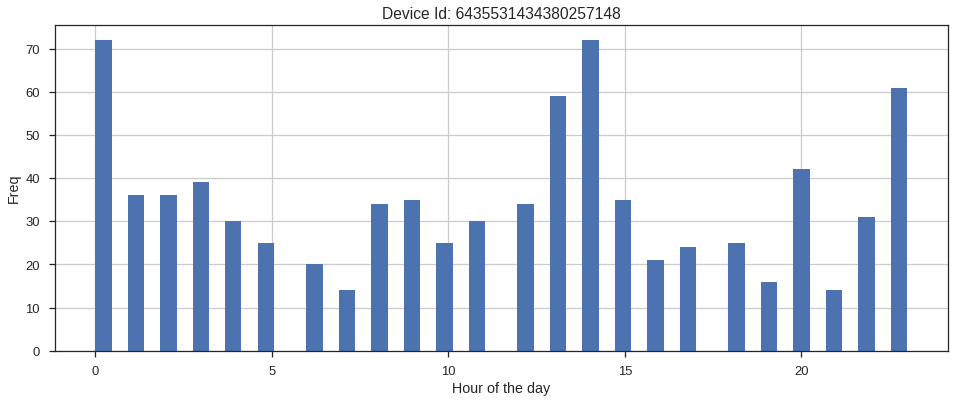

In [41]:
plot_device_freq(df, 6435531434380257148)

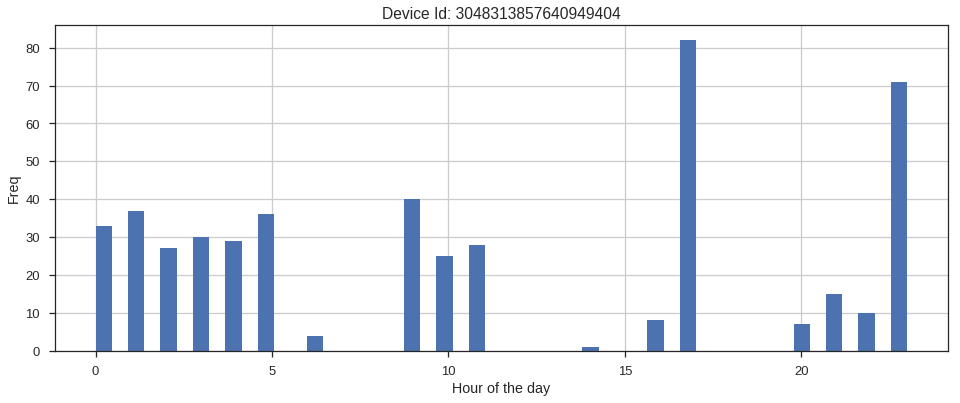

In [42]:
plot_device_freq(df, 3048313857640949404)

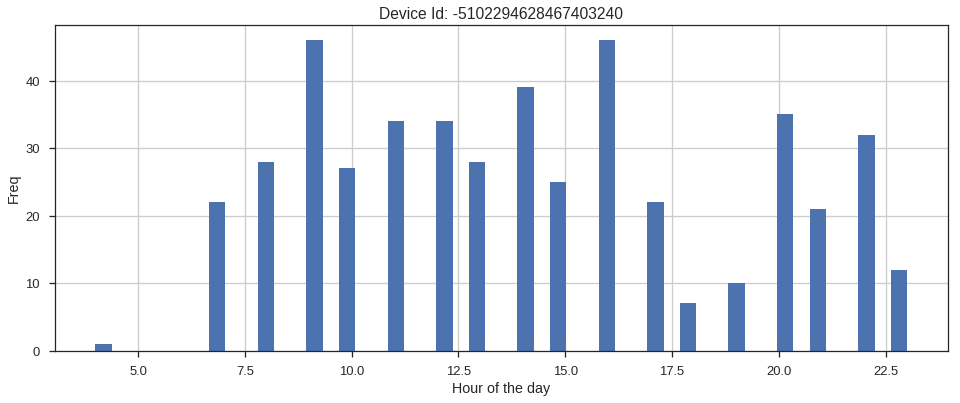

In [43]:
plot_device_freq(df, -5102294628467403240)

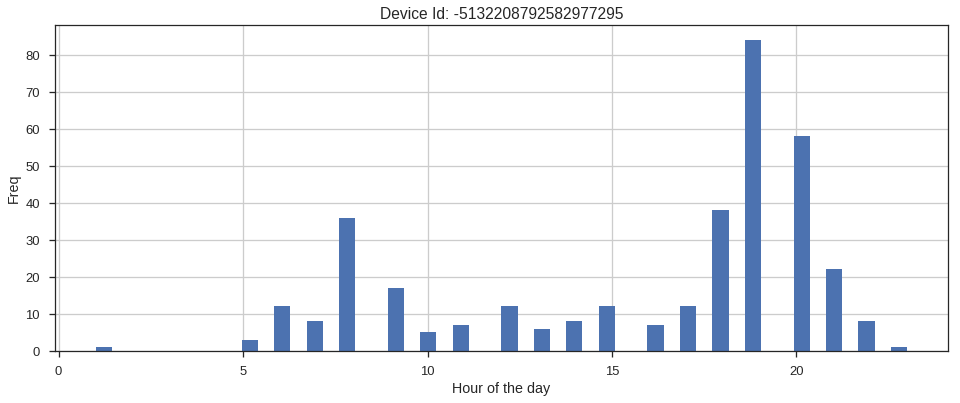

In [44]:
plot_device_freq(df, -5132208792582977295)

** Different active hours for different devices **

In [32]:
df = gender_age_train.sample(n=1000).merge(events, on='device_id', how='left')\
                     .merge(phone_brand_device_model, on='device_id', how='left')
df.loc[:, 'phone_brand'] = df.phone_brand.map(lambda x: chinese_to_eng_brands[x] if x in chinese_to_eng_brands else x)
df.head()

,device_id,gender,age,group,event_id,timestamp,longitude,latitude,phone_brand,device_model
0,6954334625229357526,M,25,M23-26,706148.0,2016-05-06 11:01:02,0.0,0.0,Gionee,E6
1,-8440263119312582746,F,26,F24-26,NaN,NaT,NaN,NaN,millet,MI 2S
2,4909182128667866063,M,48,M39+,NaN,NaT,NaN,NaN,samsung,Galaxy J5
3,-7202171161359183647,M,21,M22-,NaN,NaT,NaN,NaN,Huawei,Mate S
4,-8524462001039508574,F,42,F33-42,86032.0,2016-05-05 08:25:08,0.0,0.0,lshi,超级手机1s


In [33]:
df.phone_brand.value_counts().iloc[:5]

millet     3777
Huawei     3381
samsung    1504
OPPO       1494
Meizu      1453
Name: phone_brand, dtype: int64

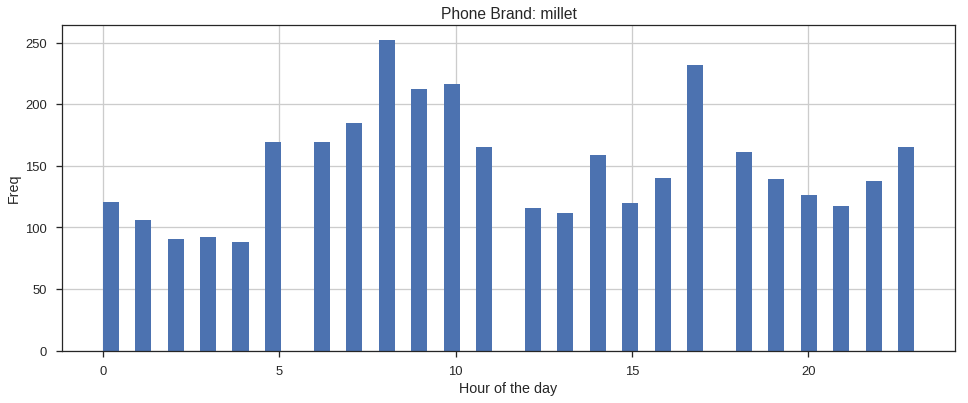

In [34]:
plot_brand_freq(df, 'millet')

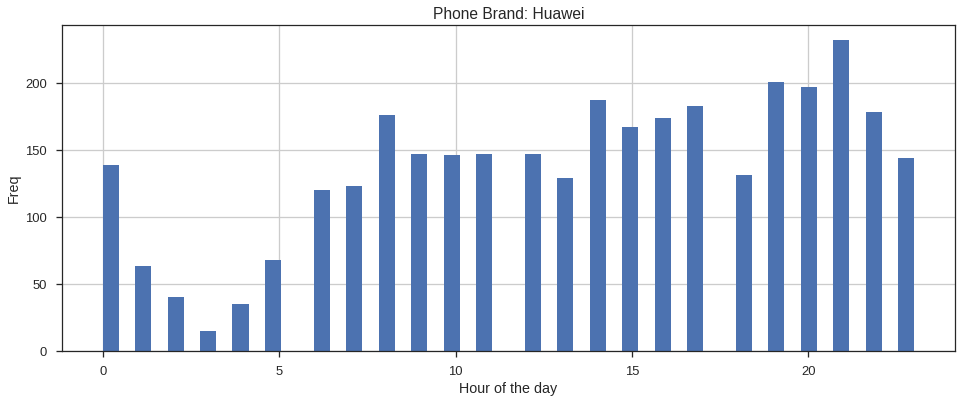

In [35]:
plot_brand_freq(df, 'Huawei')

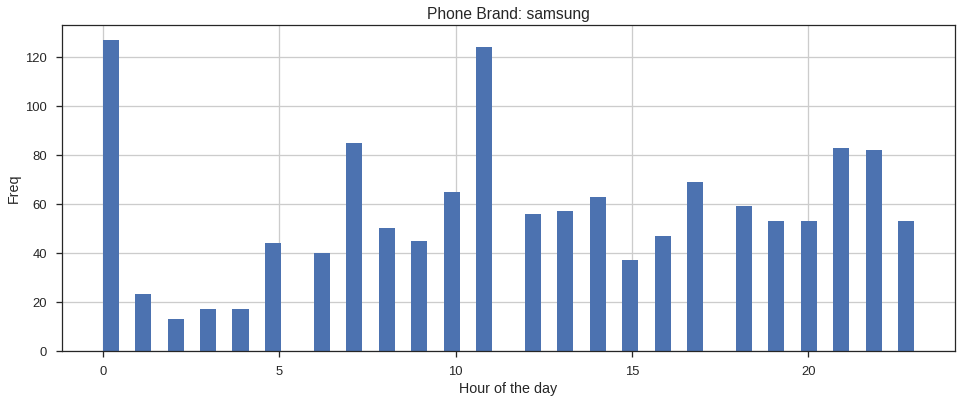

In [36]:
plot_brand_freq(df, 'samsung')

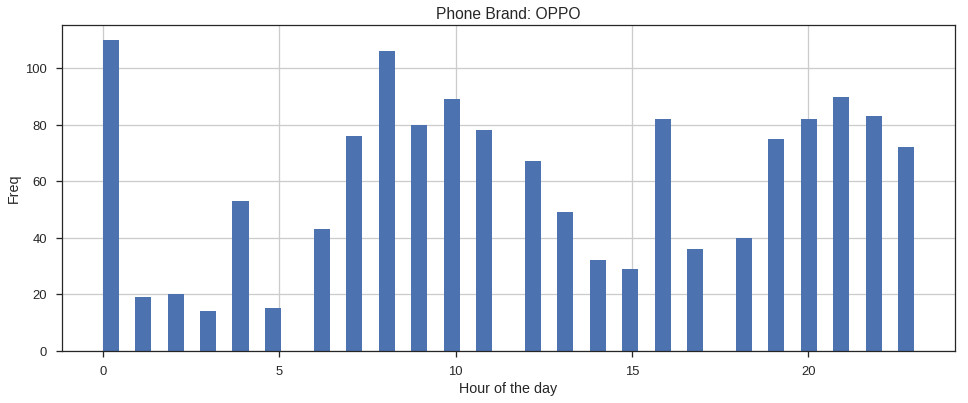

In [37]:
plot_brand_freq(df, 'OPPO')

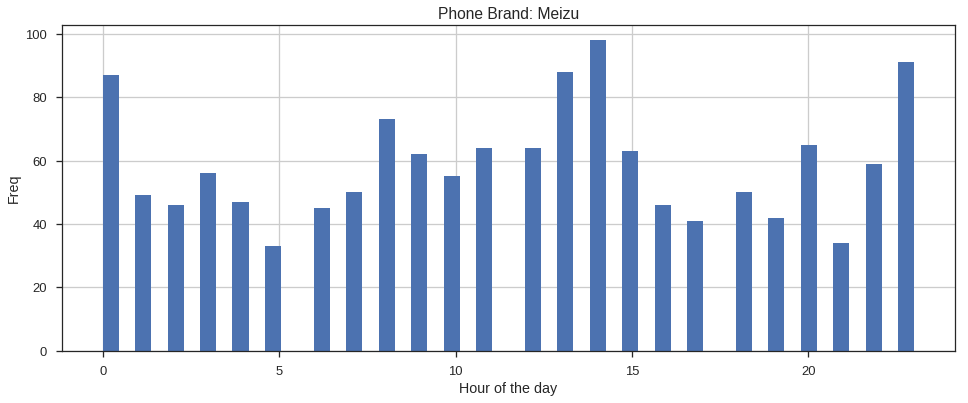

In [45]:
plot_brand_freq(df, 'Meizu')

** Different active hours for different phone brands as well **

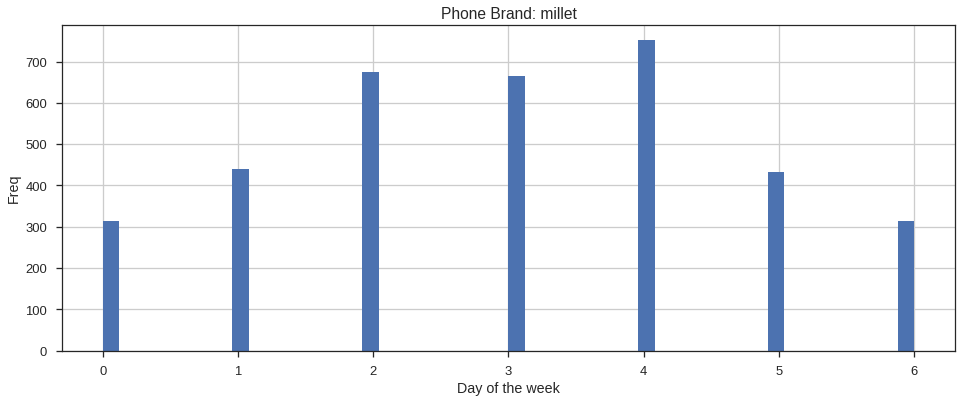

In [47]:
plot_brand_freq_weekday(df, 'millet')

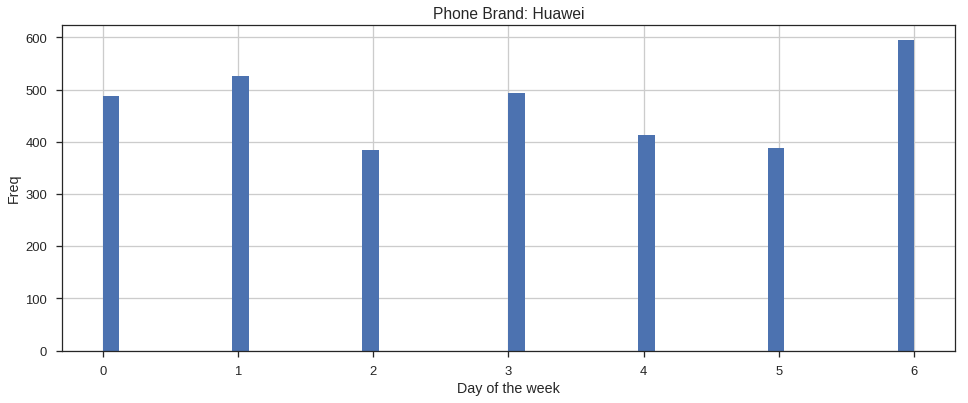

In [48]:
plot_brand_freq_weekday(df, 'Huawei')

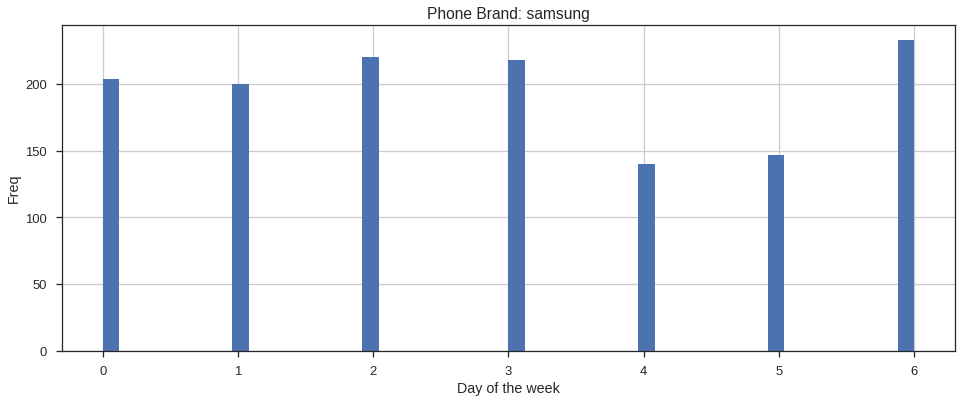

In [49]:
plot_brand_freq_weekday(df, 'samsung')

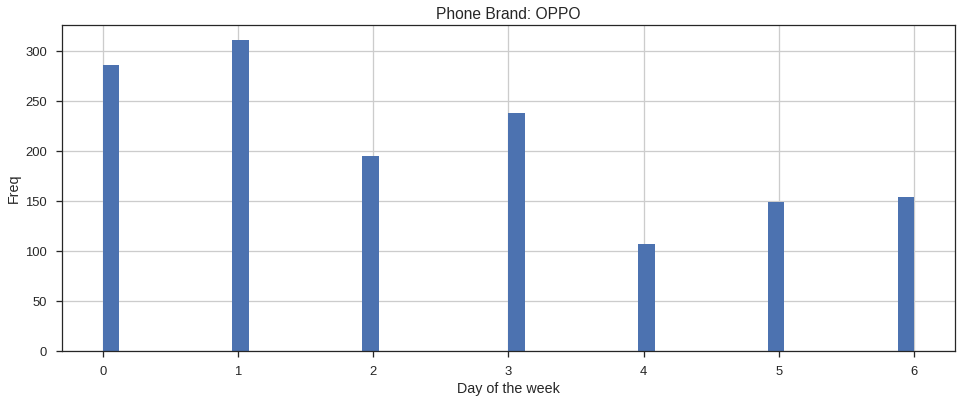

In [50]:
plot_brand_freq_weekday(df, 'OPPO')

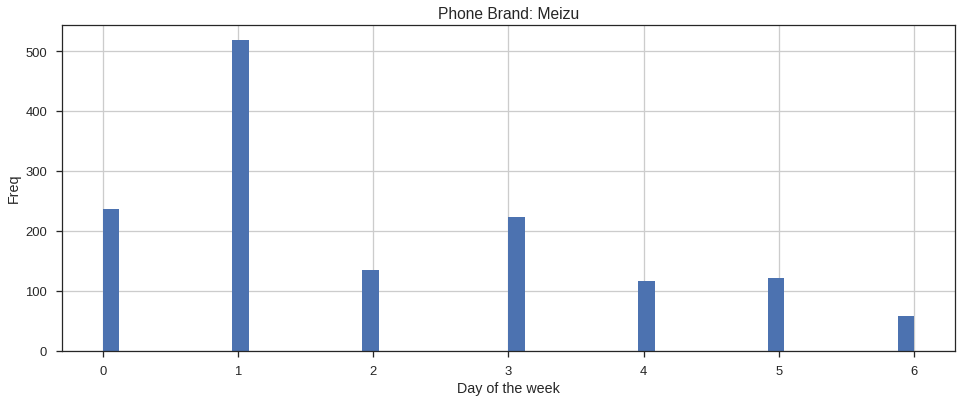

In [51]:
plot_brand_freq_weekday(df, 'Meizu')

** Different patterns for weeday as well. **

#### Device Brand and Location

In [52]:
df = gender_age_train.sample(n=1000).merge(events, on='device_id', how='left')\
                     .merge(phone_brand_device_model, on='device_id', how='left')
df.loc[:, 'phone_brand'] = df.phone_brand.map(lambda x: chinese_to_eng_brands[x] if x in chinese_to_eng_brands else x)
df.head()

,device_id,gender,age,group,event_id,timestamp,longitude,latitude,phone_brand,device_model
0,3440042821272883546,M,25,M23-26,NaN,NaT,NaN,NaN,Meizu,MX4 Pro
1,3394711704614777142,F,24,F24-26,NaN,NaT,NaN,NaN,millet,MI 4
2,-6937211440236953141,M,26,M23-26,NaN,NaT,NaN,NaN,vivo,Y33
3,-8165649367872576237,M,32,M32-38,NaN,NaT,NaN,NaN,Huawei,荣耀3C
4,-6243392779260071023,M,34,M32-38,488.0,2016-05-04 00:07:35,116.46,40.01,Huawei,荣耀6


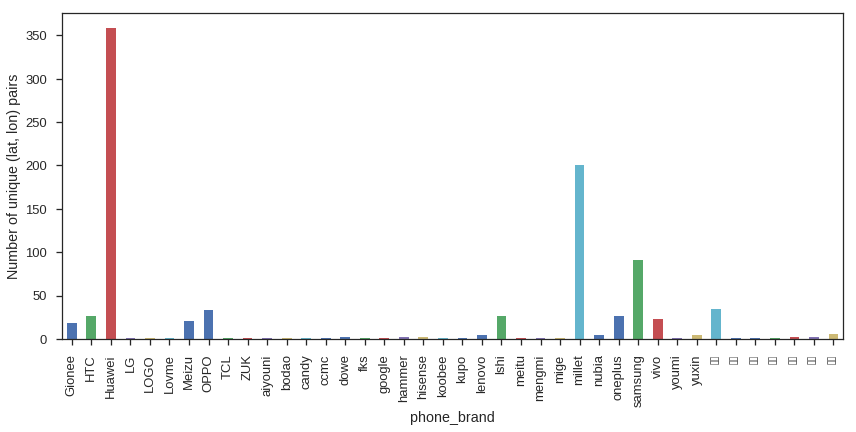

In [57]:
plt.figure(figsize=(14, 6))
df.groupby('phone_brand').apply(lambda x: x[['longitude', 'latitude']].drop_duplicates().shape[0])\
  .plot(kind='bar')
plt.ylabel('Number of unique (lat, lon) pairs');

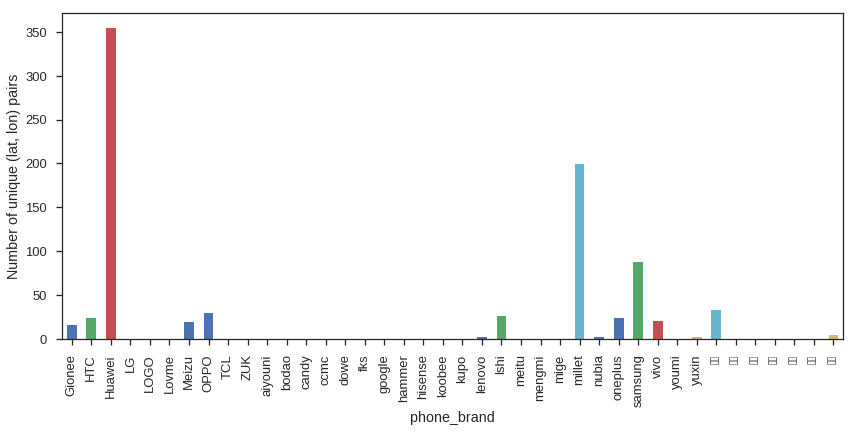

In [66]:
# remove incorrect lat, lon pairs
plt.figure(figsize=(14, 6))
df.groupby('phone_brand').apply(lambda x: x.loc[(x.longitude > 1) & (x.latitude > 1) &\
                                                (x.longitude.notnull()) & (x.latitude.notnull()), ['longitude', 'latitude']].drop_duplicates().shape[0])\
  .plot(kind='bar')
plt.ylabel('Number of unique (lat, lon) pairs');

#### Device Brand and is_active

In [70]:
%%time

df = gender_age_train.sample(n=1000).merge(events, on='device_id', how='left')\
                                    .merge(app_events, on='event_id', how='left')\
                                    .merge(phone_brand_device_model, on='device_id', how='left')
        
df.loc[:, 'phone_brand'] = df.phone_brand.map(lambda x: chinese_to_eng_brands[x] if x in chinese_to_eng_brands else x)

df.head()

CPU times: user 3.55 s, sys: 1.08 s, total: 4.63 s
Wall time: 4.64 s


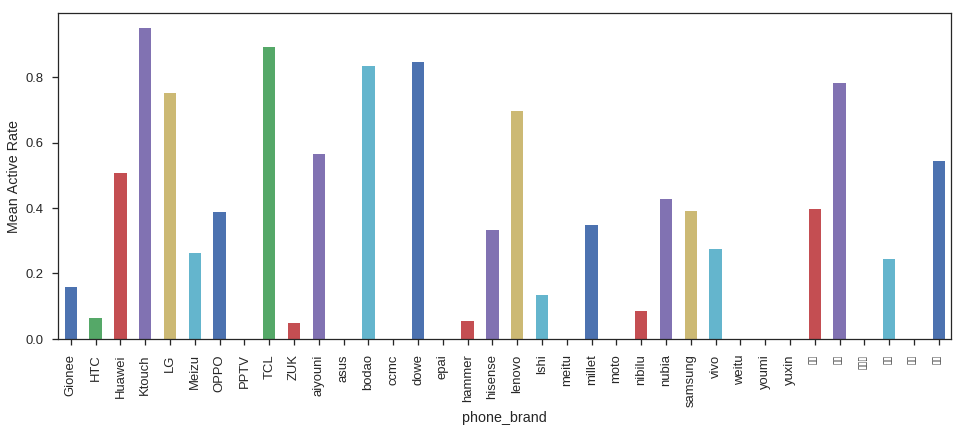

In [73]:
plt.figure(figsize=(16, 6))
df.groupby('phone_brand')['is_active'].mean().plot(kind='bar')
plt.ylabel('Mean Active Rate');

#### Device Brand and App Category

In [80]:
%%time

df = gender_age_train.sample(n=1000).merge(events, on='device_id', how='left')\
                                    .merge(app_events, on='event_id', how='left')\
                                    .merge(phone_brand_device_model, on='device_id', how='left')\
                                    .merge(app_labels, on='app_id', how='left')\
                                    .merge(label_categories, on='label_id', how='left')

df.loc[:, 'phone_brand'] = df.phone_brand.map(lambda x: chinese_to_eng_brands[x] if x in chinese_to_eng_brands else x)

CPU times: user 4.03 s, sys: 1.15 s, total: 5.18 s
Wall time: 5.21 s


In [84]:
pd.crosstab(df.phone_brand, df.category)

category,1 free,And the Church,Consumer Finance,Contacts,Cozy 1,Custom label,Customized 1,Debit and credit,Entertainment News,Finance,...,game-Tactics,millitary and wars,news,picture sharing,quality,service,show,takeaway ordering,unknown,video
phone_brand,,,,,,,,,,,,,,,,,,,,,
HTC,0,0,0,0,0,0,2,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Huawei,38,49,0,0,0,86,12,30,12,0,...,37,37,12,0,0,0,3,0,0,4
Ktouch,0,0,0,0,0,0,81,0,81,0,...,0,0,81,0,0,0,0,0,0,0
Meizu,12,0,0,0,12,0,10,0,10,0,...,0,0,10,12,0,0,0,0,0,0
OPPO,1,0,4,0,0,0,66,0,64,0,...,0,0,64,0,0,0,0,1,0,1
ZUK,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
bodao,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
lenovo,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,2,0
lshi,21,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,14,21


#### App id and events

In [232]:
%%time

df = gender_age_train.sample(n=1000)\
                     .merge(events, on='device_id', how='left')\
                     .merge(app_events, on='event_id', how='left')
        
print(df.head())

             device_id gender  age   group event_id           timestamp  \
0  3872451310908903809      F   27  F27-28      NaN                 NaT   
1  2265052726941848458      M   27  M27-28      NaN                 NaT   
2  2767517771958623932      F   27  F27-28      NaN                 NaT   
3 -6175923266906240014      M   50    M39+      NaN                 NaT   
4   621094507109176760      M   30  M29-31    12098 2016-05-04 12:12:01   

   longitude  latitude        app_id  is_active  
0        NaN       NaN           NaN        NaN  
1        NaN       NaN           NaN        NaN  
2        NaN       NaN           NaN        NaN  
3        NaN       NaN           NaN        NaN  
4        0.0       0.0  4.307994e+18        0.0  
CPU times: user 3.6 s, sys: 1.19 s, total: 4.79 s
Wall time: 6.23 s


In [234]:
# app id with most number of events generated
df.groupby('app_id').apply(lambda x: np.sum(pd.notnull(x['event_id']))).sort_values(ascending=False).iloc[:10]

app_id
 8.693964e+18    5041
 5.927333e+18    4216
 4.348660e+18    3995
 6.280209e+17    2863
 3.433290e+18    1903
 5.729517e+18    1372
-8.504476e+18    1279
-2.320784e+18    1266
 6.284165e+18    1264
 8.948670e+18    1144
dtype: int64

In [236]:
# app id with most number of unique events
df.groupby('app_id').apply(lambda x: x['event_id'].nunique()).sort_values(ascending=False).iloc[:10]

app_id
 8.693964e+18    4993
 5.927333e+18    4216
 4.348660e+18    3995
 6.280209e+17    2863
 3.433290e+18    1903
 5.729517e+18    1372
-8.504476e+18    1279
-2.320784e+18    1266
 6.284165e+18    1264
 8.948670e+18    1144
dtype: int64

#### App Id and Timestamp

In [88]:
def plot_app_freq(df, app_id):
    plt.figure(figsize=(16, 6))
    df.loc[df.app_id == app_id, 'timestamp'].dt.hour.hist(bins=50)
    plt.xlabel('Hour of the day')
    plt.ylabel('Freq')
    plt.title('App Id: {}'.format(app_id));

In [87]:
df = events.sample(n=1000).merge(app_events, on='event_id', how='left')
df.head()

,event_id,device_id,timestamp,longitude,latitude,app_id,is_active
0,73181,-9018175415237137477,2016-05-04 06:54:30,106.58,29.65,2.746292e+18,0.0
1,73181,-9018175415237137477,2016-05-04 06:54:30,106.58,29.65,4.460015e+18,0.0
2,73181,-9018175415237137477,2016-05-04 06:54:30,106.58,29.65,5.927333e+18,1.0
3,73181,-9018175415237137477,2016-05-04 06:54:30,106.58,29.65,7.316250e+18,0.0
4,73181,-9018175415237137477,2016-05-04 06:54:30,106.58,29.65,-9.142957e+18,0.0


In [104]:
df.app_id.value_counts().iloc[:5].index.values[4].astype(np.int64)

3433289601737013248

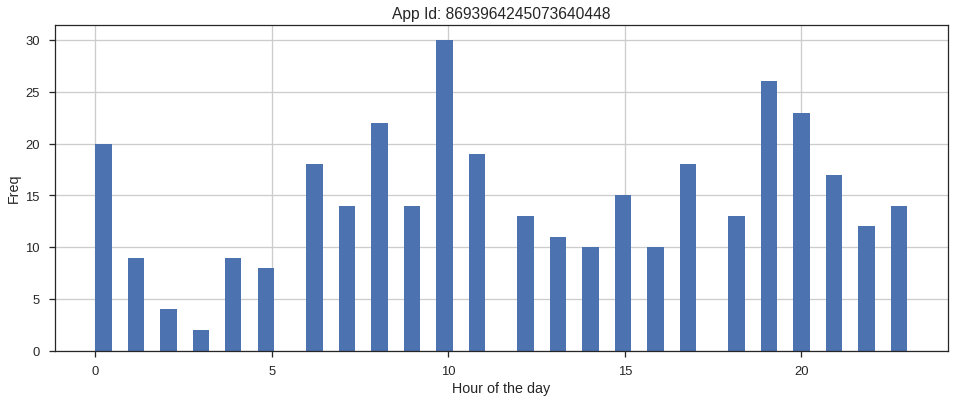

In [97]:
plot_app_freq(df, 8693964245073640448)

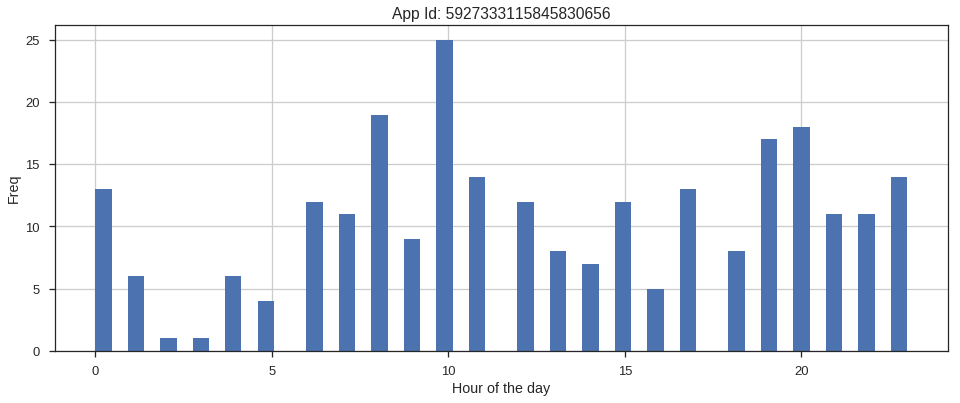

In [99]:
plot_app_freq(df, 5927333115845830656)

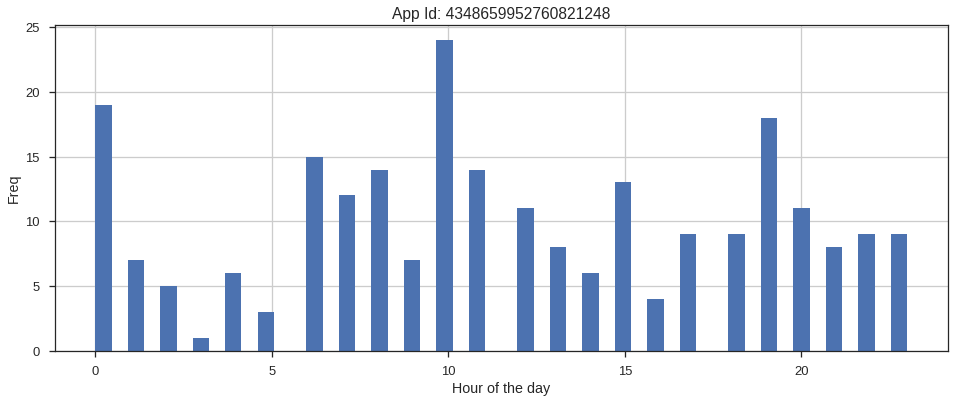

In [101]:
plot_app_freq(df, 4348659952760821248)

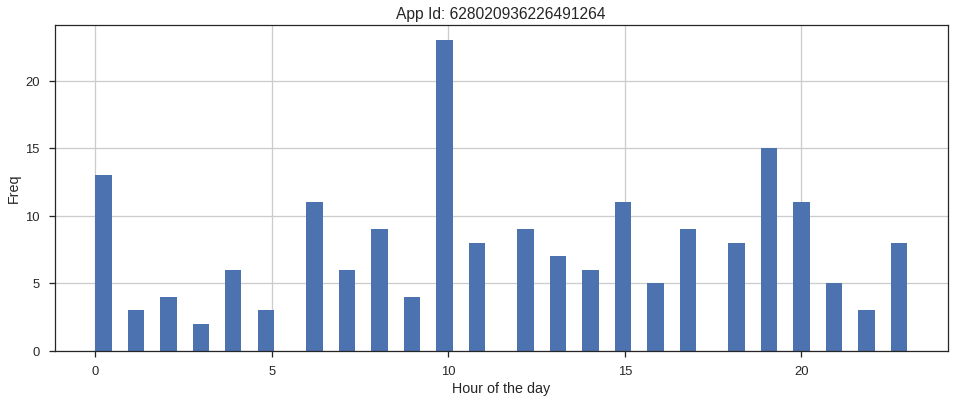

In [103]:
plot_app_freq(df, 628020936226491264)

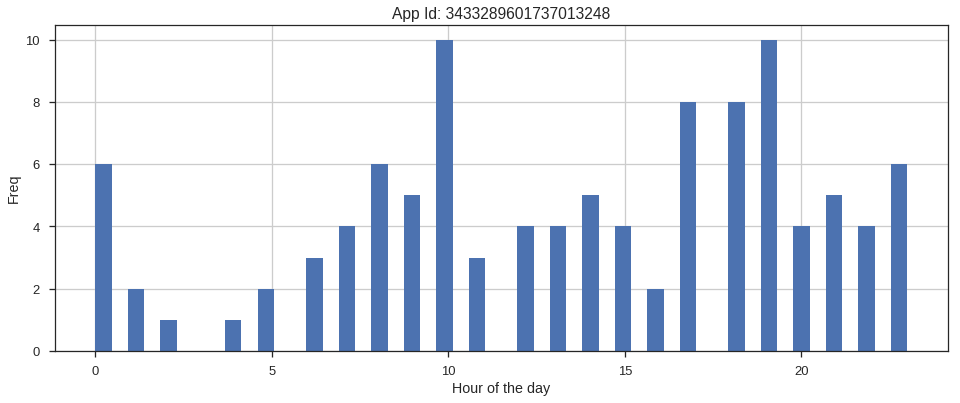

In [105]:
plot_app_freq(df, 3433289601737013248)

#### App Id and Location

In [106]:
df = events.sample(n=1000).merge(app_events, on='event_id', how='left')
df.head()

,event_id,device_id,timestamp,longitude,latitude,app_id,is_active
0,1313222,156879307584217176,2016-05-05 13:08:35,104.00,30.00,NaN,NaN
1,2013456,-65229127726263035,2016-05-01 03:12:25,113.91,22.96,NaN,NaN
2,1993972,8322396725169306034,2016-05-05 10:37:36,0.00,0.00,-7.937803e+18,0.0
3,1993972,8322396725169306034,2016-05-05 10:37:36,0.00,0.00,7.875773e+18,0.0
4,1993972,8322396725169306034,2016-05-05 10:37:36,0.00,0.00,-5.351287e+18,0.0


In [107]:
df.groupby('app_id').apply(lambda x: x.loc[(x.longitude > 1) & (x.latitude > 1) &\
                                           (x.longitude.notnull()) & (x.latitude.notnull()), ['longitude', 'latitude']].drop_duplicates().shape[0])

app_id
-9.208021e+18     2
-9.198654e+18     1
-9.192351e+18     0
-9.189021e+18     2
-9.179016e+18     1
-9.167778e+18     0
-9.166950e+18     0
-9.157897e+18     0
-9.142957e+18     5
-9.129110e+18     0
-9.122066e+18     1
-9.120507e+18     0
-9.104338e+18     5
-9.100764e+18     2
-9.096433e+18     0
-9.096029e+18     0
-9.085479e+18     0
-9.059269e+18     0
-9.059006e+18     0
-9.050100e+18    11
-9.045431e+18     1
-9.025895e+18     5
-9.021996e+18     0
-8.982526e+18     0
-8.967115e+18     2
-8.942695e+18    12
-8.941480e+18     0
-8.936657e+18     0
-8.928533e+18     1
-8.927848e+18     0
                 ..
 8.954391e+18     3
 8.969596e+18     1
 9.002647e+18     0
 9.010423e+18     0
 9.017161e+18     0
 9.031785e+18     1
 9.055434e+18     0
 9.067865e+18     1
 9.073745e+18     0
 9.076980e+18     1
 9.100768e+18     2
 9.109679e+18     0
 9.112462e+18     0
 9.112463e+18     1
 9.112463e+18     0
 9.112463e+18     1
 9.112463e+18     1
 9.112463e+18    28
 9.112463e+18

In [108]:
_.sort_values(ascending=False).iloc[:10]

app_id
 8.693964e+18    111
 5.927333e+18     90
 4.348660e+18     89
 6.280209e+17     65
 3.433290e+18     44
 3.717049e+18     33
-5.368809e+18     32
 7.460083e+18     30
 5.729517e+18     29
-2.320784e+18     29
dtype: int64

#### App id and is_active

In [109]:
df = events.sample(n=1000).merge(app_events, on='event_id', how='left')
df.head()

,event_id,device_id,timestamp,longitude,latitude,app_id,is_active
0,666767,-3434439284578235902,2016-05-05 05:37:13,113.38,35.19,NaN,NaN
1,991273,-8340098378141155823,2016-05-02 15:57:42,111.92,34.74,NaN,NaN
2,1416358,4774326897757296915,2016-05-05 23:46:43,0.00,0.00,-5.380614e+17,1.0
3,1416358,4774326897757296915,2016-05-05 23:46:43,0.00,0.00,-5.472633e+18,1.0
4,3066112,-7931819755443030320,2016-05-04 13:20:05,113.31,40.08,NaN,NaN


In [112]:
df.groupby('app_id').agg({'is_active': [len, np.mean]})

is_active          
                    len      mean
app_id                           
-9.216716e+18       1.0  0.000000
-9.208021e+18       1.0  0.000000
-9.189021e+18       1.0  0.000000
-9.166950e+18       1.0  0.000000
-9.163199e+18       2.0  0.000000
-9.142957e+18       6.0  0.000000
-9.139548e+18       1.0  0.000000
-9.129110e+18       1.0  0.000000
-9.129110e+18       3.0  0.333333
-9.122066e+18       5.0  0.000000
-9.104338e+18       8.0  0.250000
-9.100764e+18       7.0  0.142857
-9.100764e+18       1.0  0.000000
-9.096029e+18       1.0  0.000000
-9.093214e+18       1.0  0.000000
-9.059006e+18       3.0  1.000000
-9.050100e+18      14.0  0.000000
-9.040115e+18       1.0  0.000000
-9.031288e+18       1.0  0.000000
-9.025895e+18       5.0  0.000000
-9.017006e+18       1.0  0.000000
-9.001883e+18       1.0  0.000000
-8.982526e+18       3.0  0.000000
-8.967115e+18       4.0  0.750000
-8.942695e+18      16.0  0.000000
-8.941480e+18       2.0  0.500000
-8.936657e+18       1.0  0.000000
-8.928533e+18       1.0  0.000000
-8.885457e+18       1.0  0.000000
-8.845948e+18       1.0  0.000000
...                 ...       ...
 8.973273e+18       1.0  0.000000
 8.973273e+18       1.0  1.000000
 8.982695e+18       2.0  0.000000
 9.009774e+18       1.0  0.000000
 9.017161e+18       1.0  0.000000
 9.031785e+18       5.0  0.200000
 9.036261e+18       2.0  0.000000
 9.036774e+18       1.0  0.000000
 9.055434e+18       1.0  0.000000
 9.067865e+18       2.0  0.000000
 9.076980e+18       5.0  1.000000
 9.083848e+18       1.0  0.000000
 9.100768e+18       1.0  0.000000
 9.112462e+18       3.0  0.000000
 9.112463e+18       1.0  0.000000
 9.112463e+18       1.0  0.000000
 9.112463e+18       1.0  0.000000
 9.112463e+18       3.0  0.000000
 9.112463e+18       2.0  0.000000
 9.112463e+18       2.0  0.000000
 9.112463e+18      59.0  0.135593
 9.112463e+18       5.0  0.200000
 9.112463e+18       3.0  0.000000
 9.112463e+18       1.0  0.000000
 9.130262e+18       2.0  0.000000
 9.136721e+18      18.0  0.055556
 9.191282e+18       2.0  0.500000
 9.191282e+18       7.0  0.000000
 9.212661e+18       3.0  0.666667
 9.220205e+18       8.0  0.375000

[1785 rows x 2 columns]

#### App id and category

- An app can be associated with multiple categories.
- Very few apps have category associated with them.

In [319]:
%%time

df = events.sample(n=1000).merge(app_events, on='event_id', how='left')\
                          .merge(app_labels, on='app_id', how='left')\
                          .merge(label_categories, on='label_id', how='left')
print(df.head())

   event_id            device_id           timestamp  longitude  latitude  \
0    520743  4089486733121073710 2016-05-04 16:03:43     114.48     30.61   
1    520743  4089486733121073710 2016-05-04 16:03:43     114.48     30.61   
2   2985359  5063493452354402845 2016-05-06 23:20:49     113.31     23.13   
3   2985359  5063493452354402845 2016-05-06 23:20:49     113.31     23.13   
4   2985359  5063493452354402845 2016-05-06 23:20:49     113.31     23.13   

        app_id  is_active label_id category  
0  3.43329e+18        1.0      NaN      NaN  
1  1.08823e+18        1.0      NaN      NaN  
2 -6.79386e+18        1.0      NaN      NaN  
3 -5.69633e+18        1.0      NaN      NaN  
4  5.92733e+18        1.0      NaN      NaN  
CPU times: user 1.66 s, sys: 857 ms, total: 2.51 s
Wall time: 2.55 s


In [114]:
pd.crosstab(df.app_id, df.category)

category,1 free,And the Church,Car Owners,Contacts,Custom label,Customized 1,Debit and credit,Entertainment News,Financial Services,High risk,...,community,financial,foreign language,game,news,pursue,service,show,unknown,video
app_id,,,,,,,,,,,,,,,,,,,,,
-1.530919e+17,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
-1.265754e+17,0,0,0,0,0,1,0,1,0,0,...,0,0,0,0,1,0,0,0,0,0
-4.909913e+16,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
-1.936277e+16,0,0,0,5,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
-1.771591e+16,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
-1.771591e+16,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
-1.768541e+16,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
-4.986197e+15,6,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,6
-4.986140e+15,0,0,0,0,0,0,0,0,0,0,...,0,5,0,0,0,0,0,0,0,0


In [337]:
_ = df.groupby('app_id').apply(lambda x: '_'.join(pd.Series(x[x.category.notnull()].category.unique()).map(np.str)))
_[_ != ''].iloc[16]

'Trendy / cool 1_Irritation / Fun 1_1 free_1 vitality_Industry tag_Property Industry 2.0_community'

#### Events and Timestamp

In [237]:
%%time

df = gender_age_train.sample(n=1000)\
                     .merge(events, on='device_id', how='left')
    
print(df.head())

             device_id gender  age   group  event_id           timestamp  \
0 -3935652271925844106      M   37  M32-38   28937.0 2016-05-07 23:13:06   
1 -3935652271925844106      M   37  M32-38   61943.0 2016-05-07 22:49:12   
2 -3935652271925844106      M   37  M32-38   61944.0 2016-05-07 22:48:44   
3 -3935652271925844106      M   37  M32-38  167914.0 2016-05-03 08:26:44   
4 -3935652271925844106      M   37  M32-38  167924.0 2016-05-03 08:44:03   

   longitude  latitude  
0     119.79     25.51  
1     119.79     25.51  
2     119.79     25.51  
3     119.77     25.53  
4     119.77     25.53  
CPU times: user 263 ms, sys: 82 ms, total: 345 ms
Wall time: 487 ms


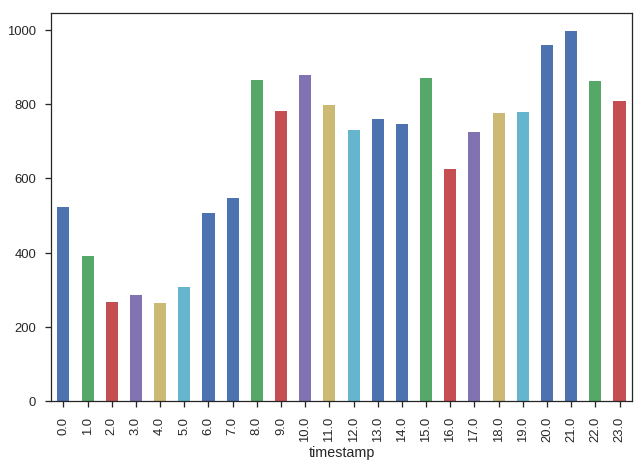

In [244]:
## most number of events by hour
df.groupby(df.timestamp.dt.hour)['event_id'].size().plot(kind='bar');

In [245]:
df.groupby(df.timestamp.dt.weekday)['event_id'].size()

timestamp
0.0    2115
1.0    2385
2.0    2390
3.0    2168
4.0    2425
5.0    2374
6.0    2190
Name: event_id, dtype: int64

#### Events and Location

In [264]:
%%time

df = gender_age_train.sample(n=1000)\
                     .merge(events, on='device_id', how='left')
    
print(df.head())

             device_id gender  age   group  event_id           timestamp  \
0  5693643427958156551      F   33  F33-42   14183.0 2016-05-07 13:26:44   
1  5693643427958156551      F   33  F33-42   26396.0 2016-05-02 22:04:18   
2  5693643427958156551      F   33  F33-42  187997.0 2016-05-02 21:26:13   
3  5693643427958156551      F   33  F33-42  191846.0 2016-05-07 22:26:18   
4  5693643427958156551      F   33  F33-42  288829.0 2016-05-02 21:43:41   

   longitude  latitude  
0     116.05     37.68  
1     116.05     37.65  
2     116.05     37.65  
3     116.05     37.65  
4     116.05     37.65  
CPU times: user 295 ms, sys: 75.7 ms, total: 371 ms
Wall time: 372 ms


In [265]:
df.groupby(df.longitude.astype('str') + '_' + df.latitude.astype('str'))['event_id'].nunique()

0.07_0.16          4
0.0_0.0         4732
0.14_-0.46         4
1.0_1.0          181
102.93_25.1        1
102.97_25.27       2
103.0_25.24      127
103.0_25.25       37
103.15_23.37      20
103.59_30.89       8
103.59_30.9        7
103.61_36.5       92
103.64_36.49       2
103.72_30.92       4
103.73_30.94       1
103.74_29.89       2
103.74_29.91       2
103.74_30.99       1
103.74_31.0        1
103.74_31.01       1
103.75_31.0        7
103.76_29.93       2
103.76_29.94       6
103.76_31.01      23
103.88_30.49       3
103.89_30.49       1
103.91_30.49       1
103.91_30.5        7
103.91_30.58       2
103.91_30.59       1
                ... 
126.55_43.87      32
126.56_43.85       1
126.56_43.86       6
126.56_43.87       2
126.57_43.85       3
126.59_45.7        1
126.59_45.97       5
126.59_45.98      70
126.61_45.7        1
126.61_45.74     310
126.62_45.71       1
126.62_45.74       1
126.63_45.72       1
126.68_45.75       6
126.69_45.76     148
126.6_45.72       11
126.6_45.97  

#### Events and is_active

In [246]:
df = gender_age_train.sample(n=1000)\
                     .merge(events, on='device_id', how='left')\
                     .merge(app_events, on='event_id', how='left')
    
print(df.head())

            device_id gender  age   group event_id           timestamp  \
0 -616357650050212099      M   23  M23-26    58683 2016-05-02 20:58:57   
1 -616357650050212099      M   23  M23-26    58683 2016-05-02 20:58:57   
2 -616357650050212099      M   23  M23-26    58683 2016-05-02 20:58:57   
3 -616357650050212099      M   23  M23-26    58683 2016-05-02 20:58:57   
4 -616357650050212099      M   23  M23-26    58683 2016-05-02 20:58:57   

   longitude  latitude        app_id  is_active  
0        0.0       0.0  5.070414e+18        0.0  
1        0.0       0.0 -5.720079e+18        0.0  
2        0.0       0.0  5.927333e+18        0.0  
3        0.0       0.0  3.433290e+18        1.0  
4        0.0       0.0 -6.531843e+17        0.0  


In [247]:
df.groupby(['is_active']).apply(lambda x: x['event_id'].nunique())

is_active
0.0     3856
1.0    10287
dtype: int64

#### Events and App Category

In [253]:
%%time

df = gender_age_train.sample(n=1000)\
                     .merge(events, on='device_id', how='left')\
                     .merge(app_events, on='event_id', how='left')\
                     .merge(app_labels, on='app_id', how='left')\
                     .merge(label_categories, on='label_id', how='left')
    
print(df.head())

             device_id gender  age   group event_id           timestamp  \
0  6869128639779804936      M   28  M27-28      NaN                 NaT   
1 -4753555870644779587      M   22    M22-      NaN                 NaT   
2  6105593916975764228      M   48    M39+      NaN                 NaT   
3 -5315646035797740368      M   27  M27-28      NaN                 NaT   
4 -2577184409992448286      F   35  F33-42   195821 2016-05-01 08:22:27   

   longitude  latitude app_id  is_active label_id category  
0        NaN       NaN    NaN        NaN      NaN      NaN  
1        NaN       NaN    NaN        NaN      NaN      NaN  
2        NaN       NaN    NaN        NaN      NaN      NaN  
3        NaN       NaN    NaN        NaN      NaN      NaN  
4     113.71      23.1    NaN        NaN      NaN      NaN  
CPU times: user 3.68 s, sys: 1.11 s, total: 4.78 s
Wall time: 4.79 s


In [254]:
df.shape

(165591, 12)

In [257]:
df.groupby('category').apply(lambda x: x['event_id'].nunique())

category
1 free                               38
And the Church                      407
Car Owners                            8
Consumer Finance                     22
Contacts                             16
Custom label                        414
Customized 1                         65
Debit and credit                    497
Entertainment News                   65
Financial Services                  406
High risk                           376
Higher income                       376
Industry tag                        476
Integrated Living                    18
Internet banking                    407
Irritation / Fun 1                    7
Liquid medium                       376
Low Risk                            406
Low income                          406
Low liquidity                       406
P2P                                 463
P2P net loan                        462
Personal Effectiveness               10
Personal Effectiveness 1             79
Property Industry 1.0          

#### Timestamp and Location

In [116]:
events.groupby(events.timestamp.dt.hour).apply(lambda x: x.loc[(x.longitude.notnull()) &\
                                                               (x.latitude.notnull()),
                                                               ['longitude', 'latitude']
                                                              ].drop_duplicates().shape[0])

timestamp
0      9786
1      7097
2      5811
3      4994
4      4781
5      6230
6      9490
7     13014
8     15064
9     15955
10    17074
11    16119
12    15718
13    15236
14    15125
15    15549
16    15513
17    16222
18    15973
19    15308
20    15097
21    14458
22    13274
23    11489
dtype: int64

In [118]:
events.groupby(events.timestamp.dt.weekday).apply(lambda x: x.loc[(x.longitude.notnull()) &\
                                                               (x.latitude.notnull()),
                                                               ['longitude', 'latitude']
                                                              ].drop_duplicates().shape[0])

timestamp
0    24165
1    23974
2    23917
3    23758
4    23721
5    22795
6    24917
dtype: int64

#### Timestamp and is_active

In [120]:
df = events.sample(n=1000).merge(app_events, on='event_id', how='left')
df.head()

,event_id,device_id,timestamp,longitude,latitude,app_id,is_active
0,1753312,-2827162679086651363,2016-05-07 17:08:37,116.65,34.99,NaN,NaN
1,1393748,-3518367124651874351,2016-05-05 19:23:19,0.00,0.00,6.666574e+18,1.0
2,1393748,-3518367124651874351,2016-05-05 19:23:19,0.00,0.00,6.284165e+18,1.0
3,1393748,-3518367124651874351,2016-05-05 19:23:19,0.00,0.00,5.927333e+18,1.0
4,1393748,-3518367124651874351,2016-05-05 19:23:19,0.00,0.00,3.433290e+18,1.0


In [123]:
df.groupby(df.timestamp.dt.hour).agg({'is_active': [len, np.mean]})

is_active          
                len      mean
timestamp                    
0             553.0  0.165725
1             104.0  0.301075
2             169.0  0.496815
3              94.0  0.701149
4             264.0  0.210117
5             489.0  0.200000
6             557.0  0.381651
7             250.0  0.548246
8             677.0  0.307692
9             595.0  0.314035
10            728.0  0.314286
11            544.0  0.435946
12            422.0  0.482323
13            593.0  0.470899
14            526.0  0.437126
15            324.0  0.444068
16            401.0  0.373684
17            622.0  0.306020
18            383.0  0.660969
19            504.0  0.530992
20            466.0  0.428899
21            751.0  0.433333
22            523.0  0.474542
23            265.0  0.364000

In [124]:
df.groupby(df.timestamp.dt.weekday).agg({'is_active': [len, np.mean]})

is_active          
                len      mean
timestamp                    
0            1642.0  0.343389
1            1700.0  0.423666
2            1738.0  0.332330
3            1639.0  0.426938
4            1088.0  0.424779
5            1563.0  0.377461
6            1434.0  0.417277

#### Timestamp and app category

In [141]:
df = events.sample(n=2000).merge(app_events, on='event_id', how='left')\
                          .merge(app_labels, on='app_id', how='left')\
                          .merge(label_categories, on='label_id', how='left')
        
df.head()

,event_id,device_id,timestamp,longitude,latitude,app_id,is_active,label_id,category
0,1786855,-4018106201148474813,2016-05-01 22:04:55,0.0,0.0,8.69396e+18,1.0,NaN,NaN
1,1786855,-4018106201148474813,2016-05-01 22:04:55,0.0,0.0,7.46008e+18,1.0,NaN,NaN
2,1786855,-4018106201148474813,2016-05-01 22:04:55,0.0,0.0,2.10206e+18,1.0,NaN,NaN
3,1786855,-4018106201148474813,2016-05-01 22:04:55,0.0,0.0,5.49711e+18,1.0,NaN,NaN
4,1786855,-4018106201148474813,2016-05-01 22:04:55,0.0,0.0,-1.96592e+17,1.0,NaN,NaN


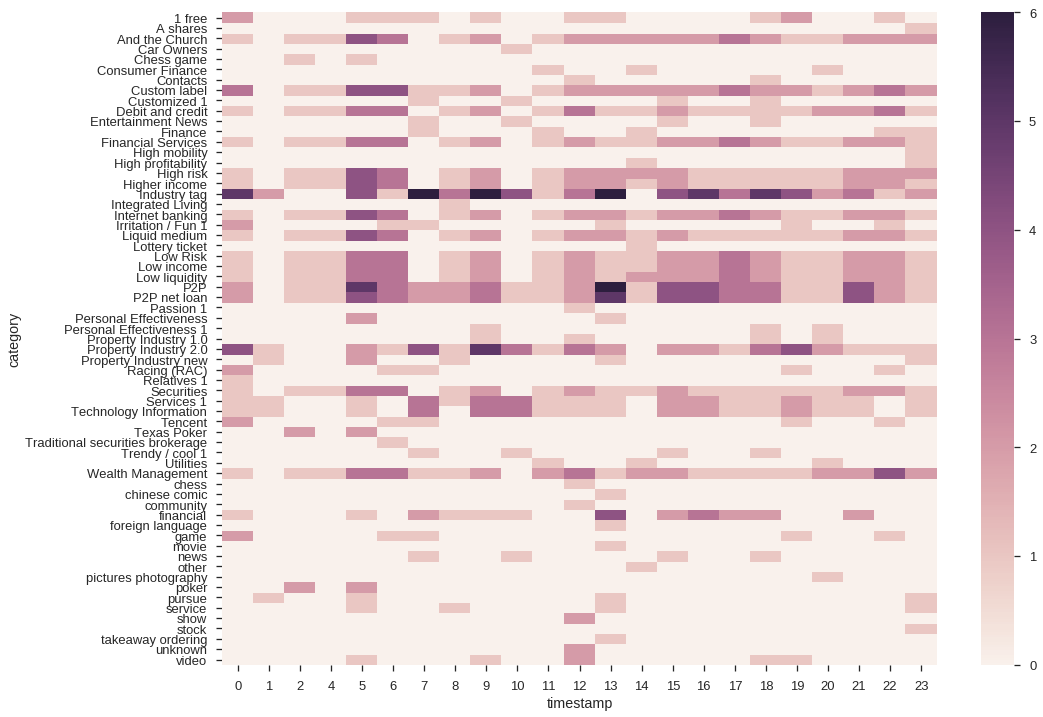

In [142]:
fig, ax = plt.subplots(1, figsize=(16, 12))
sns.heatmap(pd.crosstab(df.category, df.timestamp.dt.hour));

#### Location and is_active

In [143]:
df = events.sample(n=2000).merge(app_events, on='event_id', how='left')
df.head()

,event_id,device_id,timestamp,longitude,latitude,app_id,is_active
0,1356577,-2877666106102886070,2016-05-07 02:46:39,114.64,30.55,4.521627e+18,1.0
1,1356577,-2877666106102886070,2016-05-07 02:46:39,114.64,30.55,6.284165e+18,1.0
2,1356577,-2877666106102886070,2016-05-07 02:46:39,114.64,30.55,5.927333e+18,1.0
3,1356577,-2877666106102886070,2016-05-07 02:46:39,114.64,30.55,3.433290e+18,1.0
4,1356577,-2877666106102886070,2016-05-07 02:46:39,114.64,30.55,-3.955213e+18,1.0


In [144]:
df.groupby(['longitude', 'latitude']).agg({'is_active': [len, np.mean]})

is_active          
                         len      mean
longitude latitude                    
0.00      0.00       11844.0  0.406788
0.83      0.84          53.0  0.094340
1.00      1.00         141.0  0.481481
1.10      0.96          14.0  0.500000
80.25     6.01           1.0       NaN
82.98     46.73         12.0  0.333333
84.71     44.41          1.0       NaN
86.48     48.08          1.0       NaN
98.25     39.78          1.0       NaN
98.49     39.73          7.0  1.000000
100.26    25.60          1.0       NaN
100.74    21.72          1.0       NaN
101.57    25.06          1.0       NaN
101.59    26.60          1.0       NaN
101.75    36.60          1.0       NaN
101.79    28.12          1.0       NaN
101.85    36.58         61.0  0.032787
102.17    24.67         17.0  1.000000
          38.53          1.0       NaN
102.51    24.32          1.0       NaN
102.69    25.07          1.0       NaN
102.70    25.07          1.0       NaN
102.71    25.04          1.0       NaN
102.73    24.18          2.0       NaN
102.74    25.09          2.0  1.000000
102.77    24.98          1.0       NaN
102.78    24.95          1.0  1.000000
          24.98          1.0       NaN
102.92    24.68          1.0       NaN
103.00    25.24          1.0       NaN
...                      ...       ...
125.43    43.88          1.0       NaN
125.56    42.42         16.0  0.500000
125.66    43.54          1.0       NaN
125.93    41.72          4.0  1.000000
125.99    46.07          1.0       NaN
126.02    43.29          1.0       NaN
126.24    42.35          1.0       NaN
126.51    43.21          1.0       NaN
          45.81          1.0       NaN
126.54    43.82          1.0       NaN
          43.84          1.0       NaN
          43.86          1.0       NaN
          45.86          1.0       NaN
126.58    42.04         45.0  0.244444
          42.05         46.0  0.108696
126.61    45.74          2.0       NaN
126.62    45.61          1.0       NaN
126.66    45.69          1.0       NaN
          45.70         48.0  0.479167
126.69    45.77          1.0       NaN
126.84    43.39          1.0       NaN
126.98    46.64          1.0       NaN
128.86    46.95          1.0       NaN
128.92    42.46          2.0  1.000000
129.60    44.56         23.0  0.000000
130.37    46.79         10.0  1.000000
131.00    45.76          1.0       NaN
131.14    44.40          1.0       NaN
131.16    46.63          1.0       NaN
131.88    45.55          1.0       NaN

[1257 rows x 2 columns]

#### Location and App Category

In [146]:
df = events.sample(n=2000).merge(app_events, on='event_id', how='left')\
           .merge(app_labels, on='app_id', how='left')\
           .merge(label_categories, on='label_id', how='left')
        
df.head()

,event_id,device_id,timestamp,longitude,latitude,app_id,is_active,label_id,category
0,3201137,-2668732172869127974,2016-05-06 13:48:00,132.07,47.30,NaN,NaN,NaN,NaN
1,712514,-1471692881227537768,2016-05-04 16:45:31,105.19,37.52,NaN,NaN,NaN,NaN
2,2578749,-2396145017435403006,2016-05-07 09:46:55,121.44,31.13,NaN,NaN,NaN,NaN
3,2461139,4803655746417134710,2016-05-06 19:40:33,115.34,30.06,NaN,NaN,NaN,NaN
4,988264,3729193882279044132,2016-05-03 13:52:09,121.77,39.05,NaN,NaN,NaN,NaN


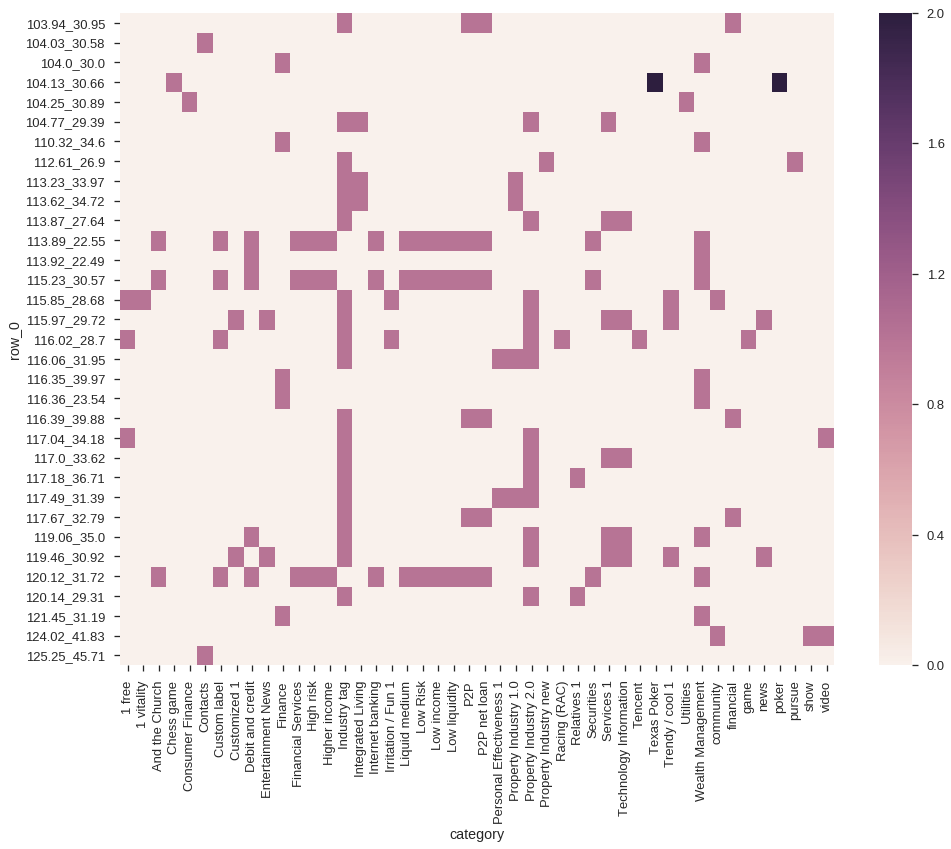

In [151]:
fig, ax = plt.subplots(1, figsize=(16, 12))
sns.heatmap(pd.crosstab(df[df.longitude > 1].longitude.astype(np.str) + '_' + df[df.latitude > 1].latitude.astype(np.str),
            df.category
           ));

#### Phone Brand, Device Model and App Id

In [152]:
%%time

df = gender_age_train.sample(n=1000).merge(events, on='device_id', how='left')\
                                    .merge(app_events, on='event_id', how='left')\
                                    .merge(phone_brand_device_model, on='device_id', how='left')
        
df.loc[:, 'phone_brand'] = df.phone_brand.map(lambda x: chinese_to_eng_brands[x] if x in chinese_to_eng_brands else x)
df.head()

CPU times: user 3.82 s, sys: 1.15 s, total: 4.97 s
Wall time: 9.38 s


In [159]:
df.groupby(['phone_brand', 'device_model', 'app_id'])\
  .size()\
    .reset_index()\
    .sort_values(by=0, ascending=False)\
    .iloc[:10]

,phone_brand,device_model,app_id,0
3750,OPPO,N1 Mini,7.326209e+18,475
3753,OPPO,N1 Mini,8.693964e+18,475
3745,OPPO,N1 Mini,5.927333e+18,475
3731,OPPO,N1 Mini,-2.164615e+18,475
3747,OPPO,N1 Mini,6.956700e+18,475
3741,OPPO,N1 Mini,4.348660e+18,475
3724,OPPO,N1 Mini,-5.924787e+18,475
3727,OPPO,N1 Mini,-5.368809e+18,475
3736,OPPO,N1 Mini,6.280209e+17,475
3729,OPPO,N1 Mini,-5.305697e+18,474


In [163]:
# number of unique apps by ( brand, model )
df.groupby(['phone_brand', 'device_model'])['app_id'].nunique()\
  .reset_index()\
    .sort_values(by='app_id', ascending=False).iloc[:10]

,phone_brand,device_model,app_id
178,millet,MI 4,467
188,millet,红米Note2,320
65,Huawei,荣耀6,305
46,Huawei,Mate 7,280
69,Huawei,荣耀7i,237
190,millet,红米note,229
177,millet,MI 3,213
183,millet,小米note,212
218,samsung,Galaxy Note 3,205
66,Huawei,荣耀6 Plus,198


#### Phone Brand, Device Model and Event

Same kind of event can be generated from different kinds of mobile applications.

In [259]:
%%time

df = gender_age_train.sample(n=1000).merge(events, on='device_id', how='left')\
                                    .merge(app_events, on='event_id', how='left')\
                                    .merge(phone_brand_device_model, on='device_id', how='left')
        
df.loc[:, 'phone_brand'] = df.phone_brand.map(lambda x: chinese_to_eng_brands[x] if x in chinese_to_eng_brands else x)
print(df.head())

             device_id gender  age   group event_id timestamp  longitude  \
0  5636655868671510285      M   24  M23-26      NaN       NaT        NaN   
1 -1788474237463088074      M   31  M29-31      NaN       NaT        NaN   
2 -6680101329395410180      M   25  M23-26      NaN       NaT        NaN   
3  7167418398791828736      F   37  F33-42      NaN       NaT        NaN   
4 -4934244220007574089      M   25  M23-26      NaN       NaT        NaN   

   latitude  app_id  is_active phone_brand device_model  
0       NaN     NaN        NaN          LG           G2  
1       NaN     NaN        NaN      millet    红米note增强版  
2       NaN     NaN        NaN      millet        MI 2A  
3       NaN     NaN        NaN       Meizu          MX3  
4       NaN     NaN        NaN      millet         MI 2  
CPU times: user 3.55 s, sys: 976 ms, total: 4.52 s
Wall time: 4.52 s


In [262]:
df.groupby(['phone_brand', 'device_model', 'event_id']).size()

phone_brand  device_model  event_id 
Gionee       E6            47129.0       1
                           74529.0       1
                           84494.0       1
                           88641.0       1
                           88642.0       1
                           177689.0     27
                           180664.0      1
                           182920.0      1
                           228717.0      8
                           245306.0      1
                           245307.0      1
                           286329.0      1
                           309739.0      1
                           310432.0      1
                           310788.0      1
                           349188.0      1
                           449884.0      1
                           502777.0      1
                           580581.0      1
                           583614.0     10
                           611596.0      1
                           623274.0      1
                 

#### Phone Brand, Device Model and Timestamp

In [164]:
%%time

df =  gender_age_train.sample(n=1000).merge(events, on='device_id', how='left')\
                                    .merge(phone_brand_device_model, on='device_id', how='left')
    
df.loc[:, 'phone_brand'] = df.phone_brand.map(lambda x: chinese_to_eng_brands[x] if x in chinese_to_eng_brands else x)
print(df.head())

             device_id gender  age   group  event_id           timestamp  \
0  6882395718311074632      F   25  F24-26       NaN                 NaT   
1  8364825211279564853      F   21    F23-       NaN                 NaT   
2 -2826224461151371094      M   33  M32-38   54298.0 2016-05-06 18:55:23   
3 -2826224461151371094      M   33  M32-38   75333.0 2016-05-03 08:49:24   
4 -2826224461151371094      M   33  M32-38  113859.0 2016-05-07 19:13:14   

   longitude  latitude phone_brand device_model  
0        NaN       NaN      millet         红米1S  
1        NaN       NaN      lenovo        A505e  
2        0.0       0.0       Meizu     魅蓝Note 2  
3        0.0       0.0       Meizu     魅蓝Note 2  
4        0.0       0.0       Meizu     魅蓝Note 2  
CPU times: user 314 ms, sys: 56.6 ms, total: 370 ms
Wall time: 639 ms


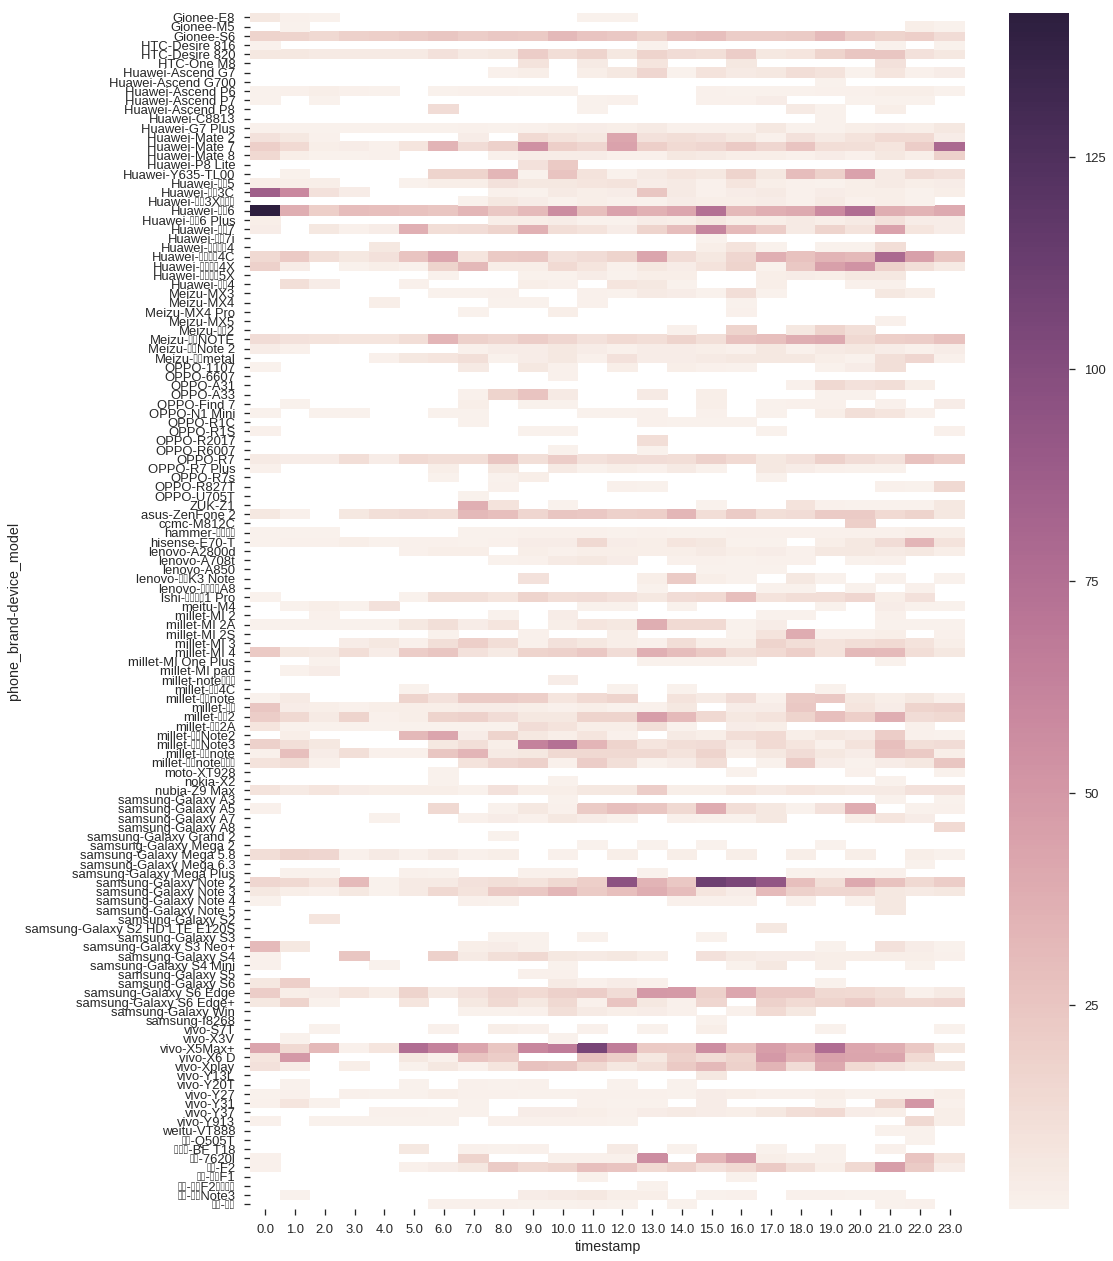

In [171]:
fig, ax = plt.subplots(1, figsize=(16, 22))
sns.heatmap(df.groupby(['phone_brand', 'device_model', df.timestamp.dt.hour])\
              .size()\
              .unstack());

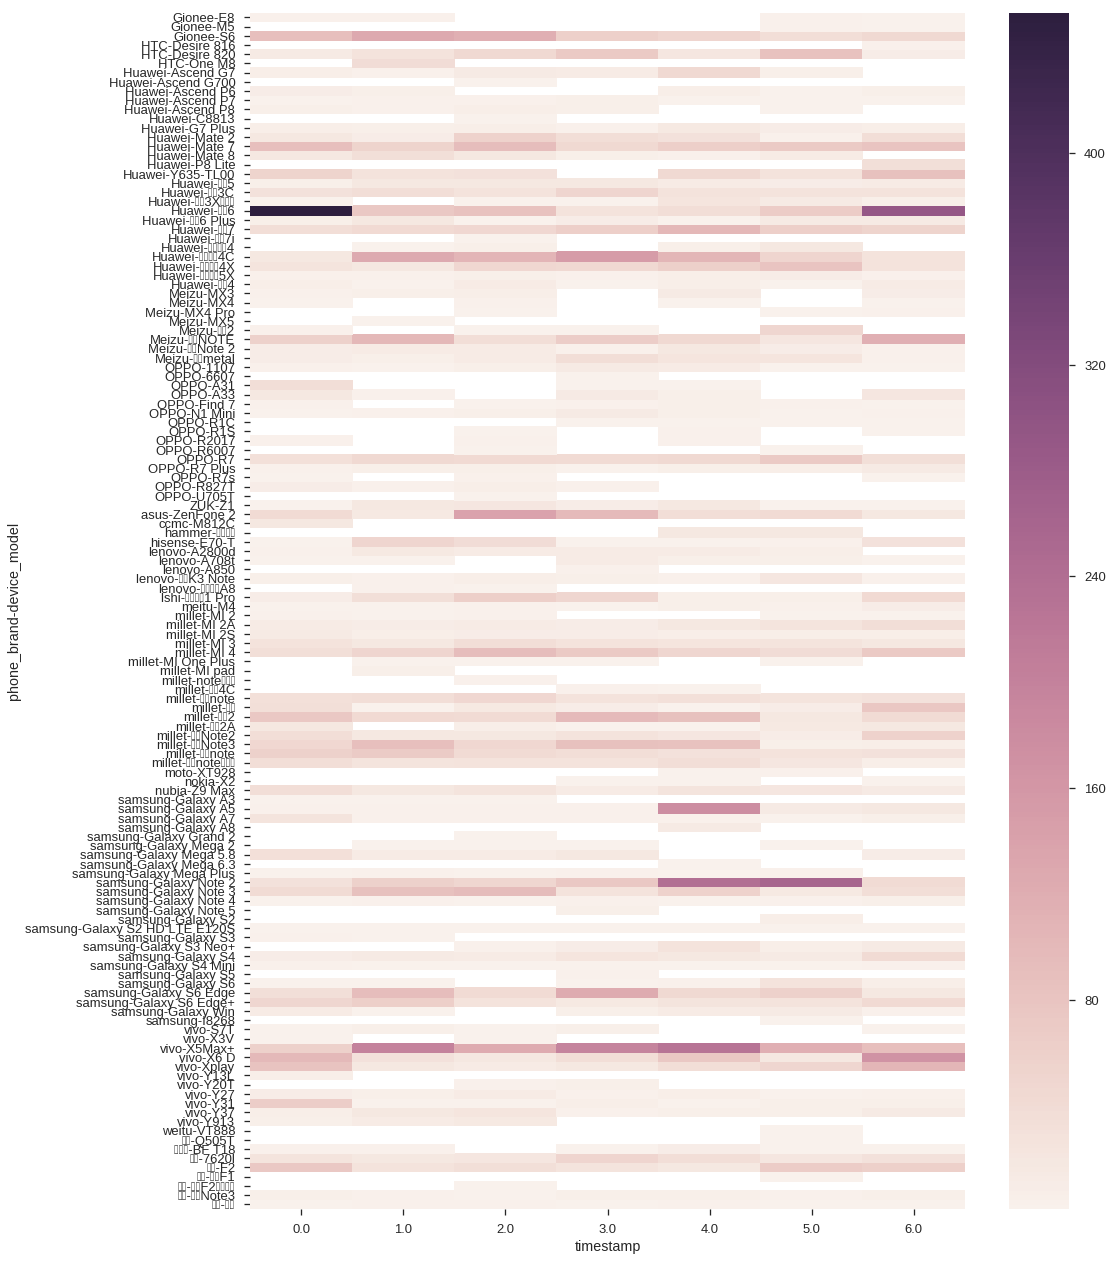

In [172]:
fig, ax = plt.subplots(1, figsize=(16, 22))
sns.heatmap(df.groupby(['phone_brand', 'device_model', df.timestamp.dt.weekday])\
              .size()\
              .unstack());

#### Phone Brand, Device Model and Location

In [173]:
%%time

df =  gender_age_train.sample(n=1000).merge(events, on='device_id', how='left')\
                                    .merge(phone_brand_device_model, on='device_id', how='left')
    
df.loc[:, 'phone_brand'] = df.phone_brand.map(lambda x: chinese_to_eng_brands[x] if x in chinese_to_eng_brands else x)
print(df.head())

            device_id gender  age   group   event_id           timestamp  \
0 -405991589162244751      F   21    F23-  2049418.0 2016-05-05 10:48:51   
1 -405991589162244751      F   21    F23-  2823691.0 2016-05-05 08:36:14   
2 -405991589162244751      F   21    F23-  2937455.0 2016-05-05 09:54:28   
3 -936839570929319409      M   33  M32-38    21323.0 2016-05-01 19:27:54   
4 -936839570929319409      M   33  M32-38    27583.0 2016-05-01 23:44:48   

   longitude  latitude phone_brand device_model  
0        0.0       0.0     samsung    Galaxy S5  
1        0.0       0.0     samsung    Galaxy S5  
2        0.0       0.0     samsung    Galaxy S5  
3        0.0       0.0      Huawei    Ascend P8  
4        0.0       0.0      Huawei    Ascend P8  
CPU times: user 331 ms, sys: 59.2 ms, total: 390 ms
Wall time: 720 ms


In [177]:
# number of occurences of ( brand, device ) pair from different unique locations.
df.groupby(['phone_brand', 'device_model'])\
  .apply(lambda x: x.loc[(x.longitude.notnull()) & (x.latitude.notnull()),
                        ['longitude', 'latitude']].drop_duplicates().shape[0])\
    .sort_values(ascending=False)

phone_brand  device_model          
OPPO         A31                       81
Huawei       荣耀6                       53
millet       红米note                    45
oneplus      X                         44
millet       MI 4                      37
Huawei       Mate 7                    27
OPPO         R7                        20
Meizu        魅蓝                        15
Huawei       Ascend P8                 15
             荣耀7                       14
samsung      Galaxy Grand 2            14
             Galaxy Note 5             12
OPPO         R7 Plus                   12
ccmc         N1                        11
millet       MI 2S                     10
samsung      Galaxy S4                 10
Meizu        魅蓝Note 2                  10
millet       MI 3                       9
Huawei       麦芒4                        9
millet       小米note                     9
OPPO         R1C                        9
Meizu        MX5                        8
vivo         X3L                        

#### Phone Brand, Device Model and is_active

In [180]:
%%time

df =  gender_age_train.sample(n=1000).merge(events, on='device_id', how='left')\
                                    .merge(app_events, on='event_id', how='left')\
                                    .merge(phone_brand_device_model, on='device_id', how='left')
    
df.loc[:, 'phone_brand'] = df.phone_brand.map(lambda x: chinese_to_eng_brands[x] if x in chinese_to_eng_brands else x)
print(df.head())

             device_id gender  age   group event_id           timestamp  \
0 -7887639028356124140      M   34  M32-38    23437 2016-05-03 20:36:14   
1 -7887639028356124140      M   34  M32-38    23437 2016-05-03 20:36:14   
2 -7887639028356124140      M   34  M32-38    23437 2016-05-03 20:36:14   
3 -7887639028356124140      M   34  M32-38    23437 2016-05-03 20:36:14   
4 -7887639028356124140      M   34  M32-38    23437 2016-05-03 20:36:14   

   longitude  latitude        app_id  is_active phone_brand device_model  
0        0.0       0.0  7.875773e+18        0.0        OPPO      R7 Plus  
1        0.0       0.0  8.483751e+18        0.0        OPPO      R7 Plus  
2        0.0       0.0 -7.054805e+18        0.0        OPPO      R7 Plus  
3        0.0       0.0  5.927333e+18        1.0        OPPO      R7 Plus  
4        0.0       0.0  7.316250e+18        0.0        OPPO      R7 Plus  
CPU times: user 3.79 s, sys: 1.21 s, total: 5 s
Wall time: 4.99 s


In [182]:
df.groupby(['phone_brand', 'device_model']).agg({'is_active': [len, np.mean]})

is_active          
                                len      mean
phone_brand device_model                     
Gionee      E5                  1.0       NaN
            E6                275.0  0.175510
            ELIFE E3T           1.0       NaN
            ELIFE S5.5          1.0       NaN
            F103S               1.0       NaN
            GN151               1.0       NaN
            GN152               1.0       NaN
            GN700W              1.0       NaN
            GN708T              1.0       NaN
            S5.1Pro             1.0       NaN
            S5.5L               2.0       NaN
            S7                  1.0       NaN
            V188S               1.0       NaN
            X817                1.0       NaN
            天鉴W900           1218.0  0.455534
HTC         606w                1.0       NaN
            D516w               1.0       NaN
            Desire 626        309.0  0.834416
            Desire 816          5.0       NaN
            Desire 820        304.0  0.733607
            One                 1.0       NaN
            One M8 Eye          1.0       NaN
            One max             1.0       NaN
            T528d               1.0       NaN
Huawei      A199                1.0       NaN
            Ascend G7         131.0  0.404494
            Ascend P6           6.0       NaN
            Ascend P7         351.0  0.444126
            Ascend P8         325.0  0.056075
            B199                2.0       NaN
...                             ...       ...
原点          Yuandian II      1016.0  0.125984
奇酷          青春版               138.0  0.300000
索尼          Xperia P            1.0       NaN
            Xperia S            2.0       NaN
            Xperia Z            1.0       NaN
            Xperia Z3         422.0  0.079755
            Xperia acro S       1.0       NaN
诺亚信         M15                 1.0       NaN
酷比          S1                  1.0       NaN
酷派          5311                1.0       NaN
            5950                2.0       NaN
            5956                1.0       NaN
            7270-W00            1.0       NaN
            7296                1.0       NaN
            7620l               1.0       NaN
            8089                2.0       NaN
            8105                1.0       NaN
            8702                1.0       NaN
            8712                2.0       NaN
            8720L               2.0       NaN
            8730L               1.0       NaN
            9190l               1.0       NaN
            F2               5288.0  0.675557
            T1                  1.0       NaN
            大神F1                4.0       NaN
            大神F1Plus          227.0  0.269058
            大神X7               66.0  0.384615
            炫影S+              131.0  0.968421
            锋尚                 36.0  0.789474
青葱          metal 标准版           1.0       NaN

[328 rows x 2 columns]

#### Phone Brand, Device Model and App Category

In [183]:
%%time

df =  gender_age_train.sample(n=1000).merge(events, on='device_id', how='left')\
                                    .merge(app_events, on='event_id', how='left')\
                                    .merge(app_labels, on='app_id', how='left')\
                                    .merge(label_categories, on='label_id', how='left')\
                                    .merge(phone_brand_device_model, on='device_id', how='left')

df.loc[:, 'phone_brand'] = df.phone_brand.map(lambda x: chinese_to_eng_brands[x] if x in chinese_to_eng_brands else x)
print(df.head())

             device_id gender  age   group event_id           timestamp  \
0  5253044428747042486      M   30  M29-31    46272 2016-05-07 13:56:04   
1  5253044428747042486      M   30  M29-31   107145 2016-05-07 20:50:59   
2  5253044428747042486      M   30  M29-31   214915 2016-05-06 23:13:26   
3  5253044428747042486      M   30  M29-31   236088 2016-05-02 21:10:40   
4  5253044428747042486      M   30  M29-31   387326 2016-05-02 21:01:01   

   longitude  latitude app_id  is_active label_id category phone_brand  \
0     116.51     37.34    NaN        NaN      NaN      NaN      Huawei   
1     116.26     37.45    NaN        NaN      NaN      NaN      Huawei   
2     116.26     37.45    NaN        NaN      NaN      NaN      Huawei   
3     116.26     37.45    NaN        NaN      NaN      NaN      Huawei   
4     116.26     37.45    NaN        NaN      NaN      NaN      Huawei   

  device_model  
0    荣耀畅玩4C运动版  
1    荣耀畅玩4C运动版  
2    荣耀畅玩4C运动版  
3    荣耀畅玩4C运动版  
4    荣耀畅玩4C运动版  
CP

In [184]:
df.groupby(['phone_brand', 'device_model', 'category']).size()

phone_brand  device_model  category              
Gionee       S6            Debit and credit            6
                           Industry tag               19
                           Property Industry 2.0      19
                           Services 1                 19
                           Technology Information     19
                           Wealth Management           6
Huawei       Mate 7        1 free                      4
                           Industry tag                4
                           Lottery ticket             21
                           Property Industry 2.0       4
                           video                       4
             荣耀3X畅玩版       Industry tag                1
                           Integrated Living           1
                           Property Industry 1.0       1
             荣耀4A          Customized 1               10
                           Entertainment News         10
                           Industry ta

#### Phone Brand, Event and App

In [268]:
%%time

df =  gender_age_train.sample(n=1000).merge(events, on='device_id', how='left')\
                                    .merge(app_events, on='event_id', how='left')\
                                    .merge(app_labels, on='app_id', how='left')\
                                    .merge(label_categories, on='label_id', how='left')\
                                    .merge(phone_brand_device_model, on='device_id', how='left')

df.loc[:, 'phone_brand'] = df.phone_brand.map(lambda x: chinese_to_eng_brands[x] if x in chinese_to_eng_brands else x)
print(df.head())

             device_id gender  age   group event_id           timestamp  \
0 -4634537454854131457      M   23  M23-26      NaN                 NaT   
1 -3968498668112416067      F   31  F29-32   414520 2016-05-07 02:45:06   
2 -3968498668112416067      F   31  F29-32   414520 2016-05-07 02:45:06   
3 -3968498668112416067      F   31  F29-32   414520 2016-05-07 02:45:06   
4 -3968498668112416067      F   31  F29-32   414520 2016-05-07 02:45:06   

   longitude  latitude       app_id  is_active label_id category phone_brand  \
0        NaN       NaN          NaN        NaN      NaN      NaN        ccmc   
1        0.0       0.0 -1.63394e+18        1.0      NaN      NaN         TCL   
2        0.0       0.0   8.5572e+18        1.0      NaN      NaN         TCL   
3        0.0       0.0  6.28021e+17        1.0      NaN      NaN         TCL   
4        0.0       0.0  4.34866e+18        1.0      NaN      NaN         TCL   

  device_model  
0           N1  
1        P301M  
2        P301M  


In [270]:
df.groupby(['phone_brand', 'app_id']).apply(lambda x: x['event_id'].nunique()).unstack()

app_id,-9.216716044975228e+18,-9.208020732558901e+18,-9.192350788745386e+18,-9.189021095742738e+18,-9.157896500576238e+18,-9.150010189650053e+18,-9.144671104677662e+18,-9.142957261685295e+18,-9.122065505742321e+18,-9.112833041775557e+18,...,9.175005479893042e+18,9.179306218221578e+18,9.181958182704051e+18,9.18215508525203e+18,9.19128177547467e+18,9.191281777812605e+18,9.204646306216742e+18,9.211954271534258e+18,9.217386935599579e+18,9.220205176760015e+18
phone_brand,,,,,,,,,,,,,,,,,,,,,
Gionee,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
HTC,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,17.0,NaN,NaN
Huawei,56.0,43.0,7.0,NaN,8.0,NaN,NaN,37.0,14.0,NaN,...,NaN,NaN,3.0,NaN,NaN,13.0,5.0,NaN,NaN,80.0
LG,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,NaN
Lovme,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Meizu,NaN,2.0,NaN,10.0,NaN,NaN,NaN,NaN,7.0,21.0,...,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN
OPPO,NaN,NaN,NaN,NaN,2.0,1.0,NaN,1.0,3.0,NaN,...,NaN,NaN,NaN,NaN,8.0,7.0,NaN,NaN,NaN,NaN
TCL,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ZUK,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#### Phone Brand, Event and Timestamp

In [266]:
%%time

df =  gender_age_train.sample(n=1000).merge(events, on='device_id', how='left')\
                                    .merge(app_events, on='event_id', how='left')\
                                    .merge(app_labels, on='app_id', how='left')\
                                    .merge(label_categories, on='label_id', how='left')\
                                    .merge(phone_brand_device_model, on='device_id', how='left')

df.loc[:, 'phone_brand'] = df.phone_brand.map(lambda x: chinese_to_eng_brands[x] if x in chinese_to_eng_brands else x)
print(df.head())

             device_id gender  age   group event_id timestamp  longitude  \
0 -7661835877950598911      M   32  M32-38      NaN       NaT        NaN   
1 -3041322562203158087      M   33  M32-38      NaN       NaT        NaN   
2  3150742261138559754      F   33  F33-42      NaN       NaT        NaN   
3 -1134248692466464463      M   28  M27-28      NaN       NaT        NaN   
4  1315311411534613808      M   35  M32-38      NaN       NaT        NaN   

   latitude app_id  is_active label_id category phone_brand    device_model  
0       NaN    NaN        NaN      NaN      NaN     samsung       Galaxy S4  
1       NaN    NaN        NaN      NaN      NaN      lenovo            A820  
2       NaN    NaN        NaN      NaN      NaN      millet            MI 3  
3       NaN    NaN        NaN      NaN      NaN     samsung  Galaxy S3 Neo+  
4       NaN    NaN        NaN      NaN      NaN      millet          MI pad  
CPU times: user 4.18 s, sys: 1.13 s, total: 5.31 s
Wall time: 5.31 s


In [267]:
df.groupby(['phone_brand', df.timestamp.dt.hour]).apply(lambda x: x['event_id'].nunique())

phone_brand  timestamp
Gionee       7.0           10
             8.0           10
             14.0           1
             17.0           2
             21.0           1
HTC          11.0           1
             13.0           2
             15.0          14
             16.0           4
             21.0           1
Huawei       0.0          197
             1.0          111
             2.0           77
             3.0           64
             4.0           90
             5.0           76
             6.0          156
             7.0          215
             8.0          200
             9.0          261
             10.0         295
             11.0         286
             12.0         293
             13.0         243
             14.0         206
             15.0         246
             16.0         274
             17.0         291
             18.0         260
             19.0         311
                         ... 
索尼           14.0           1
             16.0

In [271]:
df.groupby(['phone_brand', df.timestamp.dt.weekday]).apply(lambda x: x['event_id'].nunique())

phone_brand  timestamp
Gionee       0.0             4
             1.0            17
             2.0             1
             3.0             5
             5.0             4
             6.0            16
HTC          0.0            38
             1.0            48
             2.0            76
             3.0            30
             4.0            19
             5.0            46
             6.0            38
Huawei       0.0          1077
             1.0           910
             2.0          1319
             3.0           724
             4.0           817
             5.0           778
             6.0          1050
LG           0.0             1
             1.0             4
             2.0             1
             3.0             2
             4.0             4
             5.0             1
             6.0             4
Lovme        1.0             1
             3.0             1
             4.0             1
                          ... 
samsung      2.0

#### Phone Brand, Event and Location

In [272]:
%%time

df =  gender_age_train.sample(n=1000).merge(events, on='device_id', how='left')\
                                    .merge(app_events, on='event_id', how='left')\
                                    .merge(app_labels, on='app_id', how='left')\
                                    .merge(label_categories, on='label_id', how='left')\
                                    .merge(phone_brand_device_model, on='device_id', how='left')

df.loc[:, 'phone_brand'] = df.phone_brand.map(lambda x: chinese_to_eng_brands[x] if x in chinese_to_eng_brands else x)
print(df.head())

             device_id gender  age   group event_id           timestamp  \
0  8741840491065986466      M   22    M22-      NaN                 NaT   
1 -7243629863851316279      M   20    M22-      NaN                 NaT   
2  -626870753629386975      M   35  M32-38      NaN                 NaT   
3  4051948158699891861      F   34  F33-42   542660 2016-05-01 06:26:15   
4  4051948158699891861      F   34  F33-42   542660 2016-05-01 06:26:15   

   longitude  latitude       app_id  is_active label_id category phone_brand  \
0        NaN       NaN          NaN        NaN      NaN      NaN     samsung   
1        NaN       NaN          NaN        NaN      NaN      NaN       Meizu   
2        NaN       NaN          NaN        NaN      NaN      NaN      lenovo   
3        0.0       0.0  -7.9378e+18        1.0      NaN      NaN     samsung   
4        0.0       0.0  7.19379e+18        0.0      NaN      NaN     samsung   

    device_model  
0      Galaxy S4  
1       魅蓝Note 2  
2          

In [274]:
df.groupby(['phone_brand', df.longitude.astype('str') + '_' + df.latitude.astype('str')])\
  .apply(lambda x: x['event_id'].nunique())

phone_brand              
Gionee       0.0_0.0          29
             1.0_1.0          48
             113.35_40.09      2
             113.35_40.1       2
             113.36_40.1       7
             115.48_26.26      5
             117.0_39.4        1
             119.98_29.31      2
             120.21_30.29      2
             120.34_30.22      2
             120.34_30.23      2
             120.3_30.21       4
             120.3_30.22       1
             120.44_29.04      4
             nan_nan           0
HTC          0.0_0.0           3
             120.23_31.56     10
             nan_nan           0
Huawei       0.0_0.0         911
             103.93_30.59      9
             103.95_30.6       1
             104.13_36.54      1
             106.28_36.01     10
             106.3_36.02       2
             106.6_29.42      12
             106.91_32.96     17
             106.9_32.95       3
             107.02_33.06      5
             107.05_33.08     12
             107.

#### Phone Brand, Event and is_active

In [275]:
%%time

df =  gender_age_train.sample(n=1000).merge(events, on='device_id', how='left')\
                                    .merge(app_events, on='event_id', how='left')\
                                    .merge(app_labels, on='app_id', how='left')\
                                    .merge(label_categories, on='label_id', how='left')\
                                    .merge(phone_brand_device_model, on='device_id', how='left')

df.loc[:, 'phone_brand'] = df.phone_brand.map(lambda x: chinese_to_eng_brands[x] if x in chinese_to_eng_brands else x)
print(df.head())

             device_id gender  age group event_id           timestamp  \
0  5933162473709684431      F   48  F43+     3643 2016-05-01 06:10:50   
1  5933162473709684431      F   48  F43+     3643 2016-05-01 06:10:50   
2  5933162473709684431      F   48  F43+     3643 2016-05-01 06:10:50   
3  5933162473709684431      F   48  F43+     3643 2016-05-01 06:10:50   
4  5933162473709684431      F   48  F43+     3643 2016-05-01 06:10:50   

   longitude  latitude       app_id  is_active label_id category phone_brand  \
0        0.0       0.0  4.30799e+18        1.0      NaN      NaN       Meizu   
1        0.0       0.0 -6.48627e+18        1.0      NaN      NaN       Meizu   
2        0.0       0.0  6.66657e+18        1.0      NaN      NaN       Meizu   
3        0.0       0.0  5.92733e+18        1.0      NaN      NaN       Meizu   
4        0.0       0.0 -8.44639e+18        1.0      NaN      NaN       Meizu   

  device_model  
0       魅蓝NOTE  
1       魅蓝NOTE  
2       魅蓝NOTE  
3       魅蓝NO

In [276]:
df.groupby(['phone_brand', 'is_active']).apply(lambda x: x['event_id'].nunique())

phone_brand  is_active
Gionee       0.0            30
             1.0           139
HTC          0.0             2
             1.0             5
Huawei       0.0           421
             1.0          1357
Ktouch       0.0             8
             1.0            40
Meizu        0.0           549
             1.0          1376
OPPO         0.0           224
             1.0           681
TCL          0.0            91
             1.0           299
ZUK          0.0            53
             1.0           114
ada          0.0             3
             1.0             3
asus         0.0             1
             1.0             1
ccmc         0.0            35
             1.0            50
dowe         0.0             7
             1.0            70
epai         0.0             1
             1.0             2
hammer       0.0             8
             1.0            24
hisense      0.0            10
             1.0           106
                          ... 
lenovo       0.0

#### Phone Brand, Event and app category

How many different events were generated by (Brand, Category) combination ?

In [280]:
%%time

df =  gender_age_train.sample(n=1000).merge(events, on='device_id', how='left')\
                                    .merge(app_events, on='event_id', how='left')\
                                    .merge(app_labels, on='app_id', how='left')\
                                    .merge(label_categories, on='label_id', how='left')\
                                    .merge(phone_brand_device_model, on='device_id', how='left')

df.loc[:, 'phone_brand'] = df.phone_brand.map(lambda x: chinese_to_eng_brands[x] if x in chinese_to_eng_brands else x)
print(df.head())

             device_id gender  age   group event_id           timestamp  \
0  -986324923376566781      M   29  M29-31      NaN                 NaT   
1  9208734509211048541      F   30  F29-32      NaN                 NaT   
2  -556455237919769238      F   23    F23-      NaN                 NaT   
3 -1625278187541145628      M   46    M39+    15723 2016-05-07 14:50:41   
4 -1625278187541145628      M   46    M39+    22856 2016-05-07 19:33:12   

   longitude  latitude app_id  is_active label_id category phone_brand  \
0        NaN       NaN    NaN        NaN      NaN      NaN          中兴   
1        NaN       NaN    NaN        NaN      NaN      NaN      millet   
2        NaN       NaN    NaN        NaN      NaN      NaN     samsung   
3     111.75     29.64    NaN        NaN      NaN      NaN        vivo   
4     111.75     29.64    NaN        NaN      NaN      NaN        vivo   

   device_model  
0         Q802T  
1         MI 2S  
2  Galaxy Grand  
3           X5V  
4           X5

In [281]:
df.groupby(['phone_brand', 'category']).apply(lambda x: x['event_id'].nunique())

phone_brand  category                  
Gionee       Debit and credit               41
             Wealth Management              41
Huawei       1 free                         16
             Air Travel                      2
             And the Church                111
             Consumer Finance                2
             Custom label                  111
             Customized 1                    2
             Debit and credit              111
             Domestic travel                 2
             Entertainment News              2
             Express                         9
             Financial Services            111
             Free exercise                   2
             High risk                     111
             Higher income                 111
             Hotel Type                      2
             Hotels                          2
             Industry tag                   69
             Integrated Living              11
             Interne

#### Phone Brand, Timestamp and Location

In [185]:
%%time

df =  gender_age_train.sample(n=1000).merge(events, on='device_id', how='left')\
                                    .merge(phone_brand_device_model, on='device_id', how='left')
    
df.loc[:, 'phone_brand'] = df.phone_brand.map(lambda x: chinese_to_eng_brands[x] if x in chinese_to_eng_brands else x)
print(df.head())

             device_id gender  age   group   event_id           timestamp  \
0  9182042777070348235      M   22    M22-        NaN                 NaT   
1  2411754717797554467      F   28  F27-28   802619.0 2016-05-01 22:42:59   
2  2411754717797554467      F   28  F27-28  1258587.0 2016-05-02 17:04:02   
3  2411754717797554467      F   28  F27-28  1484995.0 2016-05-02 19:24:41   
4  2411754717797554467      F   28  F27-28  1557430.0 2016-05-03 20:35:45   

   longitude  latitude phone_brand device_model  
0        NaN       NaN          索尼     Xperia Z  
1        0.0       0.0          酷派           锋尚  
2        0.0       0.0          酷派           锋尚  
3        0.0       0.0          酷派           锋尚  
4        0.0       0.0          酷派           锋尚  
CPU times: user 289 ms, sys: 91.8 ms, total: 380 ms
Wall time: 382 ms


In [188]:
df.groupby(['phone_brand', df.timestamp.dt.hour, df.longitude.astype('str') + '_' + df.latitude.astype('str')])\
  .size()\
    .reset_index()

,phone_brand,timestamp,level_2,0
0,Gionee,0.0,120.18_30.34,2
1,Gionee,1.0,120.18_30.34,2
2,Gionee,3.0,120.18_30.34,2
3,Gionee,4.0,120.18_30.34,3
4,Gionee,5.0,0.0_0.0,1
5,Gionee,5.0,120.18_30.34,17
6,Gionee,5.0,120.19_30.33,1
7,Gionee,5.0,120.21_30.34,2
8,Gionee,5.0,120.23_30.35,1
9,Gionee,5.0,120.23_30.36,1


#### Phone Brand, Timestamp, is_active

In [191]:
%%time

df =  gender_age_train.sample(n=1000).merge(events, on='device_id', how='left')\
                                    .merge(app_events, on='event_id', how='left')\
                                    .merge(phone_brand_device_model, on='device_id', how='left')
    
df.loc[:, 'phone_brand'] = df.phone_brand.map(lambda x: chinese_to_eng_brands[x] if x in chinese_to_eng_brands else x)
print(df.head())

             device_id gender  age   group event_id timestamp  longitude  \
0 -3140653388192798818      F   31  F29-32      NaN       NaT        NaN   
1  2590012858613679980      F   28  F27-28      NaN       NaT        NaN   
2 -2104287812192478219      M   29  M29-31      NaN       NaT        NaN   
3  8649155696936361371      M   33  M32-38      NaN       NaT        NaN   
4  7879777237022921147      M   37  M32-38      NaN       NaT        NaN   

   latitude  app_id  is_active phone_brand    device_model  
0       NaN     NaN        NaN      millet            MI 3  
1       NaN     NaN        NaN        vivo            X5SL  
2       NaN     NaN        NaN       Meizu          魅蓝NOTE  
3       NaN     NaN        NaN      Huawei             荣耀6  
4       NaN     NaN        NaN     samsung  Galaxy S3 Mini  
CPU times: user 3.7 s, sys: 1.17 s, total: 4.87 s
Wall time: 4.89 s


In [193]:
df.groupby(['phone_brand', df.timestamp.dt.hour])\
  .agg({'is_active': [len, np.mean]})

is_active          
                            len      mean
phone_brand timestamp                    
Gionee      0.0            53.0  0.489796
            7.0            66.0  0.068966
            8.0            68.0  0.129032
            12.0           23.0  0.260870
            13.0            6.0  1.000000
            20.0           30.0  0.533333
Huawei      0.0          2102.0  0.252212
            1.0          1148.0  0.273415
            2.0           533.0  0.403326
            3.0           408.0  0.401084
            4.0           398.0  0.478754
            5.0          1005.0  0.363235
            6.0          1753.0  0.354584
            7.0          1944.0  0.409574
            8.0          2651.0  0.345065
            9.0          3499.0  0.329486
            10.0         2773.0  0.384987
            11.0         4466.0  0.306821
            12.0         3230.0  0.315721
            13.0         3163.0  0.343822
            14.0         1888.0  0.454397
            15.0         2755.0  0.351064
            16.0         2738.0  0.420677
            17.0         2033.0  0.408975
            18.0         3140.0  0.397247
            19.0         2615.0  0.432313
            20.0         2471.0  0.478205
            21.0         2129.0  0.531420
            22.0         2276.0  0.466604
            23.0         1798.0  0.442662
...                         ...       ...
索尼          18.0           12.0  1.000000
            19.0           17.0  1.000000
            20.0            9.0  1.000000
            21.0           11.0  1.000000
            22.0           30.0  1.000000
            23.0           30.0  1.000000
酷派          0.0           266.0  0.293893
            1.0           250.0  0.168000
            2.0           167.0  0.339394
            3.0            66.0  0.272727
            4.0             8.0  1.000000
            5.0           131.0  0.225806
            6.0           842.0  0.162673
            7.0           664.0  0.196232
            8.0           625.0  0.352941
            9.0           316.0  0.224265
            10.0          432.0  0.234867
            11.0          313.0  0.211409
            12.0          113.0  0.807018
            13.0          197.0  0.276243
            14.0          195.0  0.458599
            15.0          196.0  0.620438
            16.0          154.0  0.895833
            17.0          356.0  0.523132
            18.0          464.0  0.407767
            19.0          499.0  0.412993
            20.0          251.0  0.489011
            21.0          361.0  0.486207
            22.0          311.0  0.597173
            23.0          143.0  0.354610

[376 rows x 2 columns]

#### Phone Brand, Timestamp, App Category

In [194]:
%%time

df =  gender_age_train.sample(n=1000).merge(events, on='device_id', how='left')\
                                     .merge(app_events, on='event_id', how='left')\
                                     .merge(app_labels, on='app_id', how='left')\
                                     .merge(label_categories, on='label_id', how='left')\
                                     .merge(phone_brand_device_model, on='device_id', how='left')

df.loc[:, 'phone_brand'] = df.phone_brand.map(lambda x: chinese_to_eng_brands[x] if x in chinese_to_eng_brands else x)
print(df.head())

             device_id gender  age group event_id           timestamp  \
0 -3707004850175710149      F   21  F23-   106264 2016-05-04 16:01:36   
1 -3707004850175710149      F   21  F23-   106264 2016-05-04 16:01:36   
2 -3707004850175710149      F   21  F23-   106264 2016-05-04 16:01:36   
3 -3707004850175710149      F   21  F23-   106264 2016-05-04 16:01:36   
4 -3707004850175710149      F   21  F23-   106264 2016-05-04 16:01:36   

   longitude  latitude       app_id  is_active label_id category phone_brand  \
0     113.03     28.17  2.33024e+18        0.0      NaN      NaN      Huawei   
1     113.03     28.17 -5.72008e+18        0.0      NaN      NaN      Huawei   
2     113.03     28.17  5.92733e+18        0.0      NaN      NaN      Huawei   
3     113.03     28.17 -6.53184e+17        0.0      NaN      NaN      Huawei   
4     113.03     28.17 -6.12384e+18        0.0      NaN      NaN      Huawei   

  device_model  
0    Ascend P7  
1    Ascend P7  
2    Ascend P7  
3    Ascend 

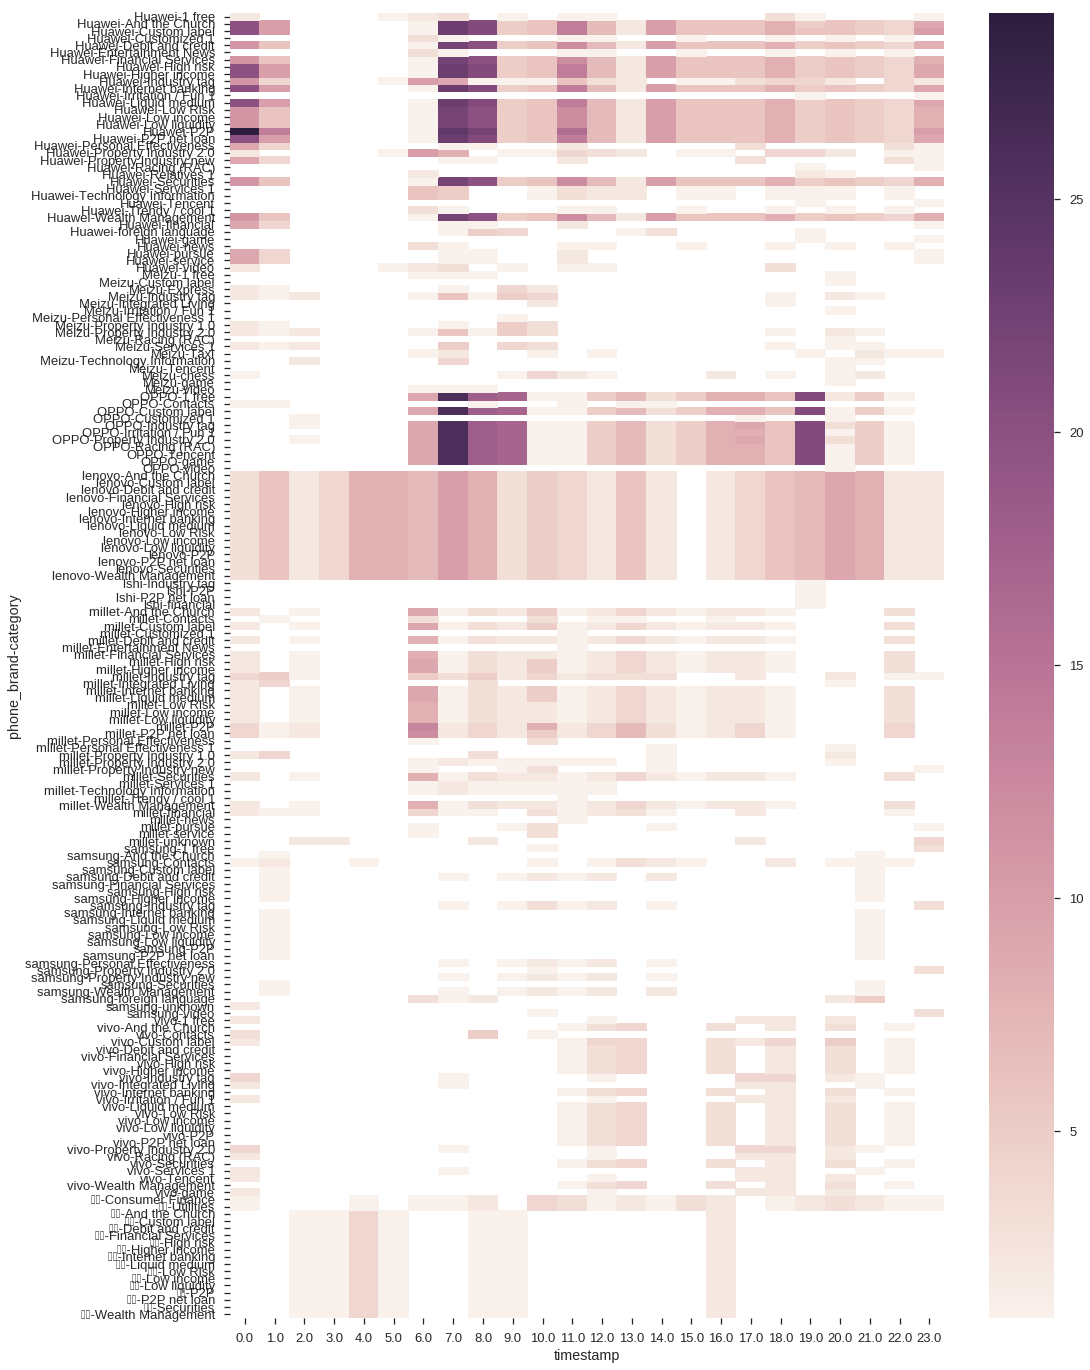

In [202]:
fig, ax = plt.subplots(1, figsize=(16, 24))

sns.heatmap(df.groupby(['phone_brand', df.timestamp.dt.hour, 'category'])\
              .size()\
                .unstack(1));

#### Device Model, Event and App

#### Device Model, Event and Timestamp

#### Device Model, Event and Location

#### Device Model, Event and is_active

#### Device Model, Event and Category

#### Device Model, Timestamp and Location

In [213]:
%%time

df =  gender_age_train.sample(n=1000).merge(events, on='device_id', how='left')\
                                    .merge(phone_brand_device_model, on='device_id', how='left')
    
df.loc[:, 'phone_brand'] = df.phone_brand.map(lambda x: chinese_to_eng_brands[x] if x in chinese_to_eng_brands else x)
print(df.head())

             device_id gender  age   group  event_id timestamp  longitude  \
0  1648267681318915257      M   50    M39+       NaN       NaT        NaN   
1 -4014552508992068616      M   22    M22-       NaN       NaT        NaN   
2  8040454667610288518      F   41  F33-42       NaN       NaT        NaN   
3  3648078116872826038      F   48    F43+       NaN       NaT        NaN   
4 -1818406219967651139      M   24  M23-26       NaN       NaT        NaN   

   latitude phone_brand           device_model  
0       NaN      Huawei                 Mate 7  
1       NaN      millet                  MI 2S  
2       NaN     samsung  Galaxy Grand Neo Plus  
3       NaN     samsung          Galaxy Note 2  
4       NaN     samsung          Galaxy Note 2  
CPU times: user 360 ms, sys: 79.9 ms, total: 440 ms
Wall time: 440 ms


In [206]:
df.groupby(['device_model', df.timestamp.dt.hour, df.longitude.astype('str') + '_' + df.latitude.astype('str')])\
  .size().sort_values(ascending=False).iloc[:10]

device_model  timestamp              
Y17T          11.0       120.6_30.29     79
              17.0       120.59_30.3     70
荣耀畅玩4X        22.0       116.51_39.82    70
Y17T          8.0        120.6_30.29     66
红米Note2       15.0       111.87_29.63    66
荣耀6           22.0       118.72_25.34    62
荣耀畅玩4X        21.0       116.51_39.82    61
红米2           18.0       113.28_23.08    60
超级手机1 Pro     12.0       111.79_36.86    60
A33           22.0       117.64_35.84    59
dtype: int64

In [209]:
df.groupby(['device_model', df.timestamp.dt.hour])\
  .apply(lambda x: (x['longitude'].astype(np.str) + '_' + x['latitude'].astype(np.str)).nunique())\
    .sort_values(ascending=False).iloc[:10]

device_model  timestamp
红米Note3       21.0         40
              22.0         37
              0.0          19
              23.0         19
荣耀畅玩4X        10.0         18
              9.0          16
Y27           18.0         15
畅享5S          10.0         15
MI 4          20.0         15
Y27           11.0         15
dtype: int64

In [214]:
df.groupby(['device_model', df.timestamp.dt.weekday, df.longitude.astype('str') + '_' + df.latitude.astype('str')])\
  .size().sort_values(ascending=False).iloc[:10]

device_model  timestamp              
荣耀畅玩4X        4.0        117.05_30.53    190
              3.0        117.05_30.53    185
              1.0        117.05_30.53    161
              5.0        117.05_30.53    153
MI 3          5.0        114.66_31.47    106
荣耀畅玩5X        6.0        117.82_40.97     98
大神F2          6.0        115.88_28.66     94
Galaxy A5     6.0        115.65_34.37     87
MI 3          4.0        114.66_31.47     83
荣耀畅玩4X        6.0        117.05_30.53     79
dtype: int64

#### Device Model, Timestamp and is_active

In [210]:
%%time

df =  gender_age_train.sample(n=1000).merge(events, on='device_id', how='left')\
                                    .merge(app_events, on='event_id', how='left')\
                                    .merge(phone_brand_device_model, on='device_id', how='left')
    
df.loc[:, 'phone_brand'] = df.phone_brand.map(lambda x: chinese_to_eng_brands[x] if x in chinese_to_eng_brands else x)
print(df.head())

             device_id gender  age   group     event_id           timestamp  \
0 -6332215448424153537      M   24  M23-26  1.62708e+06 2016-05-05 00:25:41   
1 -6332215448424153537      M   24  M23-26  1.62708e+06 2016-05-05 00:25:41   
2 -6332215448424153537      M   24  M23-26  1.62708e+06 2016-05-05 00:25:41   
3 -6332215448424153537      M   24  M23-26  1.62708e+06 2016-05-05 00:25:41   
4 -6332215448424153537      M   24  M23-26  1.62708e+06 2016-05-05 00:25:41   

   longitude  latitude        app_id  is_active phone_brand device_model  
0        0.0       0.0 -7.377004e+18        0.0     samsung    Galaxy S4  
1        0.0       0.0  4.460015e+18        0.0     samsung    Galaxy S4  
2        0.0       0.0  5.927333e+18        1.0     samsung    Galaxy S4  
3        0.0       0.0 -5.720079e+18        0.0     samsung    Galaxy S4  
4        0.0       0.0 -6.590030e+18        0.0     samsung    Galaxy S4  
CPU times: user 3.82 s, sys: 1.22 s, total: 5.05 s
Wall time: 5.04 s


#### Device Model, Timestamp and category

In [284]:
%%time

df =  gender_age_train.sample(n=1000).merge(events, on='device_id', how='left')\
                                    .merge(app_events, on='event_id', how='left')\
                                    .merge(phone_brand_device_model, on='device_id', how='left')\
                                    .merge(app_labels, on='app_id', how='left')\
                                    .merge(label_categories, on='label_id', how='left')
    
df.loc[:, 'phone_brand'] = df.phone_brand.map(lambda x: chinese_to_eng_brands[x] if x in chinese_to_eng_brands else x)
print(df.head())

             device_id gender  age   group     event_id           timestamp  \
0  9089127937118006259      F   26  F24-26          NaN                 NaT   
1   742041945889873850      M   22    M22-       810942 2016-05-04 08:37:57   
2   742041945889873850      M   22    M22-  1.70885e+06 2016-05-04 08:38:09   
3   742041945889873850      M   22    M22-  2.01743e+06 2016-05-04 08:36:51   
4   742041945889873850      M   22    M22-  2.01743e+06 2016-05-04 08:36:51   

   longitude  latitude       app_id  is_active phone_brand device_model  \
0        NaN       NaN          NaN        NaN        OPPO        U705T   
1     116.08      38.8          NaN        NaN      millet       红米note   
2     116.08      38.8          NaN        NaN      millet       红米note   
3     116.08      38.8 -2.73573e+18        0.0      millet       红米note   
4     116.08      38.8 -3.95521e+18        0.0      millet       红米note   

  label_id category  
0      NaN      NaN  
1      NaN      NaN  
2      N

In [286]:
df.groupby(['device_model', df.timestamp.dt.hour, 'category']).size()

device_model  timestamp  category                        
1105          5.0        Health Management                   3
              18.0       Health Management                   1
Ascend P8     8.0        Traditional securities brokerage    1
              16.0       Traditional securities brokerage    2
Galaxy A5     0.0        Industry tag                        4
                         Property Industry 2.0               4
                         Services 1                          4
                         Technology Information              4
              9.0        Industry tag                        4
                         Property Industry 2.0               4
                         Services 1                          4
                         Technology Information              4
              10.0       Industry tag                        4
                         Property Industry 2.0               4
                         Services 1                         

#### Event, Timestamp and Location

In [287]:
%%time

df =  gender_age_train.sample(n=1000).merge(events, on='device_id', how='left')
    
print(df.head())

             device_id gender  age   group  event_id timestamp  longitude  \
0 -6173572283114076926      M   33  M32-38       NaN       NaT        NaN   
1 -8004143411643920739      M   28  M27-28       NaN       NaT        NaN   
2    62117351725736209      M   42    M39+       NaN       NaT        NaN   
3 -4790211255502235360      F   31  F29-32       NaN       NaT        NaN   
4  1558199578565558583      M   43    M39+       NaN       NaT        NaN   

   latitude  
0       NaN  
1       NaN  
2       NaN  
3       NaN  
4       NaN  
CPU times: user 273 ms, sys: 84.2 ms, total: 357 ms
Wall time: 356 ms


In [289]:
df.groupby([df.timestamp.dt.hour, 
            df.longitude.astype(np.str) + '_' + df.latitude.astype(np.str)])['event_id'].nunique()

timestamp              
0.0        0.0_0.0         193
           1.0_1.0           4
           102.2_31.91       4
           103.87_30.63      1
           104.05_30.62      1
           104.05_30.63      1
           104.06_30.59      1
           104.06_30.64      2
           104.06_30.66      2
           104.07_30.61      5
           104.07_30.63      2
           104.08_30.64      1
           104.08_30.65      4
           104.09_30.61      2
           104.09_30.65      1
           104.11_30.62      1
           104.11_30.65      1
           104.17_30.81      1
           104.1_30.63       2
           104.1_30.64       2
           104.39_31.13     15
           106.22_38.48      2
           107.37_29.71      5
           108.98_34.25     33
           109.37_24.28     50
           109.43_36.67     18
           109.53_36.63      2
           110.19_25.25      2
           110.27_25.26      2
           110.29_25.24      5
                          ... 
23.0       116.

In [302]:
weekday_location_nunique_events = df.groupby([df.timestamp.dt.weekday, 
                                              df.longitude.astype(np.str) + '_' + df.latitude.astype(np.str)])\
                                              ['event_id'].nunique().unstack()

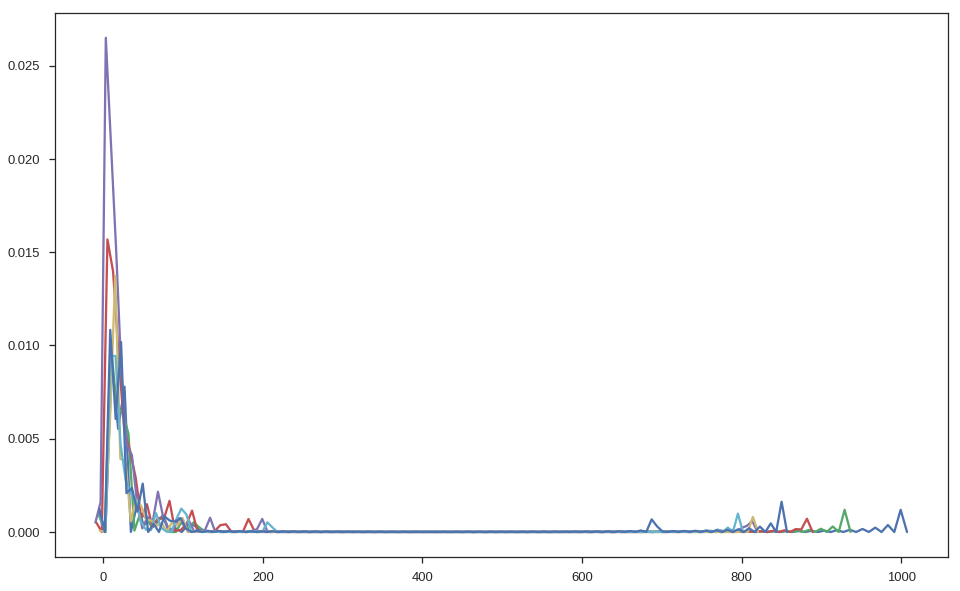

In [304]:
plt.figure(figsize=(16, 10))

sns.kdeplot(weekday_location_nunique_events[weekday_location_nunique_events.index == 0.0].values.flatten())
sns.kdeplot(weekday_location_nunique_events[weekday_location_nunique_events.index == 1.0].values.flatten())
sns.kdeplot(weekday_location_nunique_events[weekday_location_nunique_events.index == 2.0].values.flatten())
sns.kdeplot(weekday_location_nunique_events[weekday_location_nunique_events.index == 3.0].values.flatten())
sns.kdeplot(weekday_location_nunique_events[weekday_location_nunique_events.index == 4.0].values.flatten())
sns.kdeplot(weekday_location_nunique_events[weekday_location_nunique_events.index == 5.0].values.flatten())
sns.kdeplot(weekday_location_nunique_events[weekday_location_nunique_events.index == 6.0].values.flatten());

#### Event, Timestamp and is_active

In [306]:
%%time

df =  gender_age_train.sample(n=1000).merge(events, on='device_id', how='left')\
                                     .merge(app_events, on='event_id', how='left')
    
print(df.head())

             device_id gender  age   group event_id           timestamp  \
0  3599851513972142546      M   23  M23-26      NaN                 NaT   
1  3359586842223076968      M   29  M29-31      NaN                 NaT   
2  1806967116858986425      M   25  M23-26      NaN                 NaT   
3  5472525101691587886      M   20    M22-      NaN                 NaT   
4  -715022761444005018      M   33  M32-38   170677 2016-05-07 23:18:42   

   longitude  latitude        app_id  is_active  
0        NaN       NaN           NaN        NaN  
1        NaN       NaN           NaN        NaN  
2        NaN       NaN           NaN        NaN  
3        NaN       NaN           NaN        NaN  
4     116.41     40.07 -5.380614e+17        1.0  
CPU times: user 3.55 s, sys: 1.22 s, total: 4.77 s
Wall time: 4.78 s


In [311]:
df.groupby([df.timestamp.dt.hour, df.event_id]).agg({'is_active': [len, np.mean]})

is_active          
                          len      mean
timestamp event_id                     
0.0       289.0          64.0  0.109375
          375.0          46.0  0.282609
          491.0          17.0  1.000000
          567.0          31.0  0.290323
          725.0          23.0  0.304348
          889.0           1.0       NaN
          914.0           1.0       NaN
          1016.0         36.0  0.138889
          1470.0          1.0       NaN
          29087.0         1.0       NaN
          29504.0         1.0       NaN
          29618.0        68.0  0.205882
          29720.0         1.0       NaN
          29739.0         1.0       NaN
          29824.0         1.0       NaN
          30532.0         1.0       NaN
          30878.0         1.0       NaN
          63347.0        52.0  0.250000
          63586.0         1.0       NaN
          63671.0         1.0       NaN
          65745.0        65.0  0.030769
          69583.0        42.0  0.333333
          69717.0        57.0  0.385965
          69996.0        63.0  0.031746
          70008.0        67.0  0.358209
          70043.0        11.0  0.181818
          119921.0       23.0  0.086957
          120005.0       17.0  0.352941
          120302.0       65.0  0.246154
          120755.0        1.0       NaN
...                       ...       ...
23.0      3083778.0       1.0       NaN
          3083814.0       1.0       NaN
          3128581.0      14.0  1.000000
          3128680.0      19.0  1.000000
          3128762.0      47.0  0.361702
          3128816.0       1.0       NaN
          3163964.0      39.0  0.051282
          3164472.0       1.0       NaN
          3170101.0      90.0  0.144444
          3172240.0      18.0  0.611111
          3172517.0      31.0  0.354839
          3172563.0      25.0  0.280000
          3172851.0       1.0       NaN
          3192513.0      17.0  1.000000
          3215736.0       1.0       NaN
          3215804.0       7.0  1.000000
          3216100.0      12.0  1.000000
          3216313.0       4.0  1.000000
          3216353.0      24.0  1.000000
          3216520.0       5.0  1.000000
          3219020.0       1.0       NaN
          3219118.0      28.0  0.250000
          3219174.0       1.0       NaN
          3219331.0       1.0       NaN
          3251790.0      32.0  0.375000
          3252144.0       1.0       NaN
          3252203.0       1.0       NaN
          3252440.0       1.0       NaN
          3252630.0      48.0  0.312500
          3252866.0      47.0  0.255319

[14473 rows x 2 columns]

#### Event, Timestamp and category

In [312]:
%%time

df =  gender_age_train.sample(n=1000).merge(events, on='device_id', how='left')\
                                     .merge(app_events, on='event_id', how='left')\
                                     .merge(app_labels, on='app_id', how='left')\
                                     .merge(label_categories, on='label_id', how='left')
    
print(df.head())

             device_id gender  age   group     event_id           timestamp  \
0 -1812157395407697897      M   36  M32-38          NaN                 NaT   
1 -5253791749793212686      M   31  M29-31  1.85336e+06 2016-05-01 13:32:07   
2 -5253791749793212686      M   31  M29-31  1.85336e+06 2016-05-01 13:32:07   
3 -5253791749793212686      M   31  M29-31  1.85336e+06 2016-05-01 13:32:07   
4 -5253791749793212686      M   31  M29-31  1.85336e+06 2016-05-01 13:32:07   

   longitude  latitude       app_id  is_active label_id category  
0        NaN       NaN          NaN        NaN      NaN      NaN  
1        0.0       0.0  5.92733e+18        0.0      NaN      NaN  
2        0.0       0.0 -6.90752e+17        0.0      NaN      NaN  
3        0.0       0.0 -5.72008e+18        0.0      NaN      NaN  
4        0.0       0.0  7.58245e+17        1.0      NaN      NaN  
CPU times: user 3.79 s, sys: 1.17 s, total: 4.97 s
Wall time: 4.97 s


In [314]:
df.groupby([df.event_id, df.timestamp.dt.hour, 'category']).size().sort_values(ascending=False)

event_id   timestamp  category               
3137611.0  8.0        P2P net loan               2
641645.0   18.0       unknown                    2
2908294.0  12.0       P2P net loan               2
                      P2P                        2
623771.0   7.0        unknown                    2
1820256.0  7.0        Wealth Management          2
2478962.0  12.0       P2P net loan               2
                      P2P                        2
103443.0   15.0       P2P net loan               2
                      P2P                        2
1663210.0  6.0        P2P net loan               2
                      P2P                        2
3137611.0  8.0        P2P                        2
792173.0   12.0       Wealth Management          2
594561.0   4.0        Property Industry 1.0      2
                      Industry tag               2
2056895.0  16.0       unknown                    2
1863665.0  21.0       Industry tag               2
                      Property Indus

In [315]:
df.loc[(df.event_id == 2107047) & (df.timestamp.dt.hour == 10.0)]

,device_id,gender,age,group,event_id,timestamp,longitude,latitude,app_id,is_active,label_id,category
46062,6449831608995492173,M,30,M29-31,2.10705e+06,2016-05-01 10:09:30,0.0,0.0,-1.63386e+18,0.0,NaN,NaN
46063,6449831608995492173,M,30,M29-31,2.10705e+06,2016-05-01 10:09:30,0.0,0.0,-4.11912e+18,1.0,NaN,NaN
46064,6449831608995492173,M,30,M29-31,2.10705e+06,2016-05-01 10:09:30,0.0,0.0,5.92733e+18,1.0,NaN,NaN
46065,6449831608995492173,M,30,M29-31,2.10705e+06,2016-05-01 10:09:30,0.0,0.0,-6.59003e+18,1.0,NaN,NaN
46066,6449831608995492173,M,30,M29-31,2.10705e+06,2016-05-01 10:09:30,0.0,0.0,3.55221e+18,0.0,NaN,NaN
46067,6449831608995492173,M,30,M29-31,2.10705e+06,2016-05-01 10:09:30,0.0,0.0,4.74337e+18,0.0,NaN,NaN
46068,6449831608995492173,M,30,M29-31,2.10705e+06,2016-05-01 10:09:30,0.0,0.0,8.69396e+18,1.0,NaN,NaN
46069,6449831608995492173,M,30,M29-31,2.10705e+06,2016-05-01 10:09:30,0.0,0.0,-6.78499e+18,0.0,NaN,NaN
46070,6449831608995492173,M,30,M29-31,2.10705e+06,2016-05-01 10:09:30,0.0,0.0,4.24433e+18,0.0,NaN,NaN
46071,6449831608995492173,M,30,M29-31,2.10705e+06,2016-05-01 10:09:30,0.0,0.0,8.94867e+18,1.0,NaN,NaN


#### Timestamp, Location and is_active

In [338]:
%%time

df =  gender_age_train.sample(n=1000).merge(events, on='device_id', how='left')\
                                     .merge(app_events, on='event_id', how='left')

print(df.head())

             device_id gender  age   group event_id           timestamp  \
0 -3097379608767218184      F   27  F27-28      NaN                 NaT   
1  2255082142017249411      M   63    M39+      NaN                 NaT   
2  1058720668910221198      F   32  F29-32    16765 2016-05-06 15:38:52   
3  1058720668910221198      F   32  F29-32    16765 2016-05-06 15:38:52   
4  1058720668910221198      F   32  F29-32    16765 2016-05-06 15:38:52   

   longitude  latitude        app_id  is_active  
0        NaN       NaN           NaN        NaN  
1        NaN       NaN           NaN        NaN  
2        0.0       0.0  2.555735e+18        1.0  
3        0.0       0.0 -4.119123e+18        1.0  
4        0.0       0.0 -5.782019e+18        1.0  
CPU times: user 3.75 s, sys: 1.11 s, total: 4.85 s
Wall time: 4.87 s


In [339]:
df.groupby([df.timestamp.dt.hour, df.longitude.astype(np.str) + '_' + df.latitude.astype(np.str)])['is_active'].mean()

timestamp              
0.0        0.0_0.0         0.192340
           1.06_0.94       0.078431
           1.06_1.37       0.078431
           1.0_1.0         0.343949
           1.13_1.4        0.098039
           1.16_0.7        0.098039
           1.25_0.54       0.098039
           1.31_1.04       0.078431
           1.42_0.86       0.078431
           103.16_29.95    0.442308
           103.45_30.48    0.073171
           103.46_30.47         NaN
           103.46_30.48         NaN
           105.08_31.57    0.346154
           105.09_31.57    0.361702
           106.45_29.53    0.267241
           106.48_29.53    0.100000
           108.49_22.91    0.076923
           110.4_21.2      0.497006
           111.21_27.85    0.433333
           112.35_28.84    0.236842
           112.57_23.62    0.333333
           112.57_23.63    0.307692
           112.6_26.88     0.221154
           112.93_28.22    0.200000
           113.25_22.75         NaN
           113.25_34.75         NaN
    

#### Timestamp, Location and category

In [341]:
%%time

df =  gender_age_train.sample(n=1000).merge(events, on='device_id', how='left')\
                                     .merge(app_events, on='event_id', how='left')\
                                     .merge(app_labels, on='app_id', how='left')\
                                     .merge(label_categories, on='label_id', how='left')

print(df.head())

             device_id gender  age   group event_id           timestamp  \
0 -4889032645173645996      M   31  M29-31     8483 2016-05-02 10:40:43   
1 -4889032645173645996      M   31  M29-31     8483 2016-05-02 10:40:43   
2 -4889032645173645996      M   31  M29-31     8483 2016-05-02 10:40:43   
3 -4889032645173645996      M   31  M29-31     8483 2016-05-02 10:40:43   
4 -4889032645173645996      M   31  M29-31     8483 2016-05-02 10:40:43   

   longitude  latitude       app_id  is_active label_id category  
0        0.0       0.0  4.30799e+18        0.0      NaN      NaN  
1        0.0       0.0 -1.63386e+18        0.0      NaN      NaN  
2        0.0       0.0   -7.377e+18        0.0      NaN      NaN  
3        0.0       0.0 -5.36881e+18        0.0      NaN      NaN  
4        0.0       0.0 -1.20061e+18        0.0      NaN      NaN  
CPU times: user 3.91 s, sys: 1.11 s, total: 5.02 s
Wall time: 5.03 s


In [344]:
_ = df.groupby([df.timestamp.dt.hour, df.longitude.astype(np.str) + '_' + df.latitude.astype(np.str)])\
      .apply(lambda x: '_'.join(pd.Series(x[x.category.notnull()].category.unique()).map(np.str)))
_[_ != '']

timestamp              
0.0        0.0_0.0         Customized 1_Trendy / cool 1_Services 1_Indust...
           104.71_28.46    Custom label_And the Church_Internet banking_F...
           112.13_32.05    Custom label_And the Church_Internet banking_P...
           112.86_27.24    Services 1_Property Industry 2.0_Industry tag_...
           113.12_24.26    other_Lottery ticket_High risk_Low liquidity_H...
           115.21_22.89    Services 1_Property Industry 2.0_Industry tag_...
           115.22_22.9     Services 1_Property Industry 2.0_Industry tag_...
           116.37_39.98    Financial Services_Low Risk_Low liquidity_Low ...
           116.49_31.74    Property Industry 1.0_Personal Effectiveness 1...
           116.79_39.97                                             Contacts
           117.04_39.11      1 free_Property Industry 2.0_Industry tag_video
           117.21_31.87    Property Industry 1.0_Personal Effectiveness 1...
           118.81_32.11                     Traditio

In [347]:
_ = df.groupby([df.timestamp.dt.weekday, df.longitude.astype(np.str) + '_' + df.latitude.astype(np.str)])\
      .apply(lambda x: '_'.join(pd.Series(x[x.category.notnull()].category.unique()).map(np.str)))
_[_ != '']

timestamp              
0.0        0.0_0.0         Property Industry 1.0_Personal Effectiveness 1...
           1.0_1.0         financial_P2P_Industry tag_P2P net loan_Custom...
           104.0_30.0      Custom label_And the Church_Internet banking_F...
           106.55_29.66    Services 1_Property Industry 2.0_Industry tag_...
           109.43_24.31                           Utilities_Consumer Finance
           110.78_35.14      1 free_Property Industry 2.0_Industry tag_video
           112.85_37.73                           takeaway ordering_Contacts
           112.9_28.22     Financial Services_Low Risk_Low liquidity_Low ...
           113.26_23.26    Services 1_Property Industry 2.0_Industry tag_...
           113.3_23.14     Wealth Management_Debit and credit_1 free_Prop...
           114.22_30.59    Financial Services_Low Risk_Low liquidity_Low ...
           114.38_30.48                           Utilities_Consumer Finance
           119.29_33.12    Property Industry 1.0_Pas

#### Location, is_active and category

In [345]:
%%time

df =  gender_age_train.sample(n=1000).merge(events, on='device_id', how='left')\
                                     .merge(app_events, on='event_id', how='left')\
                                     .merge(app_labels, on='app_id', how='left')\
                                     .merge(label_categories, on='label_id', how='left')

print(df.head())

             device_id gender  age   group event_id           timestamp  \
0  6963079105146472955      M   32  M32-38      NaN                 NaT   
1 -2520838944229289276      F   33  F33-42      NaN                 NaT   
2  4789204688675568150      M   29  M29-31   974489 2016-05-02 23:52:15   
3  4789204688675568150      M   29  M29-31   974489 2016-05-02 23:52:15   
4  4789204688675568150      M   29  M29-31   974489 2016-05-02 23:52:15   

   longitude  latitude       app_id  is_active label_id category  
0        NaN       NaN          NaN        NaN      NaN      NaN  
1        NaN       NaN          NaN        NaN      NaN      NaN  
2        0.0       0.0  2.22915e+18        1.0      NaN      NaN  
3        0.0       0.0   5.0312e+18        0.0      NaN      NaN  
4        0.0       0.0 -4.11912e+18        0.0      NaN      NaN  
CPU times: user 4.19 s, sys: 1.23 s, total: 5.41 s
Wall time: 5.42 s


In [346]:
_ = df.groupby([df.longitude.astype(np.str) + '_' + df.latitude.astype(np.str), 'is_active'])\
      .apply(lambda x: '_'.join(pd.Series(x[x.category.notnull()].category.unique()).map(np.str)))
_[_ != '']

              is_active
0.0_0.0       0.0          Contacts_Services 1_Property Industry 2.0_Indu...
              1.0          Financial Services_Low Risk_Low liquidity_Low ...
1.0_1.0       0.0          financial_P2P_Industry tag_P2P net loan_Custom...
              1.0          financial_P2P_Industry tag_P2P net loan_Custom...
104.04_30.71  0.0             Relatives 1_Property Industry 2.0_Industry tag
104.05_30.69  0.0             Relatives 1_Property Industry 2.0_Industry tag
104.0_30.0    0.0          Custom label_And the Church_Internet banking_F...
              1.0          Custom label_And the Church_Internet banking_F...
106.23_29.59  0.0                                          Health Management
106.38_29.73  0.0          Financial Services_Low Risk_Low liquidity_Low ...
106.55_29.66  0.0          Services 1_Property Industry 2.0_Industry tag_...
              1.0                         Wealth Management_Debit and credit
106.55_29.67  0.0          Services 1_Property Indus

#### Device Brand and Target

- Certain brands are popular among certain age groups.

In [445]:
%%time

df =  gender_age_train.sample(n=1000).merge(phone_brand_device_model, on='device_id', how='left')

df.loc[:, 'phone_brand'] = df.phone_brand.map(lambda x: chinese_to_eng_brands[x] if x in chinese_to_eng_brands else x)
print(df.head())

             device_id gender  age   group phone_brand   device_model
0  6783906592651002704      M   28  M27-28      millet           MI 3
1 -2463355624895864956      M   42    M39+     samsung  Galaxy Note 3
2 -6105330816954778431      M   21    M22-        vivo            X3T
3  1973279090571595467      F   31  F29-32        vivo           Y17W
4  7415779204063920924      M   43    M39+      lenovo           A766
CPU times: user 56.9 ms, sys: 2.94 ms, total: 59.8 ms
Wall time: 58.6 ms


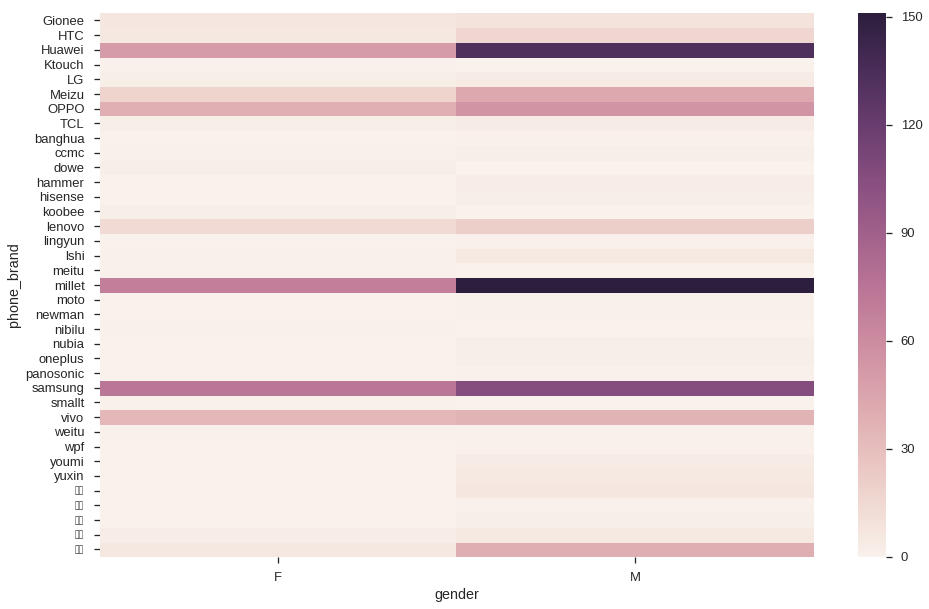

In [352]:
fig, ax = plt.subplots(1, figsize=(16, 10))
sns.heatmap(df.groupby(['phone_brand', 'gender']).size().unstack().fillna(0));

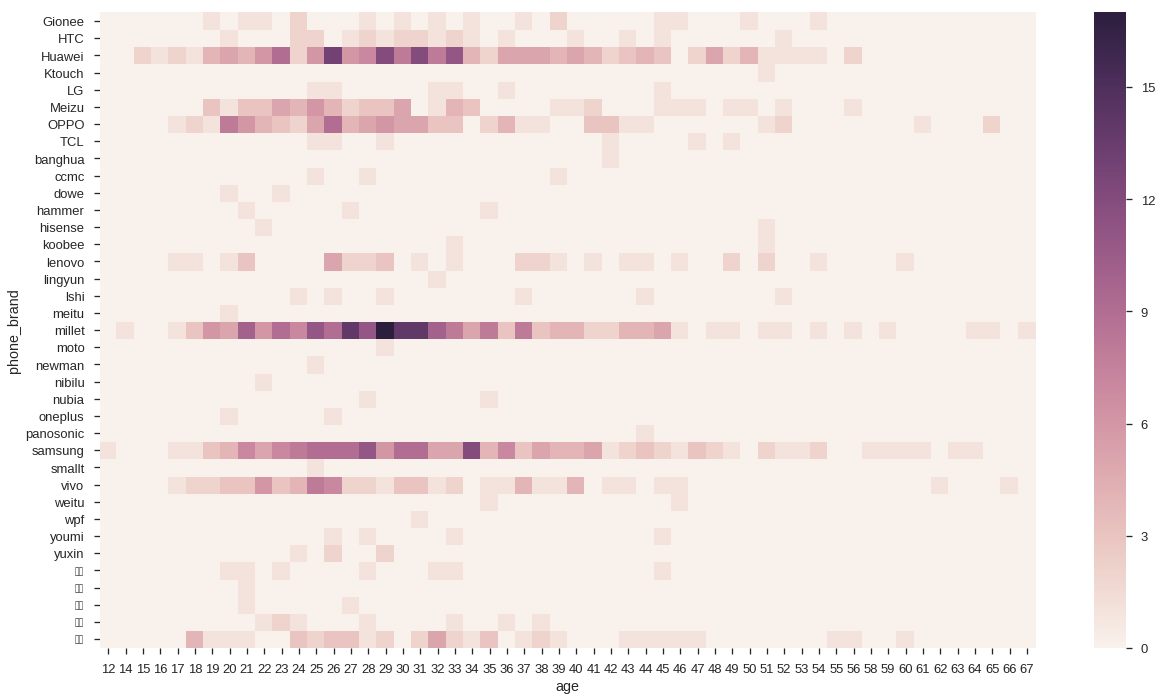

In [361]:
fig, ax = plt.subplots(1, figsize=(18, 10))
sns.heatmap(df.groupby(['phone_brand', 'age']).size().unstack().fillna(0))
plt.tight_layout();

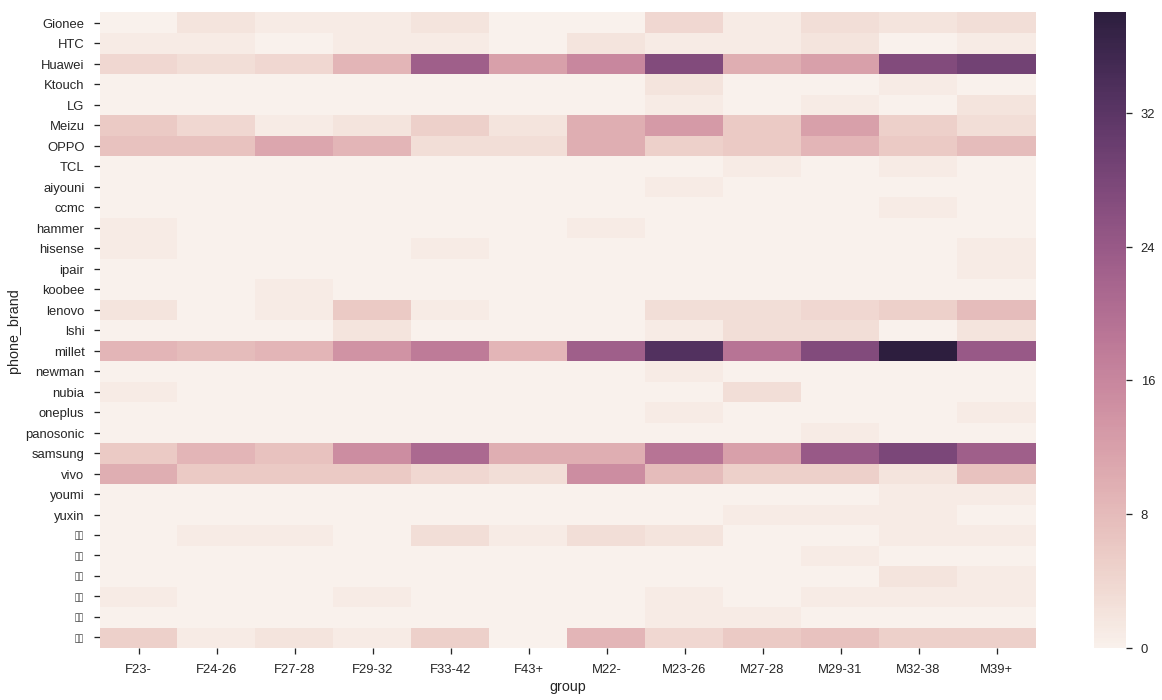

In [387]:
fig, ax = plt.subplots(1, figsize=(18, 10))
sns.heatmap(df.groupby(['phone_brand', 'group']).size().unstack().fillna(0))
plt.tight_layout();

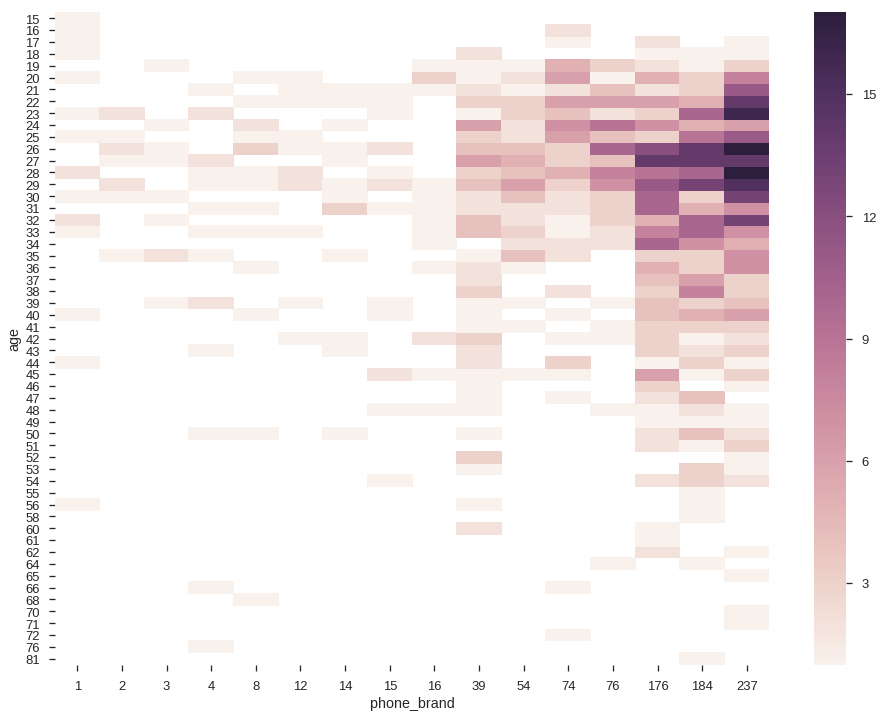

In [449]:
# relationship of phone brand frequency with target

phone_brand_freq = df.groupby('phone_brand')['phone_brand'].transform(lambda x: len(x))

fig, ax = plt.subplots(1, figsize=(16, 12))
sns.heatmap(df.groupby([phone_brand_freq, 'age']).size().unstack().T);

#### Device Model and Target

In [436]:
%%time

df =  gender_age_train.sample(n=1000).merge(phone_brand_device_model, on='device_id', how='left')

df.loc[:, 'phone_brand'] = df.phone_brand.map(lambda x: chinese_to_eng_brands[x] if x in chinese_to_eng_brands else x)
print(df.head())

             device_id gender  age   group phone_brand    device_model
0 -5775730697700401872      M   28  M27-28     samsung   Galaxy Note 3
1 -5393827957095810832      M   22    M22-     samsung      Galaxy Win
2  1918144665915653126      F   22    F23-          酷派           8190Q
3 -1972373650566211870      M   38  M32-38     samsung  Galaxy S3 Mini
4 -1093740390993965897      F   32  F29-32      Huawei             荣耀6
CPU times: user 53.2 ms, sys: 0 ns, total: 53.2 ms
Wall time: 463 ms


In [367]:
df.groupby(['device_model', 'gender']).size().unstack().fillna(0).sort_values(by='M', ascending=False)

gender,F,M
device_model,,
MI 2S,9.0,29.0
红米note,14.0,21.0
Galaxy Note 3,12.0,18.0
MI 3,12.0,16.0
荣耀3C,7.0,13.0
MI 4,10.0,12.0
小米note,0.0,12.0
红米1S,5.0,12.0
红米2,3.0,10.0


In [374]:
df.groupby(['device_model', 'age']).size().unstack().fillna(0)

age,15,16,17,18,19,20,21,22,23,24,...,64,65,66,67,68,71,74,75,76,78
device_model,,,,,,,,,,,,,,,,,,,,,
1107,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
201,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3005,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5263,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5360,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5890,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5891,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5891Q,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


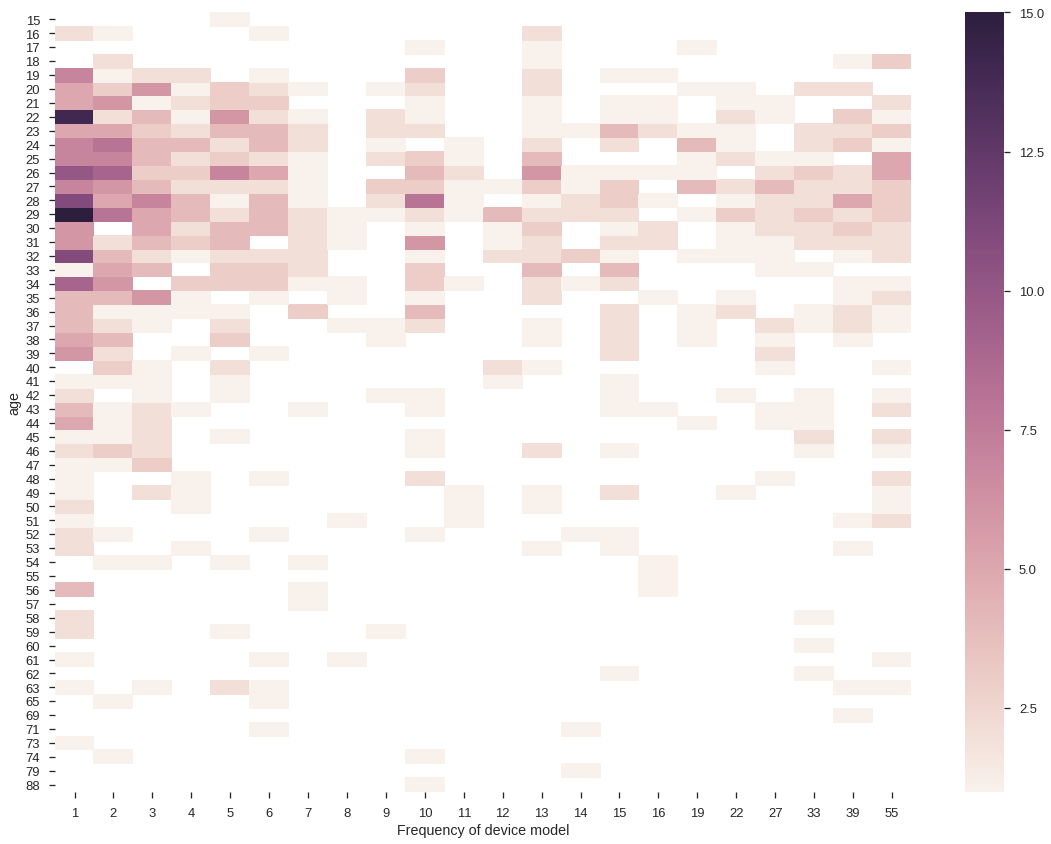

In [443]:
# relationship between device model ( frequency ) with target
device_model_freq = df.groupby('device_model')['device_model'].transform(lambda x: len(x))

fig, ax = plt.subplots(1, figsize=(16, 12))
sns.heatmap(df.groupby([device_model_freq, 'age']).size().unstack().T)
plt.xlabel('Frequency of device model')

plt.tight_layout();

#### App and Target

In [409]:
%%time

df =  gender_age_train.sample(n=1000)\
                      .merge(events, on='device_id', how='left')\
                      .merge(app_events, on='event_id', how='left')
    
print(df.head())

            device_id gender  age group event_id           timestamp  \
0  854675630746317372      M   14  M22-    50963 2016-05-07 16:50:01   
1  854675630746317372      M   14  M22-    50963 2016-05-07 16:50:01   
2  854675630746317372      M   14  M22-    50963 2016-05-07 16:50:01   
3  854675630746317372      M   14  M22-    50963 2016-05-07 16:50:01   
4  854675630746317372      M   14  M22-    50963 2016-05-07 16:50:01   

   longitude  latitude        app_id  is_active  
0        0.0       0.0 -6.793861e+18        1.0  
1        0.0       0.0  8.557199e+18        1.0  
2        0.0       0.0  5.927333e+18        1.0  
3        0.0       0.0 -8.446394e+18        1.0  
4        0.0       0.0  8.693964e+18        1.0  
CPU times: user 3.54 s, sys: 1.63 s, total: 5.17 s
Wall time: 30.3 s


In [412]:
ss = df.groupby(['app_id', 'gender']).size().unstack()
ss[ss['F'] > ss['M']]

gender,F,M
app_id,,
-9.189021e+18,6.0,4.0
-9.157897e+18,34.0,19.0
-9.059006e+18,7.0,1.0
-8.691453e+18,36.0,9.0
-8.653699e+18,4.0,2.0
-8.581608e+18,32.0,31.0
-8.556932e+18,72.0,28.0
-8.448784e+18,25.0,16.0
-8.446394e+18,26.0,19.0


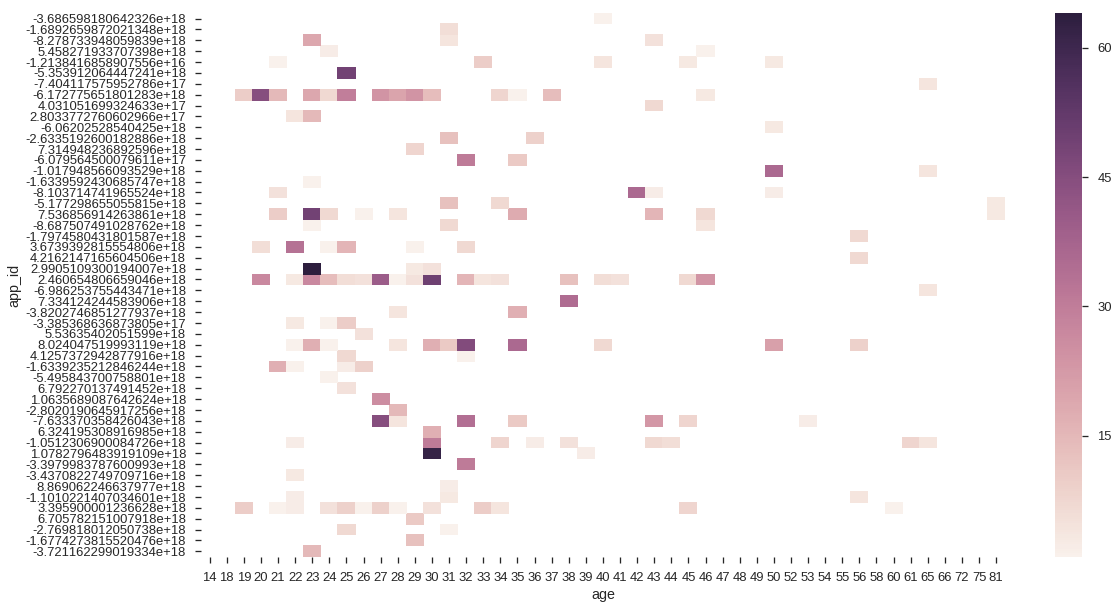

In [416]:
fig, ax = plt.subplots(1, figsize=(18, 10))
sns.heatmap(df.groupby(['app_id', 'age']).size().unstack().sample(n=50));

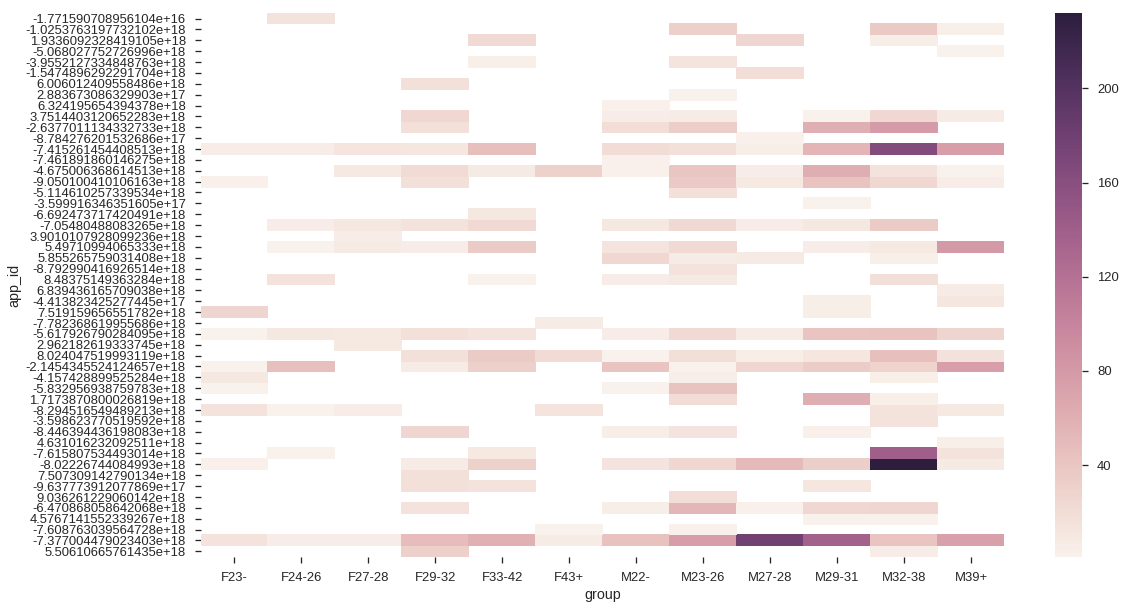

In [417]:
fig, ax = plt.subplots(1, figsize=(18, 10))
sns.heatmap(df.groupby(['app_id', 'group']).size().unstack().sample(n=50));

#### Events and Target

In [379]:
%%time

df =  gender_age_train.sample(n=1000).merge(events, on='device_id', how='left')

print(df.head())

             device_id gender  age   group  event_id           timestamp  \
0  1261217675108551833      M   34  M32-38       NaN                 NaT   
1 -8471928404439454173      F   29  F29-32       NaN                 NaT   
2  4445185817076348783      M   31  M29-31       NaN                 NaT   
3  1546548155803130298      M   19    M22-  437572.0 2016-05-04 09:24:09   
4  1546548155803130298      M   19    M22-  529696.0 2016-05-02 22:54:50   

   longitude  latitude  
0        NaN       NaN  
1        NaN       NaN  
2        NaN       NaN  
3     111.62     40.86  
4     111.62     40.86  
CPU times: user 278 ms, sys: 68.3 ms, total: 346 ms
Wall time: 349 ms


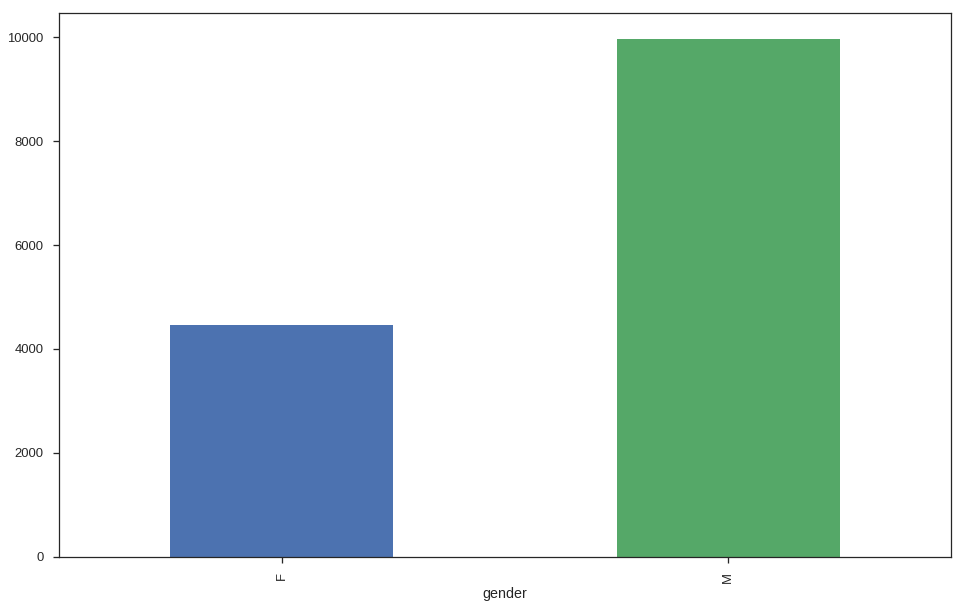

In [383]:
fig, ax = plt.subplots(1, figsize=(16, 10))
df.groupby('gender').apply(lambda x: x['event_id'].nunique()).plot(kind='bar');

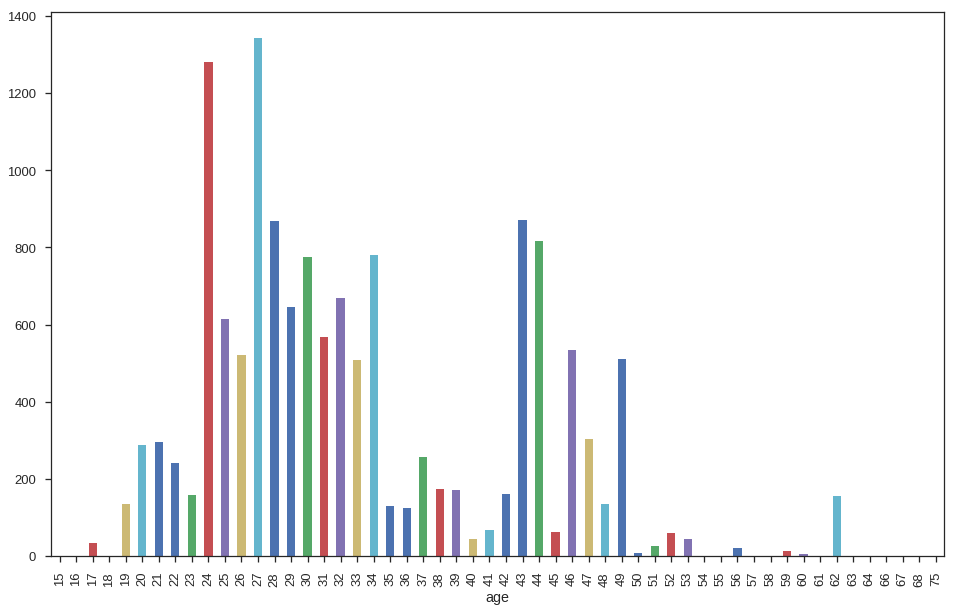

In [382]:
fig, ax = plt.subplots(1, figsize=(16, 10))
df.groupby('age').apply(lambda x: x['event_id'].nunique()).plot(kind='bar');

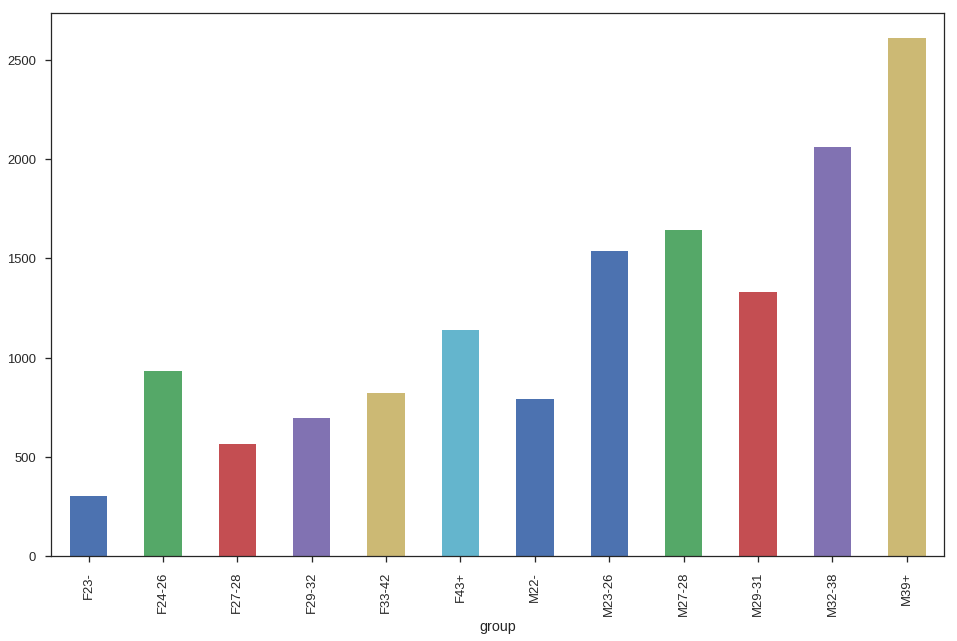

In [384]:
fig, ax = plt.subplots(1, figsize=(16, 10))
df.groupby('group').apply(lambda x: x['event_id'].nunique()).plot(kind='bar');

#### Timestamp and Target

In [388]:
%%time

df =  gender_age_train.sample(n=1000).merge(events, on='device_id', how='left')

print(df.head())

             device_id gender  age   group   event_id           timestamp  \
0  3657951820834494619      M   61    M39+        NaN                 NaT   
1  5627730181189645845      M   27  M27-28     2427.0 2016-05-06 03:27:02   
2  5627730181189645845      M   27  M27-28  2367189.0 2016-05-06 13:01:50   
3 -2726664844547268091      M   38  M32-38        NaN                 NaT   
4 -9114892721978755271      F   29  F29-32        NaN                 NaT   

   longitude  latitude  
0        NaN       NaN  
1        0.0       0.0  
2        0.0       0.0  
3        NaN       NaN  
4        NaN       NaN  
CPU times: user 300 ms, sys: 60 ms, total: 360 ms
Wall time: 362 ms


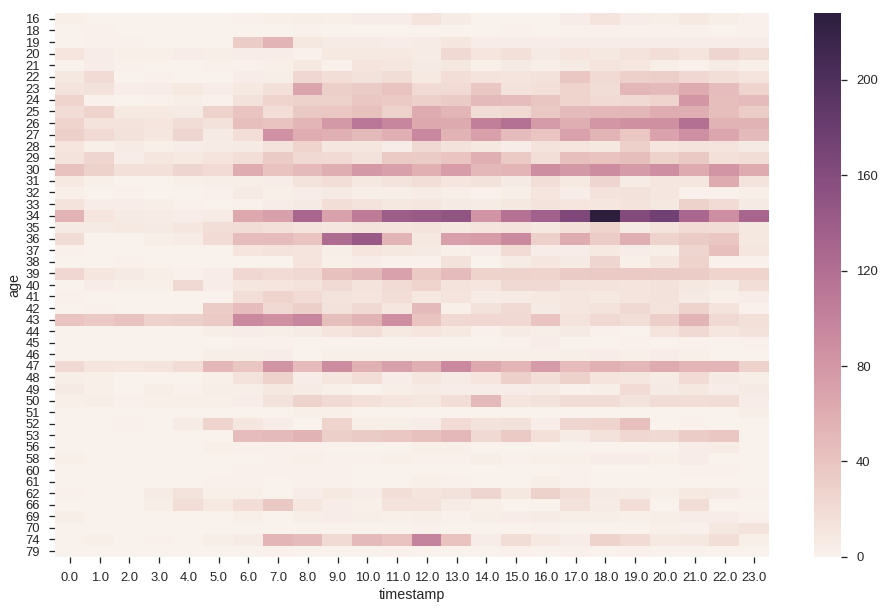

In [394]:
fig, ax = plt.subplots(1, figsize=(16, 10))
sns.heatmap(df.groupby([df.timestamp.dt.hour, 'age']).size().unstack().fillna(0).T);

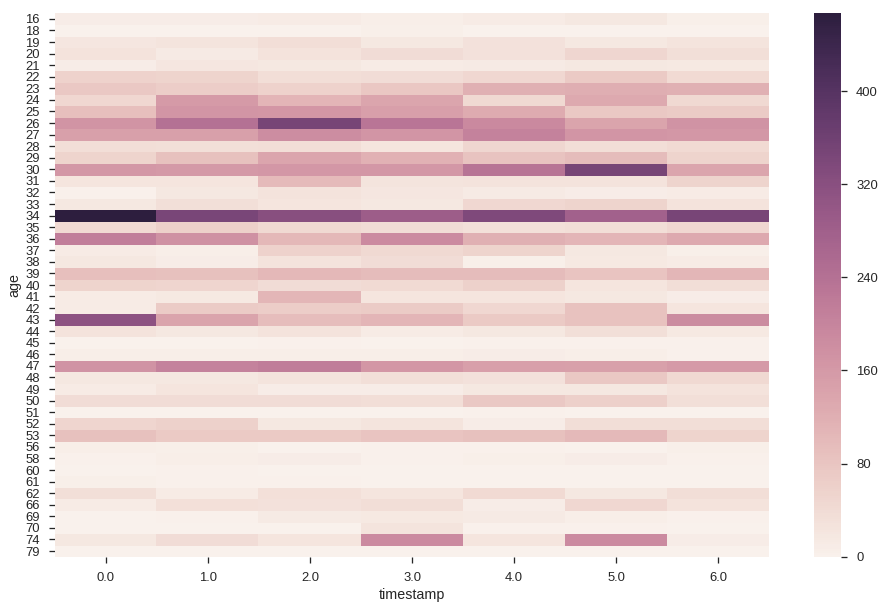

In [395]:
fig, ax = plt.subplots(1, figsize=(16, 10))
sns.heatmap(df.groupby([df.timestamp.dt.weekday, 'age']).size().unstack().fillna(0).T);

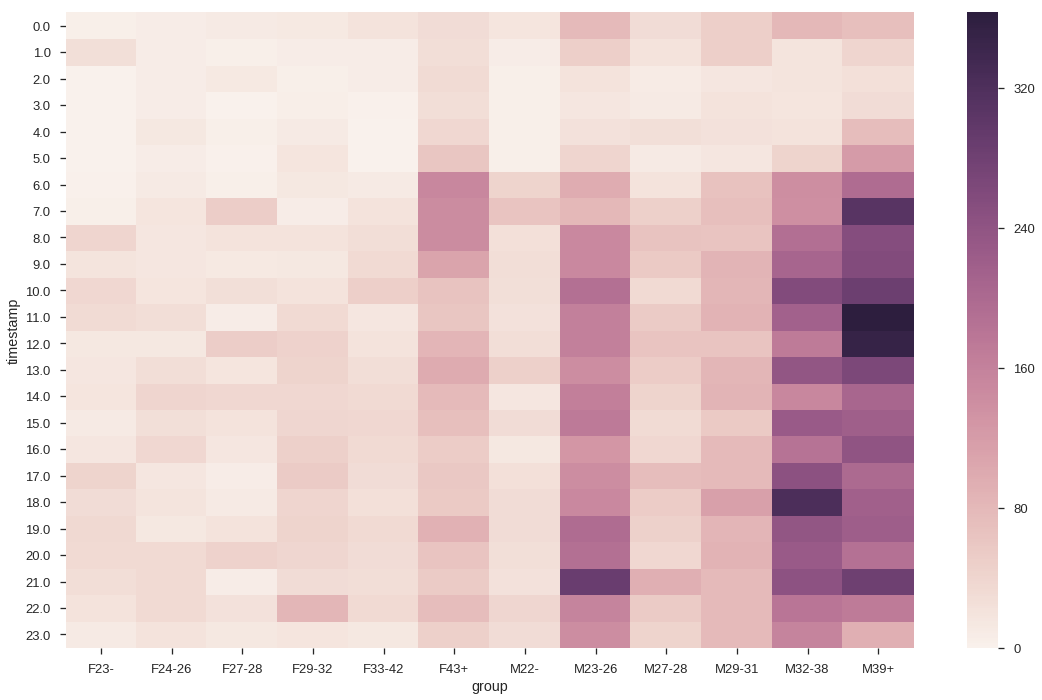

In [398]:
fig, ax = plt.subplots(1, figsize=(16, 10))
sns.heatmap(df.groupby([df.timestamp.dt.hour, 'group']).size().unstack().fillna(0))
plt.tight_layout();

#### Location and Target

In [399]:
%%time

df =  gender_age_train.sample(n=1000).merge(events, on='device_id', how='left')

print(df.head())

             device_id gender  age   group  event_id timestamp  longitude  \
0  -876616666260038168      M   30  M29-31       NaN       NaT        NaN   
1  4716680868101318501      F   65    F43+       NaN       NaT        NaN   
2  -233790202674127629      M   29  M29-31       NaN       NaT        NaN   
3  7520687516278212922      F   20    F23-       NaN       NaT        NaN   
4  4387848101176288048      M   20    M22-       NaN       NaT        NaN   

   latitude  
0       NaN  
1       NaN  
2       NaN  
3       NaN  
4       NaN  
CPU times: user 257 ms, sys: 95.2 ms, total: 352 ms
Wall time: 350 ms


In [408]:
df.groupby([df.longitude.astype(np.str) + '_' +\
            df.latitude.astype(np.str), 'age']).size().unstack()

age,10,11,15,16,17,18,19,20,21,22,...,61,62,63,64,65,66,67,68,71,77
0.0_0.0,NaN,2.0,NaN,NaN,30.0,NaN,42.0,138.0,109.0,158.0,...,NaN,NaN,10.0,NaN,8.0,NaN,5.0,NaN,NaN,NaN
0.1_0.17,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1.0_1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
102.52_24.33,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
102.53_24.33,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
102.53_24.35,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
102.64_25.04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
102.64_25.09,NaN,NaN,NaN,NaN,NaN,NaN,40.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
102.65_25.04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
102.65_25.05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#### is_active and Target

In [418]:
%%time

df =  gender_age_train.sample(n=1000)\
                      .merge(events, on='device_id', how='left')\
                      .merge(app_events, on='event_id', how='left')
    
print(df.head())

             device_id gender  age   group     event_id           timestamp  \
0  1586233736345944064      M   28  M27-28          NaN                 NaT   
1 -5741579398885958208      F   27  F27-28  1.18587e+06 2016-05-07 19:24:25   
2 -5741579398885958208      F   27  F27-28  1.18587e+06 2016-05-07 19:24:25   
3 -5741579398885958208      F   27  F27-28  1.18587e+06 2016-05-07 19:24:25   
4 -5741579398885958208      F   27  F27-28  1.18587e+06 2016-05-07 19:24:25   

   longitude  latitude        app_id  is_active  
0        NaN       NaN           NaN        NaN  
1        0.0       0.0  5.927333e+18        1.0  
2        0.0       0.0 -5.720079e+18        0.0  
3        0.0       0.0 -3.507530e+18        0.0  
4        0.0       0.0 -1.456585e+17        0.0  
CPU times: user 3.48 s, sys: 1.11 s, total: 4.59 s
Wall time: 4.68 s


In [419]:
df.groupby(['is_active', 'gender']).size()

is_active  gender
0.0        F         21119
           M         59702
1.0        F         13627
           M         45295
dtype: int64

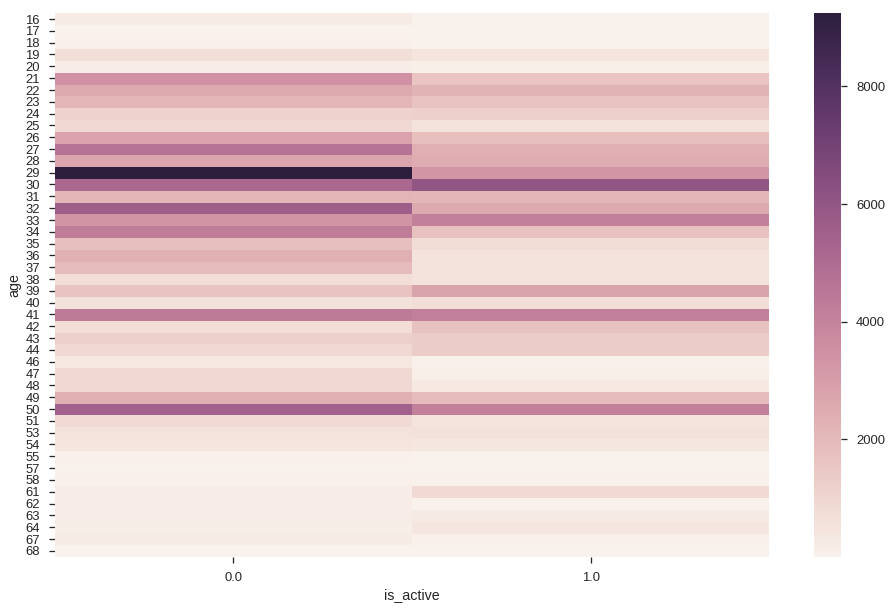

In [422]:
fig, ax = plt.subplots(1, figsize=(16, 10))
sns.heatmap(df.groupby(['is_active', 'age']).size().unstack().T);

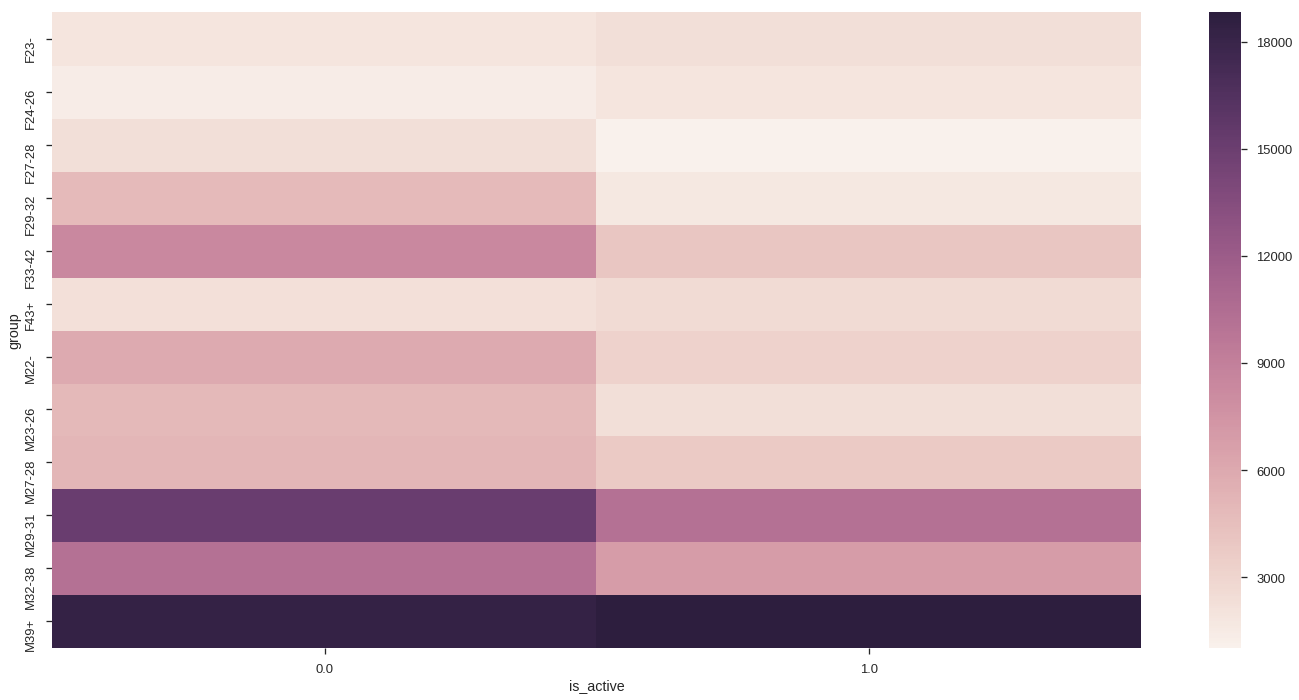

In [425]:
fig, ax = plt.subplots(1, figsize=(20, 10))
sns.heatmap(df.groupby(['is_active', 'group']).size().unstack().T)
plt.tight_layout();

#### App Category and Target

In [426]:
%%time

df = gender_age_train.sample(n=1000)\
                      .merge(events, on='device_id', how='left')\
                      .merge(app_events, on='event_id', how='left')\
                      .merge(app_labels, on='app_id', how='left')\
                      .merge(label_categories, on='label_id', how='left')
    
print(df.head())

             device_id gender  age   group event_id           timestamp  \
0  7730336322330977347      M   35  M32-38      NaN                 NaT   
1 -2545898892696195803      F   36  F33-42      NaN                 NaT   
2  3775107683976136187      F   36  F33-42      NaN                 NaT   
3 -4331780441902964302      M   21    M22-   268565 2016-05-05 02:56:10   
4 -4331780441902964302      M   21    M22-   414111 2016-05-02 02:59:42   

   longitude  latitude app_id  is_active label_id category  
0        NaN       NaN    NaN        NaN      NaN      NaN  
1        NaN       NaN    NaN        NaN      NaN      NaN  
2        NaN       NaN    NaN        NaN      NaN      NaN  
3     104.15     31.60    NaN        NaN      NaN      NaN  
4     104.25     31.09    NaN        NaN      NaN      NaN  
CPU times: user 4.01 s, sys: 1.13 s, total: 5.14 s
Wall time: 5.67 s


In [431]:
ss = df.groupby(['category', 'gender']).size().unstack().fillna(0)
ss

gender,F,M
category,,
1 free,23.0,41.0
And the Church,55.0,705.0
Consumer Finance,0.0,112.0
Contacts,0.0,40.0
Custom label,57.0,722.0
Customized 1,1.0,48.0
Debit and credit,55.0,568.0
Entertainment News,1.0,47.0
Express,0.0,5.0


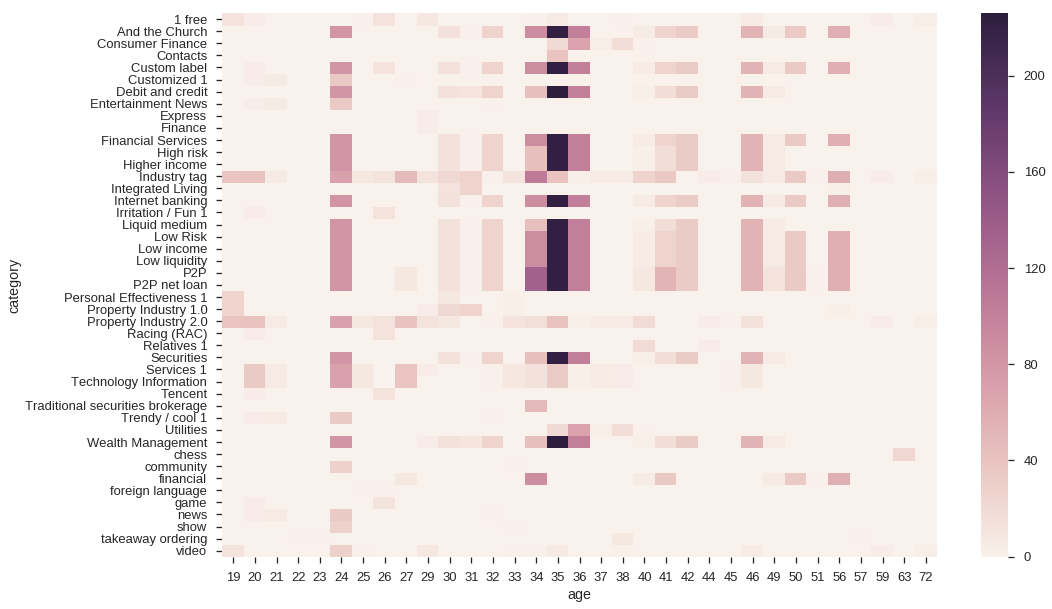

In [434]:
fig, ax = plt.subplots(1, figsize=(16, 10))
sns.heatmap(df.groupby(['category', 'age']).size().unstack().fillna(0));

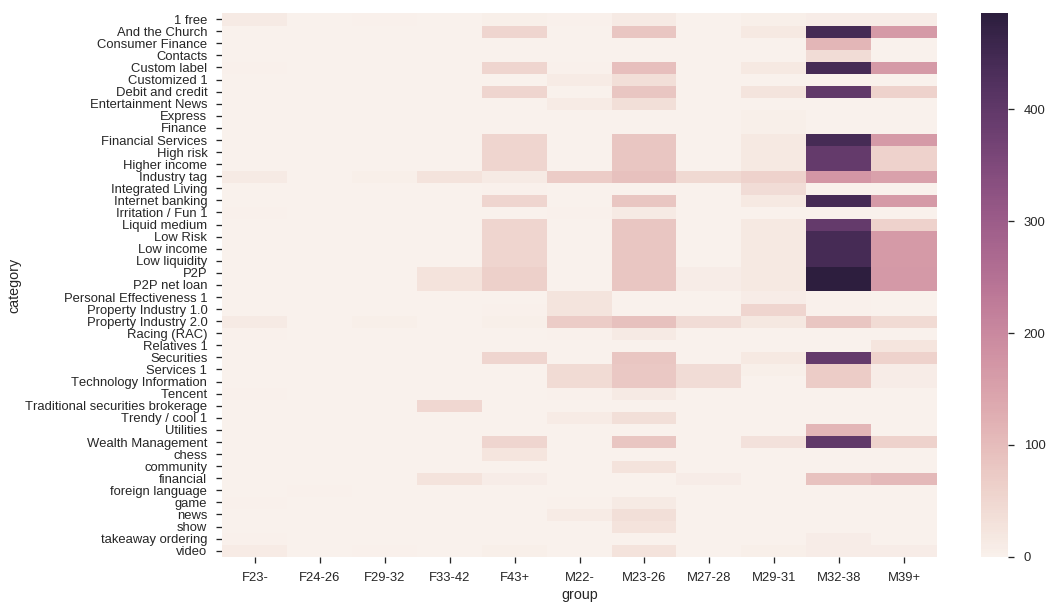

In [435]:
fig, ax = plt.subplots(1, figsize=(16, 10))
sns.heatmap(df.groupby(['category', 'group']).size().unstack().fillna(0));